In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde
from scipy import linalg
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

Using backend: pytorch



In [2]:
def solveBetaFunction(x, gamma, amp):
    beta = np.zeros(len(x))
    for idx, val in enumerate(x):
        beta[idx] = amp*math.cos(gamma*math.acos(val))
    return beta

def buildF(x, gamma1, amp1, gamma2, amp2):
    b1 = solveBetaFunction(x, gamma1, amp1)
    b2 = solveBetaFunction(x, gamma2, amp2)
    nx = len(x)
    f = np.zeros((nx, nx))
    for idx, val in enumerate(x):
        for idx2, val2 in enumerate(x):
            if idx <= idx2:
                f[idx][idx2] = b1[idx]*b2[idx2]
    return f

def buildCof_int_x_1(x, dx):
    nx = len(x)
    cof_int_x_1 = np.triu(np.ones((nx,nx)))
    cof_int_x_1[:,-1]=1/2*np.ones((1,nx))
    cof_int_x_1= dx*(cof_int_x_1-1/2*np.eye(nx))
    return cof_int_x_1

def buildCof_int_0_x(x, dx):
    nx = len(x)
    cof_int_0_x = np.tril(np.ones((nx,nx)))
    cof_int_0_x[:,0]=1/2*np.ones((1,nx))
    cof_int_0_x= dx*(cof_int_0_x-1/2*np.eye(nx))
    return cof_int_0_x

def findinterpolation(kappabud, spatial1, spatial2):
    fx = interp1d(spatial1, kappabud, kind="cubic")
    kappabudInterp = fx(spatial2)
    return kappabudInterp

def zeroToNan(x):
    for j in range(len(x)):
        for i in range(len(x)):
            if i > j:
                x[i][j] = float('nan')
    return x

def solveControl(u, Kbud, Lbud, Jbud, nx, dx, tau_obs, k):
    return (sum(Kbud*u[0:nx]*dx) +tau_obs*sum(Lbud*u[nx:2*nx]*dx)+k*sum(Jbud*u[2*nx:3*nx]*dx)
            - Kbud[0]*u[0]*dx/2
            - Kbud[nx-1]*u[nx-1]*dx/2
            - tau_obs*Lbud[0]*u[nx]*dx/2
            - tau_obs*Lbud[nx-1]*u[2*nx-1]*dx/2
            - k*Jbud[0]*u[2*nx]*dx/2
            - k*Jbud[nx-1]*u[3*nx-1]*dx/2)

def solveControl_without_com(u, Kbud, Lbud, Jbud, nx, dx, tau_obs, k):
    return (sum(Kbud*u[0:nx]*dx)  
            - Kbud[0]*u[0]*dx/2
            - Kbud[nx-1]*u[nx-1]*dx/2 )

def solveOpenLoop(_, _a, _b, _c, _d, _e, _f, _g):
    return 0

def fastKernelCalc(f, c, tau, tau_obs, x, cof_int_x_1, cof_int_0_x):
    nx = len(x) 
    dx=x[2]-x[1]
    k=tau-tau_obs
    Ntau=int(tau/dx)+1
    K = np.zeros((nx, nx))
    result = 0
    for i in range(nx-2, -1, -1):
        result += (f[[i+1],[i+1]] + f[[i],[i]])*dx/2*(-1)
        K[i,i] = result
    for i in range(nx-2, -1, -1):
        num = nx - i
        A1 = np.diag([-2]*num) + np.diag([1]*(num-1),1)
        A1[[0],[0]] = 1
        A1[[0],[1]] = 0
        A1[[-1],[-1]] = 1

        A121=np.zeros((num,num))
        A122=np.zeros((num,num))
        A121[1:num-1,0:num-1]= f.T[i+1:i-1+num,i:i-1+num]
        A122[0:num-1,0:num-1] = dx*cof_int_0_x[0:num-1,0:num-1] 
        A1 = A1+ A121*A122
        B1=np.zeros((num,1))
        B1[[0],[0]] = K[[i],[i]]
        B1[1:num-1,0] =-K[[i+1],i+1:nx-1].reshape((num-2)) +(dx*f[i,i+1:nx-1]).reshape((num-2))
        if i+ Ntau<nx:
            B1[num-1,0]=sum(cof_int_x_1[i+Ntau-1,:]*K[i+Ntau-1,:]*c)-c[i+Ntau-1]
        else:
            B1[num-1,0]=0
        D=np.linalg.solve(A1,B1)
        K[[i],i:nx]=D.T

    J=np.zeros((nx, nx))
    c_matrix=np.repeat(c[np.newaxis,:], nx, 0)
    J[0:nx,0]=np.sum(cof_int_x_1*c_matrix*K, axis=1)-c[0:nx]
    AJ = np.diag([k+1]*nx) + np.diag([-1]*(nx-1),-1)
    AJ[0,0]=1
    for i in range(nx-2, -1, -1):
        BJ=np.zeros((nx,1))
        BJ[0,0]=J[i,0]
        BJ[1:nx,0]=k*J[i+1,1:nx]
        J[[i],0:nx]=(np.linalg.solve(AJ,BJ)).T
    
    L=np.zeros((nx, nx))
    L[0:nx,0]=J[0:nx,-1]
    AL = np.diag([tau_obs+1]*nx) + np.diag([-1]*(nx-1),-1)
    AL[0,0]=1
    for i in range(nx-2, -1, -1):
        BL=np.zeros((nx,1))
        BL[0,0]=L[i,0]
        BL[1:nx,0]=tau_obs*L[i+1,1:nx]
        L[[i],0:nx]=(np.linalg.solve(AL,BL)).T
    return K, L, J

def fastObserverGainCalc(f, tau_obs, a, x, cof_int_x_1):
    nx = len(x) 
    dx = x[2] - x[1]
    F1 = np.zeros((nx, nx))
    result = 0
    for i in range(1, nx, 1):
        result += (f[[i-1],[i-1]] + f[[i],[i]])*dx/2*(-1/a)
        F1[i,i] = result
    for j in range(2, nx, 1):
        num = j
        CC1 = np.diag([2]*num) + np.diag([-1]*(num-1),-1)
        CC1[[-1],[num-2]] = 0
        CC1[[-1],[num-1]] = 1
        CC21=np.zeros((num,num))
        CC22=np.zeros((num,num))
        CC21= f[1:1+num,1:1+num]
        CC22 = -(dx/a)*cof_int_x_1[nx-j:nx,nx-j:nx]
        CC = CC1+ CC21*CC22 
        DD=np.zeros((num,1))
        DD[-1, 0] = F1[j,j]
        DD[0:num-1,0] = F1[1:j,j-1].reshape((num-1)) -(dx/a*f[1:j,j]).reshape((num-1))
        D=np.linalg.solve(CC,DD)
        D2=np.dot(np.linalg.inv(CC),DD)
        F1[1:j+1,j]=D.T

    F23 = np.zeros((nx, nx))
    F23[:,-1]=a*tau_obs*F1[:,-1]
    # EE1 = np.diag([1+a*tau_obs]*(nx-1)) + np.diag([-a*tau_obs]*(nx-2),-1)
    # EE21 = -dx*tau_obs*cof_int_x_1[1:nx,1:nx]
    # EE22 = f[1:nx,1:nx]
    EE = np.diag([1+a*tau_obs]*(nx-1)) + np.diag([-a*tau_obs]*(nx-2),-1)\
        -(dx*tau_obs*cof_int_x_1[1:nx,1:nx]) * f[1:nx,1:nx]
    EE_inv = np.linalg.inv(EE)
    for j in range(nx-2,-1,-1):
        F23[1:nx,j] =  np.dot(EE_inv, F23[1:nx,j+1])
    
    Q1 = -F23[:,0]/tau_obs
    Q2 = -np.flipud(F23[-1,:])
    return F1, F23, Q1, Q2

def solvePDE(tau, tau_obs, c, f, Kbud, Lbud, Jbud, init_condition, x, t, printFreq=500):
    k=tau-tau_obs
    nx = len(x)
    nt = len(t)
    dx=x[1]-x[0]
    dt=t[1]-t[0]
    uu = np.zeros((nt, 3*nx))
    uu[0,:] = init_condition
    for i in range(1, nt):
        if i%int(printFreq) == 0:
            print("Completed:", i, "/", nt, flush=True)
            
        uu[i][0] = solveControl(uu[i-1], Kbud, Lbud, Jbud, nx, dx,tau_obs,k)
        fres = np.zeros(nx)
        for j in range(1, nx):
            fres[j] = sum(f[j][j:nx]*uu[i-1][j:nx])*dx-f[j][j]*uu[i-1][j]*dx/2-f[j][nx-1]*uu[i-1][nx-1]*dx/2
        uu[i][2*nx-1]=uu[i-1][nx-1]
        uu[i][nx:2*nx-1] = uu[i-1][nx:2*nx-1]+dt/(tau_obs*dx)*(uu[i-1][nx+1:2*nx]-uu[i-1][nx:2*nx-1])
        uu[i][3*nx-1]=uu[i-1][nx]
        uu[i][2*nx:3*nx-1] = uu[i-1][2*nx:3*nx-1]+dt/(k*dx)*(uu[i-1][2*nx+1:3*nx]-uu[i-1][2*nx:3*nx-1])
        uu[i][1:nx] = uu[i-1][1:nx] - dt/dx*(uu[i-1][1:nx] - uu[i-1][0:nx-1]) + dt*fres[1:nx] + dt*c[1:nx]*uu[i-1][2*nx]
    return uu

def solveBetaFunction(x, gamma, amp):
    beta = np.zeros(len(x))
    for idx, val in enumerate(x):
        beta[idx] = amp*math.cos(gamma*math.acos(val))
    return beta

def buildF(x, gamma1, amp1, gamma2, amp2):
    b1 = solveBetaFunction(x, gamma1, amp1)
    b2 = solveBetaFunction(x, gamma2, amp2)
    nx = len(x)
    f = np.zeros((nx, nx))
    for idx, val in enumerate(x):
        for idx2, val2 in enumerate(x):
            if idx <= idx2:
                f[idx][idx2] = b1[idx]*b2[idx2]
    return f

def buildtau(nx,tau):
    tau_matrix = tau * np.ones((nx, nx))
    # tau_matrix = np.triu(tau_matrix)
    tau_matrix = tau_matrix.reshape(1, -1)
    return tau_matrix

def buildCof_int_x_1(x, dx):
    nx = len(x)
    cof_int_x_1 = np.triu(np.ones((nx,nx)))
    cof_int_x_1[:,-1]=1/2*np.ones((1,nx))
    cof_int_x_1= dx*(cof_int_x_1-1/2*np.eye(nx))
    return cof_int_x_1

def buildCof_int_0_x(x, dx):
    nx = len(x)
    cof_int_0_x = np.tril(np.ones((nx,nx)))
    cof_int_0_x[:,0]=1/2*np.ones((1,nx))
    cof_int_0_x= dx*(cof_int_0_x-1/2*np.eye(nx))
    return cof_int_0_x

def findinterpolation(kappabud, spatial1, spatial2):
    fx = interp1d(spatial1, kappabud, kind="cubic")
    kappabudInterp = fx(spatial2)
    return kappabudInterp

def zeroToNan(x):
    for j in range(len(x)):
        for i in range(len(x)):
            if i > j:
                x[i][j] = float('nan')
    return x

def solveControl(u, Kbud, Lbud, Jbud, nx, dx, tau_obs, k):
    return (sum(Kbud*u[0:nx]*dx) +tau_obs*sum(Lbud*u[nx:2*nx]*dx)+k*sum(Jbud*u[2*nx:3*nx]*dx)
            - Kbud[0]*u[0]*dx/2
            - Kbud[nx-1]*u[nx-1]*dx/2
            - tau_obs*Lbud[0]*u[nx]*dx/2
            - tau_obs*Lbud[nx-1]*u[2*nx-1]*dx/2
            - k*Jbud[0]*u[2*nx]*dx/2
            - k*Jbud[nx-1]*u[3*nx-1]*dx/2)



def solveOpenLoop(_, _a, _b, _c, _d, _e, _f, _g):
    return 0



def solvePDEwithObse(tau, tau_obs,  c, f, Kbud, Lbud, Jbud,  Q1, Q2, init_condition, init_condition_obs, x, t, printFreq):
    ## tau is state delay
    ## tau_obs is sensor delay
    k=tau-tau_obs
    nx = len(x) 
    dx = x[2] - x[1]
    nt = len(t)
    dt = t[1]-t[0] 
    ###### initialization
    u = np.zeros((nt, 3*nx))
    u_est = np.zeros((nt, 3*nx)) 
    u[0,:] = init_condition
    u_est[0,:] = init_condition_obs
    print("Solving PDE... Timesteps Needed:", nt, flush=True) 
    for i in range(1,nt,1):
        if i%int(printFreq) == 0:
            print("Completed:", i, "/", nt, flush=True)
        u[i,0] = sum(Kbud*u_est[i-1,0:nx]*dx)   \
            - Kbud[0]*u_est[i-1,0]*dx/2 - Kbud[nx-1]*u_est[i-1,nx-1]*dx/2 \
            + sum(tau_obs*Lbud*u_est[i-1,nx:2*nx]*dx )  \
            - tau_obs*Lbud[0]*u_est[i-1,nx]*dx/2 \
            - tau_obs*Lbud[nx-1]*u_est[i-1,2*nx-1]*dx/2 \
            + sum(k*Jbud*u_est[i-1,2*nx:3*nx]*dx ) \
            - k*Jbud[0]*u_est[i-1,2*nx]*dx/2 \
            - k*Jbud[nx-1]*u_est[i-1,3*nx-1]*dx/2  
        fres = np.zeros(nx)
        for j in range(1, nx):
            fres[j] = sum(f[j,j:nx]*u[i-1,j:nx])*dx-f[j][j]*u[i-1][j]*dx/2-f[j][nx-1]*u[i-1][nx-1]*dx/2
        
        u[i][2*nx-1]=u[i-1][nx-1]
        u[i][nx:2*nx-1] = u[i-1][nx:2*nx-1]+dt/(tau_obs*dx)*(u[i-1][nx+1:2*nx]-u[i-1][nx:2*nx-1])
        u[i][3*nx-1]=u[i-1][nx]
        u[i][2*nx:3*nx-1] = u[i-1][2*nx:3*nx-1]+dt/(k*dx)*(u[i-1][2*nx+1:3*nx]-u[i-1][2*nx:3*nx-1])
        u[i][1:nx] = u[i-1][1:nx] - dt/dx*(u[i-1][1:nx] - u[i-1][0:nx-1]) + dt*fres[1:nx] + dt*c[1:nx]*u[i-1][2*nx]
        
        ##### observer part for \hat x
        u_est[i,0] = u[i,0]
        fresu_est = np.zeros(nx)
        for j in range(1, nx):
            fresu_est[j] = sum(f[j,j:nx]*u_est[i-1,j:nx])*dx-f[j][j]*u_est[i-1][j]*dx/2-f[j][nx-1]*u_est[i-1][nx-1]*dx/2
        
        u_est[i,1:nx] = u_est[i-1,1:nx] - dt/dx*(u_est[i-1,1:nx] - u_est[i-1,0:nx-1]) \
            + dt*fresu_est[1:nx] + dt*c[1:nx]*u_est[i-1,2*nx] + dt*Q1[1:nx]*(u[i-1,nx] -u_est[i-1,nx])
        ##### observer part for \hat u1
        u_est[i, 2*nx-1] = u_est[i,nx-1]
        u_est[i,nx:2*nx-1] = u_est[i-1,nx:2*nx-1] + dt/(tau_obs*dx)*(u_est[i-1,nx+1:2*nx]- u_est[i-1,nx:2*nx-1]) \
        + dt*Q2[0:nx-1]/tau_obs * (u[i-1,nx] -u_est[i-1,nx])
        ##### observer part for \hat u2
        u_est[i, 3*nx-1] = u[i,nx]
        u_est[i,2*nx:3*nx-1] = u_est[i-1,2*nx:3*nx-1] + dt/(k*dx)*(u_est[i-1,2*nx+1:3*nx]- u_est[i-1,2*nx:3*nx-1]) 
    return u, u_est


def solvePDEwithObse_withoutctrl(tau, tau_obs,  c, f, Kbud, Lbud, Jbud,  Q1, Q2, init_condition, init_condition_obs, x, t, printFreq):
    ## tau is state delay
    ## tau_obs is sensor delay
    k=tau-tau_obs
    nx = len(x) 
    dx = x[2] - x[1]
    nt = len(t)
    dt = t[1]-t[0] 
    ###### initialization
    u = np.zeros((nt, 3*nx))
    u_est = np.zeros((nt, 3*nx)) 
    u[0,:] = init_condition
    u_est[0,:] = init_condition_obs
    print("Solving PDE... Timesteps Needed:", nt, flush=True) 
    for i in range(1,nt,1):
        if i%int(printFreq) == 0:
            print("Completed:", i, "/", nt, flush=True)
        u[i,0] = 0  
        fres = np.zeros(nx)
        for j in range(1, nx):
            fres[j] = sum(f[j,j:nx]*u[i-1,j:nx])*dx-f[j][j]*u[i-1][j]*dx/2-f[j][nx-1]*u[i-1][nx-1]*dx/2
        
        u[i][2*nx-1]=u[i-1][nx-1]
        u[i][nx:2*nx-1] = u[i-1][nx:2*nx-1]+dt/(tau_obs*dx)*(u[i-1][nx+1:2*nx]-u[i-1][nx:2*nx-1])
        u[i][3*nx-1]=u[i-1][nx]
        u[i][2*nx:3*nx-1] = u[i-1][2*nx:3*nx-1]+dt/(k*dx)*(u[i-1][2*nx+1:3*nx]-u[i-1][2*nx:3*nx-1])
        u[i][1:nx] = u[i-1][1:nx] - dt/dx*(u[i-1][1:nx] - u[i-1][0:nx-1]) + dt*fres[1:nx] + dt*c[1:nx]*u[i-1][2*nx]
        
        ##### observer part for \hat x
        u_est[i,0] = u[i,0]
        fresu_est = np.zeros(nx)
        for j in range(1, nx):
            fresu_est[j] = sum(f[j,j:nx]*u_est[i-1,j:nx])*dx-f[j][j]*u_est[i-1][j]*dx/2-f[j][nx-1]*u_est[i-1][nx-1]*dx/2
        
        u_est[i,1:nx] = u_est[i-1,1:nx] - dt/dx*(u_est[i-1,1:nx] - u_est[i-1,0:nx-1]) \
            + dt*fresu_est[1:nx] + dt*c[1:nx]*u_est[i-1,2*nx] + dt*Q1[1:nx]*(u[i-1,nx] -u_est[i-1,nx])
        ##### observer part for \hat u1
        u_est[i, 2*nx-1] = u_est[i,nx-1]
        u_est[i,nx:2*nx-1] = u_est[i-1,nx:2*nx-1] + dt/(tau_obs*dx)*(u_est[i-1,nx+1:2*nx]- u_est[i-1,nx:2*nx-1]) \
        + dt*Q2[0:nx-1]/tau_obs * (u[i-1,nx] -u_est[i-1,nx])
        ##### observer part for \hat u2
        u_est[i, 3*nx-1] = u[i,nx]
        u_est[i,2*nx:3*nx-1] = u_est[i-1,2*nx:3*nx-1] + dt/(k*dx)*(u_est[i-1,2*nx+1:3*nx]- u_est[i-1,2*nx:3*nx-1]) 
    return u, u_est

def solvePDEwithObse_withoutctrl(tau, tau_obs,  c, f, Kbud, Lbud, Jbud,  Q1, Q2, init_condition, init_condition_obs, x, t, printFreq):
    ## tau is state delay
    ## tau_obs is sensor delay
    k=tau-tau_obs
    nx = len(x) 
    dx = x[2] - x[1]
    nt = len(t)
    dt = t[1]-t[0] 
    ###### initialization
    u = np.zeros((nt, 3*nx))
    u_est = np.zeros((nt, 3*nx)) 
    u[0,:] = init_condition
    u_est[0,:] = init_condition_obs
    print("Solving PDE... Timesteps Needed:", nt, flush=True) 
    for i in range(1,nt,1):
        if i%int(printFreq) == 0:
            print("Completed:", i, "/", nt, flush=True)
        u[i,0] = 5*np.sin(3*math.pi*i*dt) +3*np.cos(2*math.pi*i*dt)
        fres = np.zeros(nx)
        for j in range(1, nx):
            fres[j] = sum(f[j,j:nx]*u[i-1,j:nx])*dx-f[j][j]*u[i-1][j]*dx/2-f[j][nx-1]*u[i-1][nx-1]*dx/2
        
        u[i][2*nx-1]=u[i-1][nx-1]
        u[i][nx:2*nx-1] = u[i-1][nx:2*nx-1]+dt/(tau_obs*dx)*(u[i-1][nx+1:2*nx]-u[i-1][nx:2*nx-1])
        u[i][3*nx-1]=u[i-1][nx]
        u[i][2*nx:3*nx-1] = u[i-1][2*nx:3*nx-1]+dt/(k*dx)*(u[i-1][2*nx+1:3*nx]-u[i-1][2*nx:3*nx-1])
        u[i][1:nx] = u[i-1][1:nx] - dt/dx*(u[i-1][1:nx] - u[i-1][0:nx-1]) + dt*fres[1:nx] + dt*c[1:nx]*u[i-1][2*nx]
        
        ##### observer part for \hat x
        u_est[i,0] = u[i,0]
        fresu_est = np.zeros(nx)
        for j in range(1, nx):
            fresu_est[j] = sum(f[j,j:nx]*u_est[i-1,j:nx])*dx-f[j][j]*u_est[i-1][j]*dx/2-f[j][nx-1]*u_est[i-1][nx-1]*dx/2
        
        u_est[i,1:nx] = u_est[i-1,1:nx] - dt/dx*(u_est[i-1,1:nx] - u_est[i-1,0:nx-1]) \
            + dt*fresu_est[1:nx] + dt*c[1:nx]*u_est[i-1,2*nx] + dt*Q1[1:nx]*(u[i-1,nx] -u_est[i-1,nx])
        ##### observer part for \hat u1
        u_est[i, 2*nx-1] = u_est[i,nx-1]
        u_est[i,nx:2*nx-1] = u_est[i-1,nx:2*nx-1] + dt/(tau_obs*dx)*(u_est[i-1,nx+1:2*nx]- u_est[i-1,nx:2*nx-1]) \
        + dt*Q2[0:nx-1]/tau_obs * (u[i-1,nx] -u_est[i-1,nx])
        ##### observer part for \hat u2
        u_est[i, 3*nx-1] = u[i,nx]
        u_est[i,2*nx:3*nx-1] = u_est[i-1,2*nx:3*nx-1] + dt/(k*dx)*(u_est[i-1,2*nx+1:3*nx]- u_est[i-1,2*nx:3*nx-1]) 
    return u, u_est

In [3]:
## time
T = 5
dt = 0.001
nt = int(round(T/dt))+1
temporal = np.linspace(0, T, nt)
## space
X = 1
# dx = dt*a
dx = 0.02
nx = int(round(X/dx))+1
spatial = np.linspace(0, X, nx)

## system parameters

tau = 1
tau_obs = 0.5
k=tau-tau_obs
#c=1-spatial
c=solveBetaFunction(spatial, 5, 1)
c = c-c[-1]
f =buildF(spatial, 5, 3, 5, 3)
# meshy, meshx = np.meshgrid(spatial, spatial)
# f=2*np.cos(2*np.pi*meshx)+2*np.sin(2*np.pi*meshy)
# f=zeroToZero(f)


In [4]:
cof_int_x_1 = buildCof_int_x_1(spatial, dx)
cof_int_0_x = buildCof_int_0_x(spatial, dx)

In [5]:
grids0 = []
grids0.append(np.linspace(0, 1, nx, dtype=np.float32))
grids0.append(np.linspace(0, 1, nx, dtype=np.float32))
grid0 = np.vstack([xx.ravel() for xx in np.meshgrid(*grids0)]).T
grid2d = torch.from_numpy(grid0).cuda()

In [6]:
grids = []
grids.append(np.linspace(0, 1, nx, dtype=np.float32))
grid=np.array(grids, dtype=np.float32).T
grid = torch.from_numpy(np.array(grid, dtype=np.float32)).cuda()

In [7]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [8]:
class BranchNet1(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64,
                       kernel_size=5, stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128,
                       kernel_size=5, stride=2)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(12800, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 3, self.shape, self.shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [9]:
class BranchNet2(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(in_channels=4, out_channels=64,
                       kernel_size=5, stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128,
                       kernel_size=5, stride=2)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(12800, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 4, self.shape, self.shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [10]:
class BranchNet_obs(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=64,
                       kernel_size=5, stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128,
                       kernel_size=5, stride=2)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(12800, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 2, self.shape, self.shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [11]:
# Define a sequential torch network for batch and trunk 
dim_x2 = 2 
m1 = 3*nx*nx
m2 = 4*nx*nx
branchk1 = BranchNet1(nx)
branchk2 = BranchNet2(nx)
branchk3 = BranchNet2(nx)
modelk1 = dde.nn.DeepONetCartesianProd([m1, branchk1], [dim_x2, 128,  256], "relu", "Glorot normal").cuda()
modelk2 = dde.nn.DeepONetCartesianProd([m2, branchk2], [dim_x2, 128,  256], "relu", "Glorot normal").cuda()
modelk3 = dde.nn.DeepONetCartesianProd([m2, branchk3], [dim_x2, 128,  256], "relu", "Glorot normal").cuda()
print(count_params(modelk1))
print(count_params(modelk2))
print(count_params(modelk3))

6928641
6930241
6930241


In [12]:
# Define a torch network for batch and trunk.
dim_x1 = 1 
m3 = 2*nx*nx
branchobs1 = BranchNet_obs(nx)
branchobs2= BranchNet_obs(nx) 
modelobs1 = dde.nn.DeepONetCartesianProd([m3, branchobs1], [dim_x1, 128,  256], "relu", "Glorot normal").cuda()
modelobs2 = dde.nn.DeepONetCartesianProd([m3, branchobs2], [dim_x1, 128,  256], "relu", "Glorot normal").cuda() 
print(count_params(modelobs1))
print(count_params(modelobs2))
 

6926913
6926913


In [13]:
path1='./Model/cftauToCtrlTorchMode1.pth' 
path2='./Model/cftauToCtrlTorchMode2.pth'
path3='./Model/cftauToCtrlTorchMode3.pth'
path4='./Model/ObseTorchMode1.pth' 
path5='./Model/ObseTorchMode2.pth'
modelk1.load_state_dict(torch.load(path1))
modelk2.load_state_dict(torch.load(path2))
modelk3.load_state_dict(torch.load(path3))
modelobs1.load_state_dict(torch.load(path4))
modelobs2.load_state_dict(torch.load(path5)) 

<All keys matched successfully>

In [14]:
tau = 1
tau_obs = 0.5
k=tau-tau_obs
# c=1-spatial
c = solveBetaFunction(spatial, 5, 1)
c = c-c[-1]
f =buildF(spatial, 5, 3, 5, 3)

In [15]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)

In [16]:
K,L,J=fastKernelCalc(f, c, tau, tau_obs, spatial, cof_int_x_1, cof_int_0_x)
F1, F23, Q1, Q2 = fastObserverGainCalc(f, tau_obs, 1, spatial, cof_int_x_1)

In [17]:
f =buildF(spatial, 5, 3, 5, 3)
tau_matrix=buildtau(nx,tau)
tauobs_matrix=buildtau(nx,tau_obs)
c_matrix=buildtau(nx,c)
xdata=np.concatenate([tau_matrix,f.reshape(1,-1),c_matrix.reshape(1,-1)],axis=1)
xdata = np.array(xdata, dtype=np.float32)
xdata = torch.from_numpy(xdata.reshape((1, 3*nx*nx))).cuda()

xdata2=np.concatenate([tauobs_matrix,tau_matrix,f.reshape(1,-1),c_matrix.reshape(1,-1)],axis=1)
xdata2 = np.array(xdata2, dtype=np.float32)
xdata2 = torch.from_numpy(xdata2.reshape((1, 4*nx*nx))).cuda()

xdata3=np.concatenate([tauobs_matrix,f.reshape(1,-1)],axis=1)
xdata3 = np.array(xdata3, dtype=np.float32)
xdata3 = torch.from_numpy(xdata3.reshape((1, 2*nx*nx))).cuda()

In [18]:
k1= modelk1((xdata, grid2d))
k1 = k1.detach().cpu().numpy().reshape(1, nx*nx)
k2= modelk2((xdata2, grid2d))
k2 = k2.detach().cpu().numpy().reshape(1, nx*nx)
k3= modelk3((xdata2, grid2d))
k3 = k3.detach().cpu().numpy().reshape(1, nx*nx)
####
k1=k1.reshape(nx,nx)
k2=k2.reshape(nx,nx)
k3=k3.reshape(nx,nx)

In [19]:
Q1learning = modelobs1((xdata3, grid))
Q1learning = Q1learning.detach().cpu().numpy().reshape(1, nx)
Q2learning= modelobs2((xdata3, grid))
Q2learning = Q2learning.detach().cpu().numpy().reshape(1, nx)

In [21]:
meshy, meshx = np.meshgrid(spatial, spatial)

In [22]:
shr=meshx+tau_obs*meshy
skr=meshx+(tau-tau_obs)*meshy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


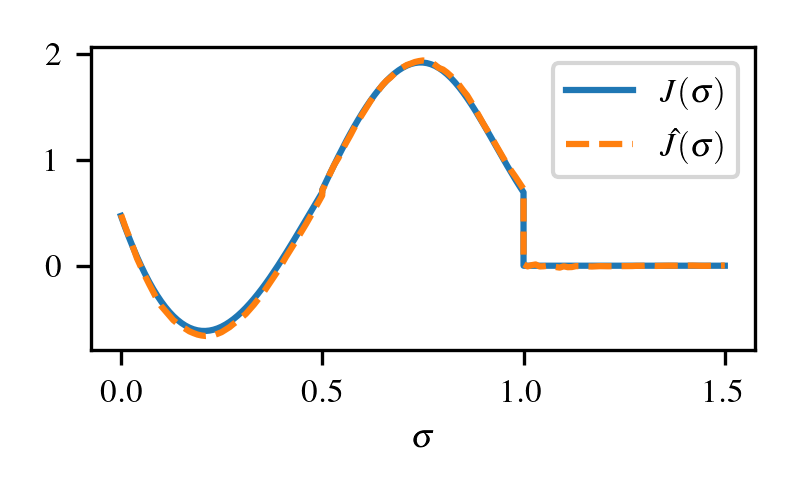

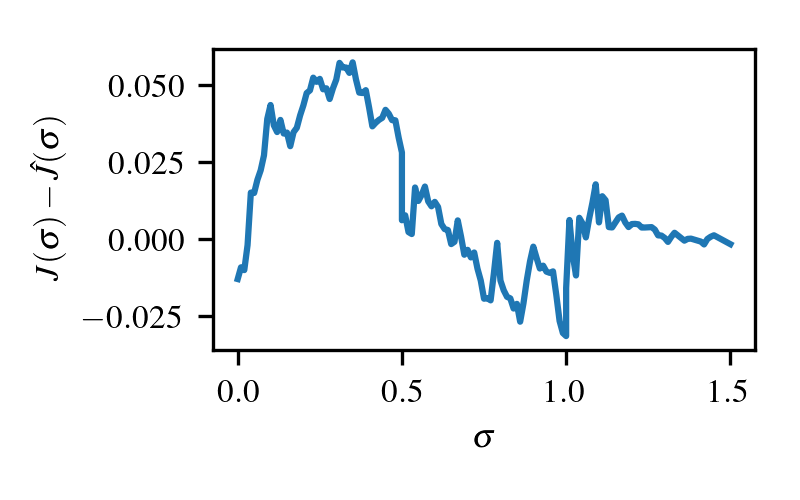

In [53]:
my_dpi=300
JJJ_x=np.concatenate([skr[0,:],skr[25,:],skr[50,:]])
JJJ_y=np.concatenate([J[0,:],J[25,:],J[50,:]])
JJJ_learning_y=np.concatenate([k3[0,:],k3[25,:],k3[50,:]])
fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(JJJ_x, JJJ_y,linewidth=1.5,label=r'$J(\sigma)$') 
plt.plot(JJJ_x, JJJ_learning_y,linewidth=1.5,linestyle='--',label=r'$\hat J(\sigma)$') 
plt.legend(loc="upper right",fontsize="8")
# plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$\rm{\sigma}$',fontsize="8")
# plt.ylabel(r'$J(s,t) $',fontsize="8")
# plt.yticks(np.arange(0,0.1,0.025))
plt.tick_params(labelsize=8)




fig = plt.gcf()
fig.tight_layout()
plt.savefig('img/J_sigma.eps', dpi=300,bbox_inches='tight')

fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(JJJ_x, JJJ_y- JJJ_learning_y,linewidth=1.5,label=r'$J(\sigma)-\hat J(\sigma)$')  
# plt.legend(loc="upper right",fontsize="8")
# plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$\rm{\sigma}$',fontsize="8")
plt.ylabel(r'$J(\sigma)-\hat J(\sigma) $',fontsize="8")
# plt.yticks(np.arange(0,0.1,0.025))
plt.tick_params(labelsize=8)

fig = plt.gcf()
fig.tight_layout()
plt.savefig('img/J_error_sigma.eps', dpi=300,bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


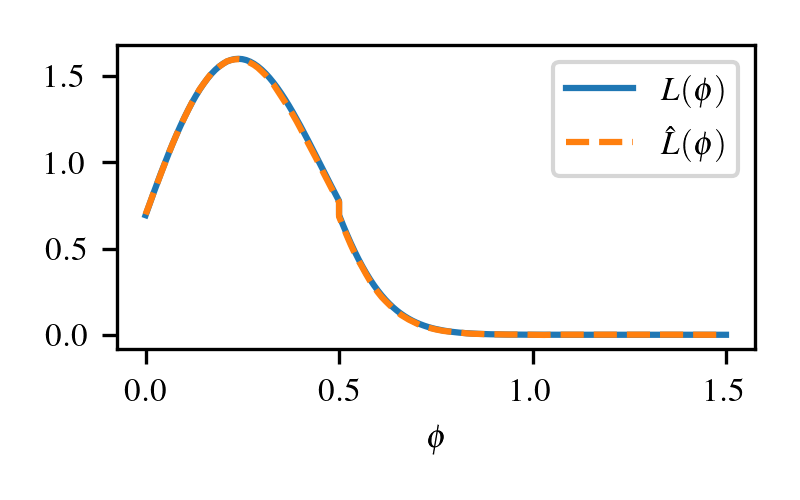

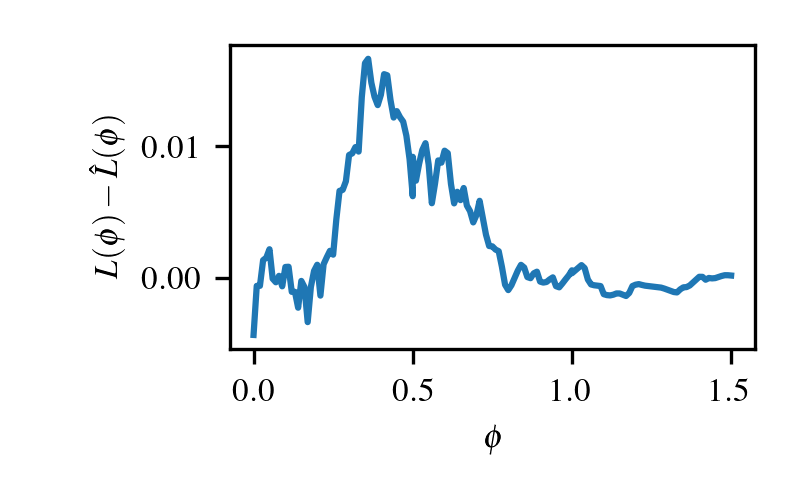

In [54]:
my_dpi=300
LLL_x=np.concatenate([shr[0,:],shr[25,:],shr[50,:]])
LLL_y=np.concatenate([L[0,:],L[25,:],L[50,:]])
LLL_learning_y=np.concatenate([k2[0,:],k2[25,:],k2[50,:]])
fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(LLL_x, LLL_y,linewidth=1.5,label=r'$L(\phi)$') 
plt.plot(LLL_x, LLL_learning_y,linewidth=1.5,linestyle='--',  label=r'$\hat L(\phi)$') 
# plt.yticks(np.linspace(-1,30000e-10,9),fontsize=16)
ax = plt.gca()
# ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')

# plt.yticks(np.arange(0,0.1,0.025))
plt.legend(loc="upper right",fontsize="8")
# plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$\rm{\phi}$',fontsize="8")
# plt.ylabel(r'$J(s,t) $',fontsize="8")
# plt.yticks(np.arange(0,0.1,0.025))
plt.tick_params(labelsize=8)


fig = plt.gcf()
fig.tight_layout()
plt.savefig('img/L_sigma.eps', dpi=300,bbox_inches='tight')

fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(LLL_x, LLL_y-LLL_learning_y,linewidth=1.5) 
# plt.legend(loc="upper right",fontsize="8")
# plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$\rm{\phi}$',fontsize="8")
plt.ylabel(r'$L(\phi)-\hat L(\phi) $',fontsize="8")
# plt.yticks(np.arange(0,0.1,0.025))
plt.tick_params(labelsize=8)

fig = plt.gcf()
fig.tight_layout()
plt.savefig('img/L_error_sigma.eps', dpi=300,bbox_inches='tight')

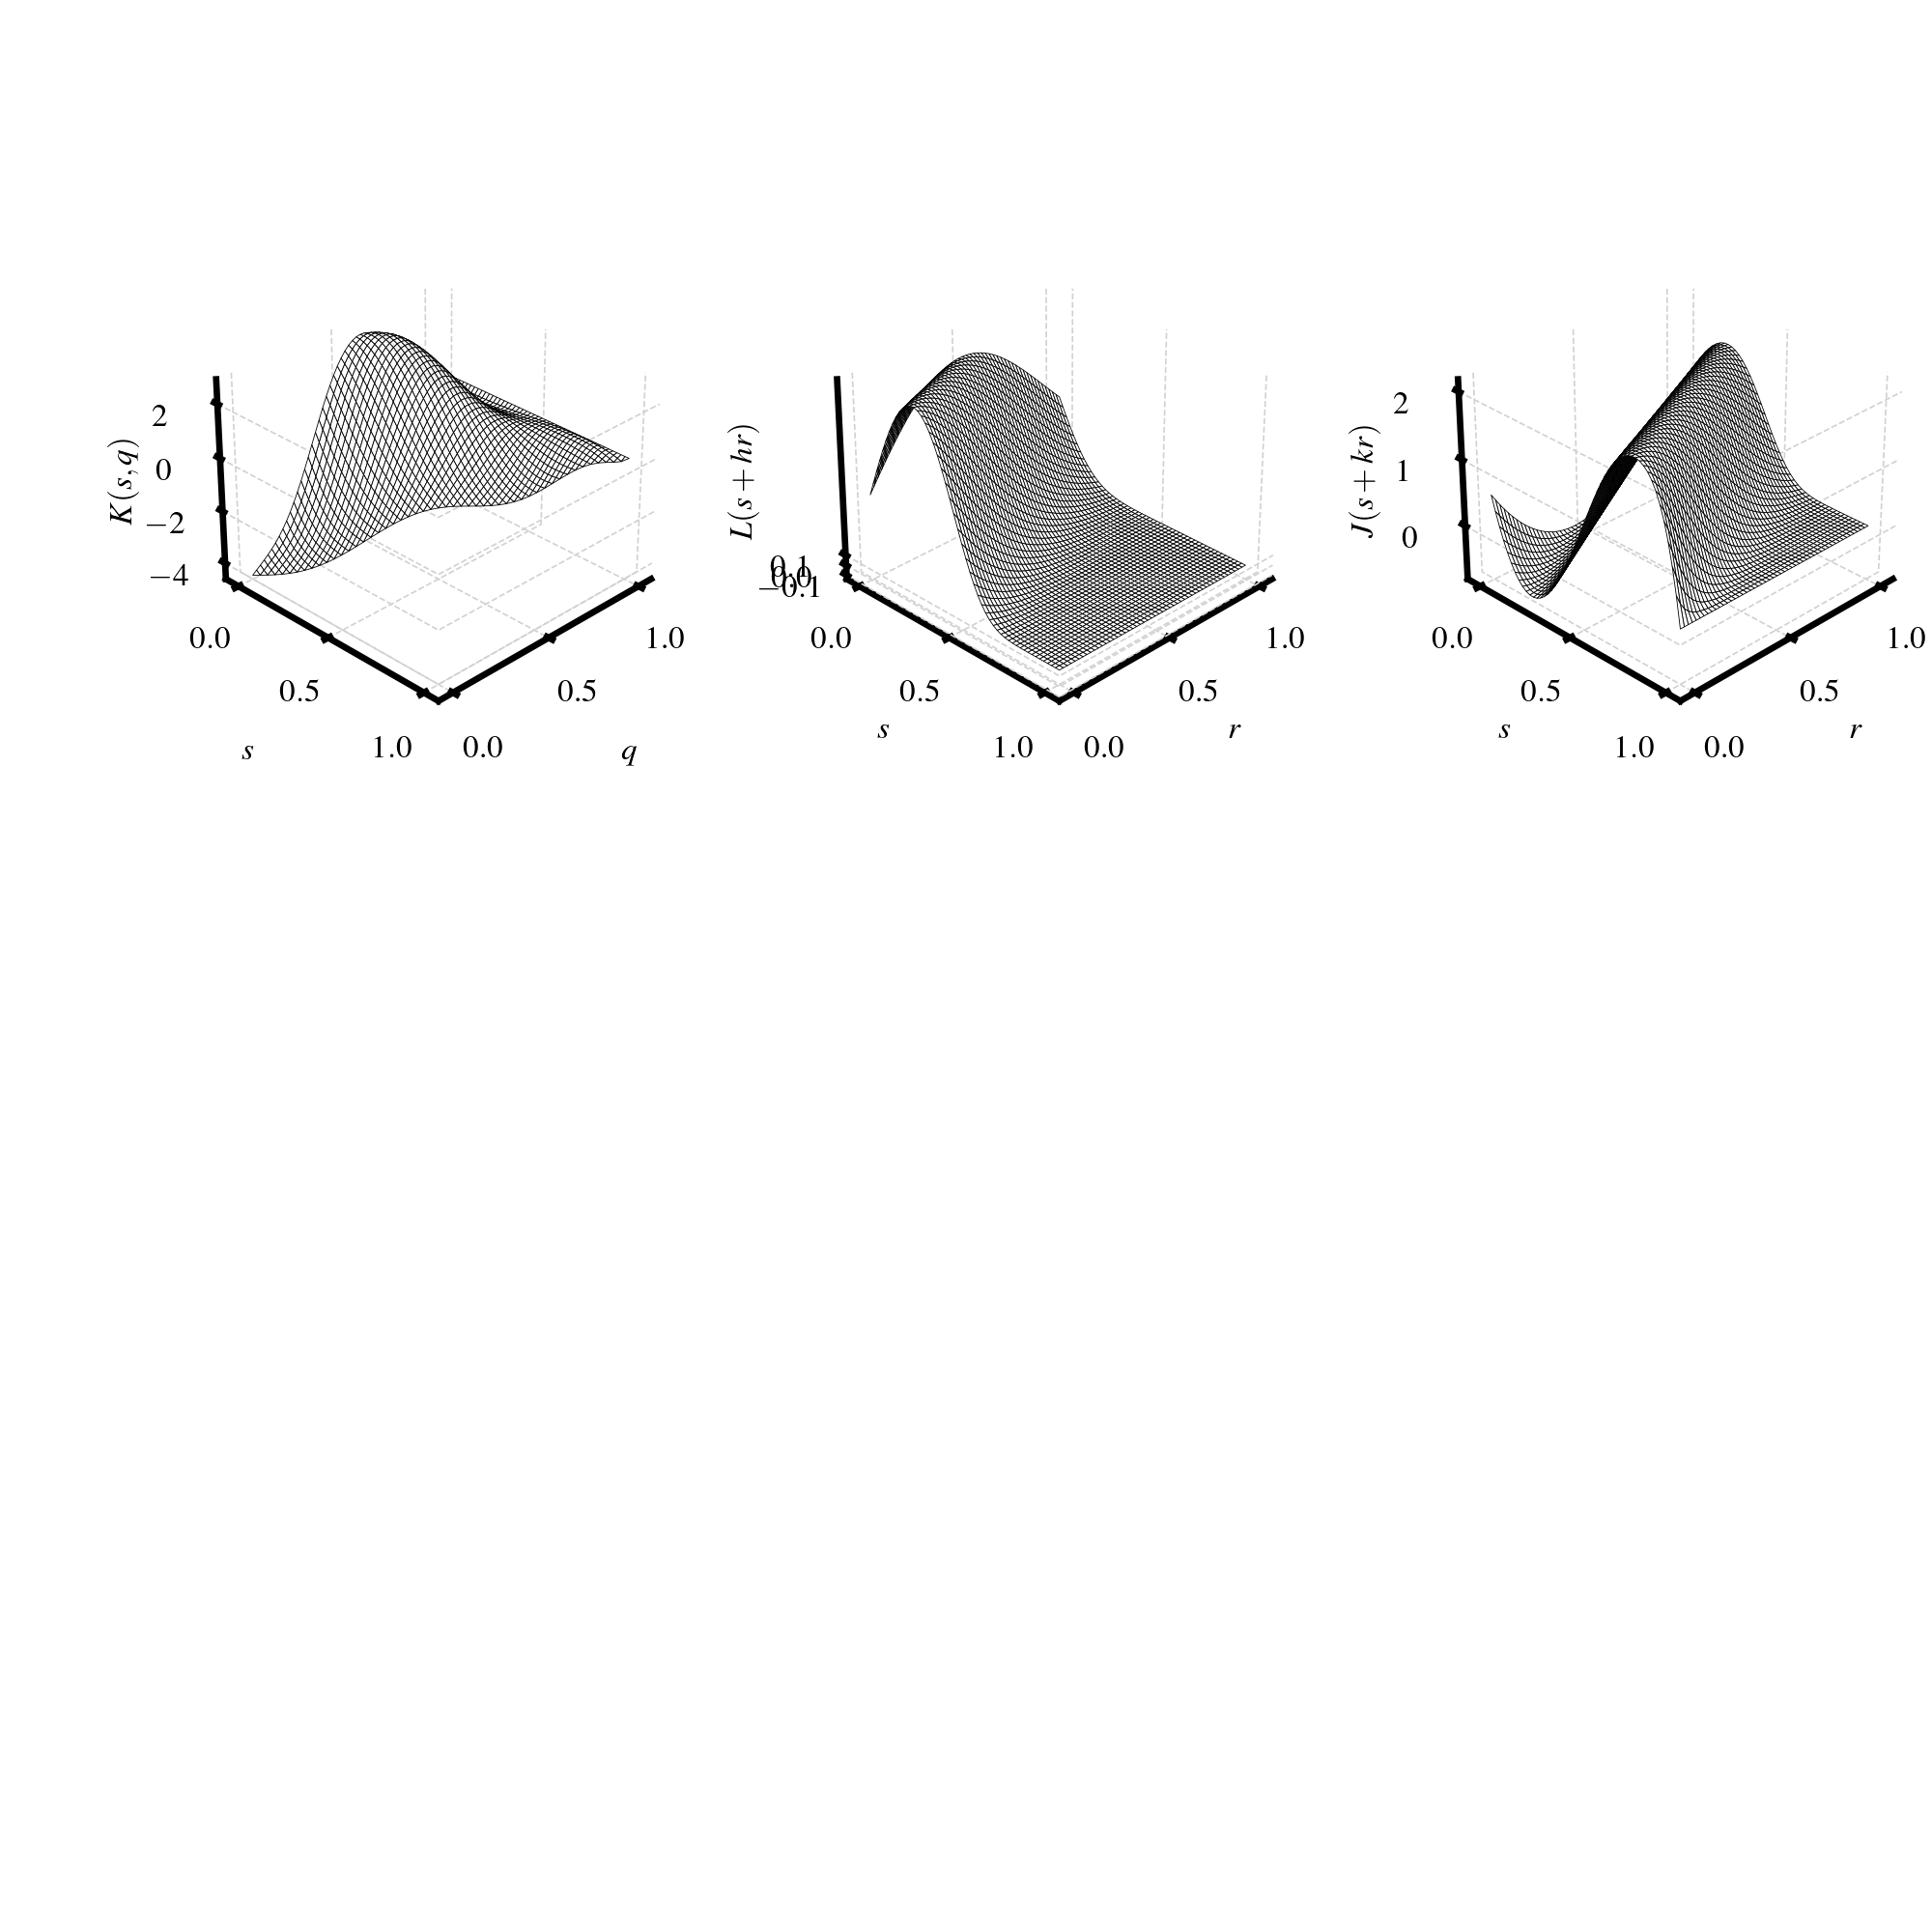

In [38]:
#############draw K 
res = 10
# fig = plt.figure(figsize=set_size(2000, 0.99, (2, 2), height_add=1))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

fig = plt.figure(figsize=(1000 / my_dpi, 1000 / my_dpi), dpi=600)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.subplots_adjust(left=0.1, bottom=0, right=0.99, top=0.99, wspace=0.3, hspace=0)

# subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
# meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[2].xaxis, ax[2].yaxis, ax[2].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
ax[0].plot_surface(meshx, meshy, zeroToNan(K),edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(30,-45)
ax[0].set_xlabel(r"$s$",fontsize = 4 , labelpad=-10)
ax[0].set_ylabel(r"$q$",fontsize = 4 , labelpad=-10)
ax[0].set_zlabel(r"$K(s,q)$",fontsize = 4 , rotation = 90, labelpad=-14)
ax[0].set_xticks([0, 0.5, 1])
ax[0].set_yticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4 , pad=-4)  # x轴标签旋转、字号等 


ax[1].plot_surface(meshx, meshy, L, edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)

# vals = (u[0:nt:draw_rate,0].transpose())
# ax[1].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=True)
ax[1].view_init(30, -45)
ax[1].set_xlabel(r"$s$",fontsize = 4 , labelpad=-12)
ax[1].set_ylabel(r"$r$",fontsize = 4 , labelpad=-12)
ax[1].set_zlabel(r"$L(s+hr)$", fontsize = 4 ,rotation = 90, labelpad=-14)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
ax[1].set_yticks([0, 0.5, 1])
# ax[1].set_zticks([-2, 0, 2])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4, pad=-4 )  # x轴标签旋转、字号等 


ax[2].plot_surface(meshx, meshy, J,edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
test = np.zeros(int(301))
# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[2].view_init(30,-45)
ax[2].set_xlabel(r"$s$",fontsize = 4 , labelpad=-12)
ax[2].set_ylabel(r"$r$",fontsize = 4 , labelpad=-12)
ax[2].set_zlabel(r"$J(s+kr)$",fontsize = 4 , rotation = 90, labelpad=-14)
ax[2].set_xticks([0, 0.5, 1])
ax[2].set_yticks([0, 0.5, 1])
ax[1].set_zticks([-0.1, 0, 0.1])
ax[2].zaxis.set_rotate_label(False)
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4, pad=-4 )  # x轴标签旋转、字号等 

tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax[1].zaxis._PLANES 
ax[1].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5]) 

tmp_planes = ax[2].zaxis._PLANES 
ax[2].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5]) 


  
##### ERROR L2 PLOT ####
# subfig = subfigs[1]
# subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

# zticks = np.linspace(-50, 50, 5)
# subfig.suptitle(r"PDE Error ($L_2$ Norm over x)")
# ax = subfig.subplots(nrows=1, ncols=2)
# subfig.subplots_adjust(left=0.12, bottom=0.2, right=.97, top=0.85, wspace=0.3, hspace=0.1)
# ax[0].plot(temporal[:-1], getPDEl2(uarr[0], uhatarr[0]))
# ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
# ax[0].set_xlabel("Time", labelpad=10)
# ax[0].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (u[i] - \hat{u}[i])^2*dx}$")
# ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# ax[1].plot(temporal[:-1], getPDEl2(uarr[1], uhatarr[1]))
# ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
# ax[1].set_xlabel("Time", labelpad=10)
# ax[1].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (u[i] - \hat{u}[i])^2*dx}$")
# ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# plt.savefig('img/KLJ.pdf', dpi=300,bbox_inches='tight')

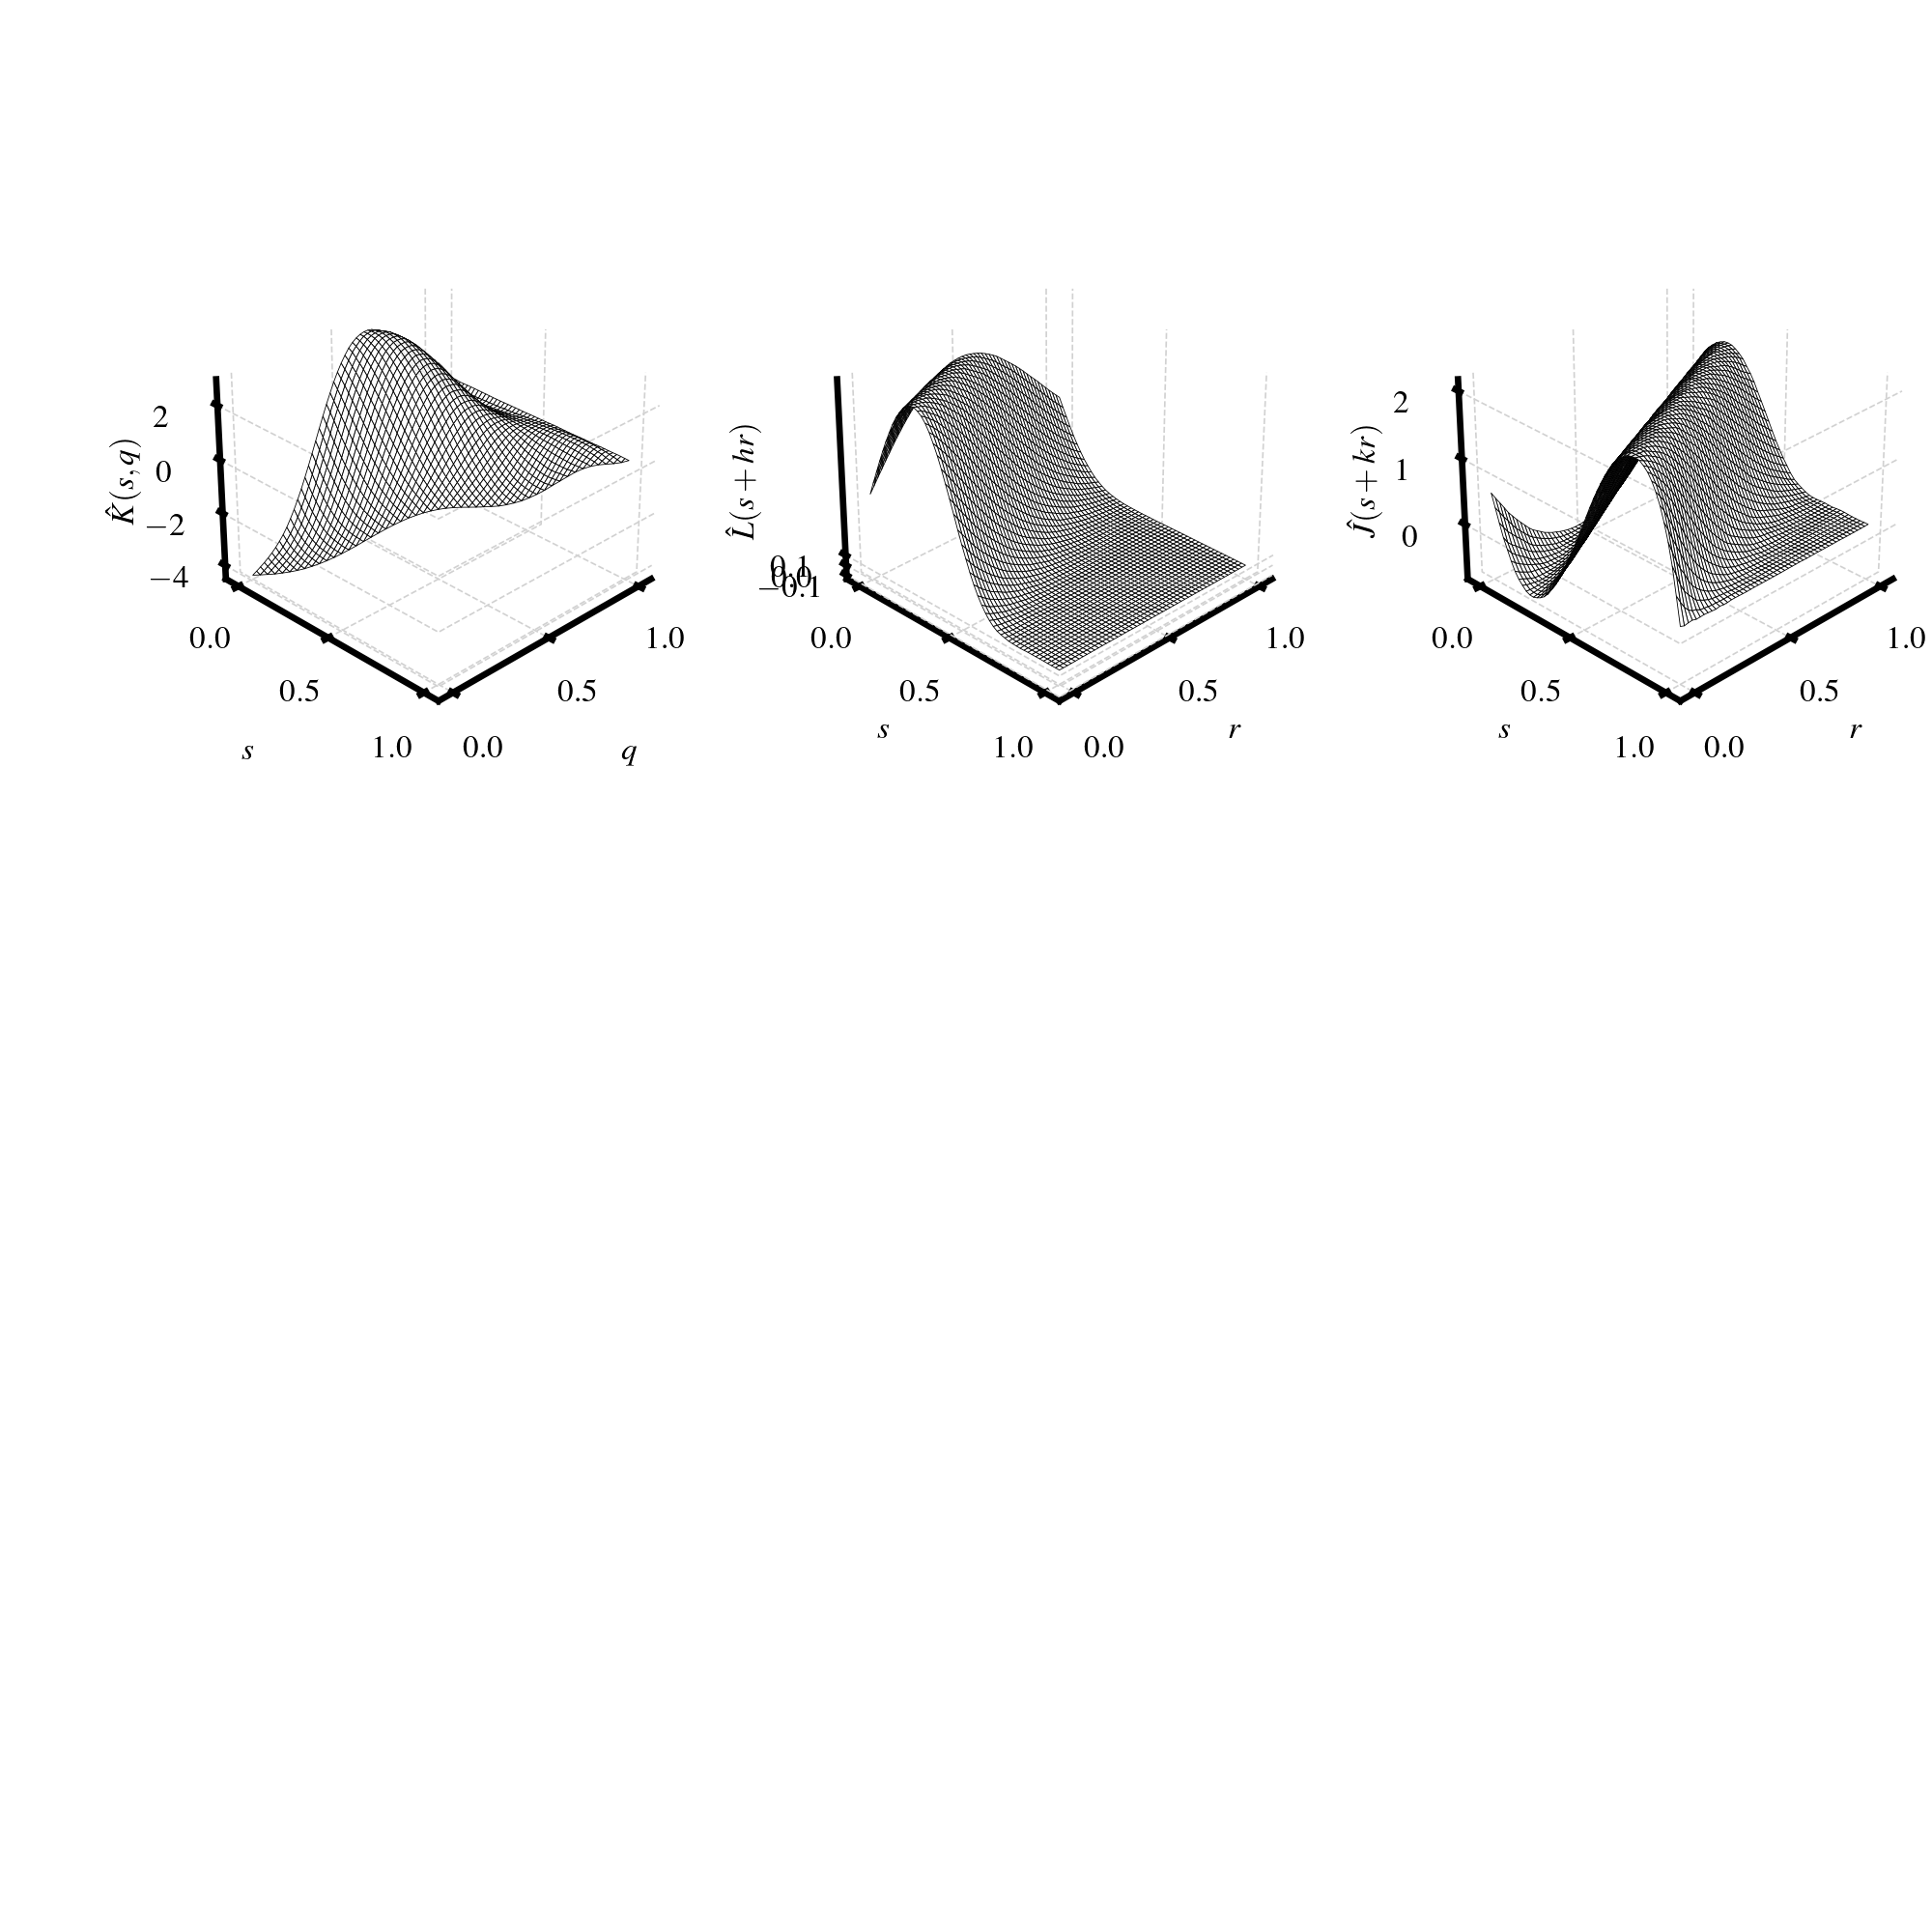

In [39]:
#############draw K 
res = 10
# fig = plt.figure(figsize=set_size(2000, 0.99, (2, 2), height_add=1))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

fig = plt.figure(figsize=(1000 / my_dpi, 1000 / my_dpi), dpi=600)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.subplots_adjust(left=0.1, bottom=0, right=0.99, top=0.99, wspace=0.3, hspace=0)

# subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
# meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[2].xaxis, ax[2].yaxis, ax[2].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
ax[0].plot_surface(meshx, meshy, zeroToNan(k1),edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(30,-45)
ax[0].set_xlabel(r"$s$",fontsize = 4 , labelpad=-10)
ax[0].set_ylabel(r"$q$",fontsize = 4 , labelpad=-10)
ax[0].set_zlabel(r"$\hat K(s,q)$",fontsize = 4 , rotation = 90, labelpad=-14)
ax[0].set_xticks([0, 0.5, 1])
ax[0].set_yticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4 , pad=-4)  # x轴标签旋转、字号等 


ax[1].plot_surface(meshx, meshy, k2, edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)

# vals = (u[0:nt:draw_rate,0].transpose())
# ax[1].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=True)
ax[1].view_init(30, -45)
ax[1].set_xlabel(r"$s$",fontsize = 4 , labelpad=-12)
ax[1].set_ylabel(r"$r$",fontsize = 4 , labelpad=-12)
ax[1].set_zlabel(r"$\hat L(s+hr)$", fontsize = 4 ,rotation = 90, labelpad=-14)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
ax[1].set_yticks([0, 0.5, 1])
# ax[1].set_zticks([-2, 0, 2])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4, pad=-4 )  # x轴标签旋转、字号等 


ax[2].plot_surface(meshx, meshy, k3,edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
test = np.zeros(int(301))
# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[2].view_init(30,-45)
ax[2].set_xlabel(r"$s$",fontsize = 4 , labelpad=-12)
ax[2].set_ylabel(r"$r$",fontsize = 4 , labelpad=-12)
ax[2].set_zlabel(r"$\hat J(s+kr)$",fontsize = 4 , rotation = 90, labelpad=-14)
ax[2].set_xticks([0, 0.5, 1])
ax[2].set_yticks([0, 0.5, 1])
ax[1].set_zticks([-0.1, 0, 0.1])
ax[2].zaxis.set_rotate_label(False)
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4, pad=-4 )  # x轴标签旋转、字号等 

tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax[1].zaxis._PLANES 
ax[1].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5]) 

tmp_planes = ax[2].zaxis._PLANES 
ax[2].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5]) 


  
##### ERROR L2 PLOT ####
# subfig = subfigs[1]
# subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

# zticks = np.linspace(-50, 50, 5)
# subfig.suptitle(r"PDE Error ($L_2$ Norm over x)")
# ax = subfig.subplots(nrows=1, ncols=2)
# subfig.subplots_adjust(left=0.12, bottom=0.2, right=.97, top=0.85, wspace=0.3, hspace=0.1)
# ax[0].plot(temporal[:-1], getPDEl2(uarr[0], uhatarr[0]))
# ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
# ax[0].set_xlabel("Time", labelpad=10)
# ax[0].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (u[i] - \hat{u}[i])^2*dx}$")
# ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# ax[1].plot(temporal[:-1], getPDEl2(uarr[1], uhatarr[1]))
# ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
# ax[1].set_xlabel("Time", labelpad=10)
# ax[1].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (u[i] - \hat{u}[i])^2*dx}$")
# ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# plt.savefig('img/KLJ_learning.pdf', dpi=300,bbox_inches='tight')

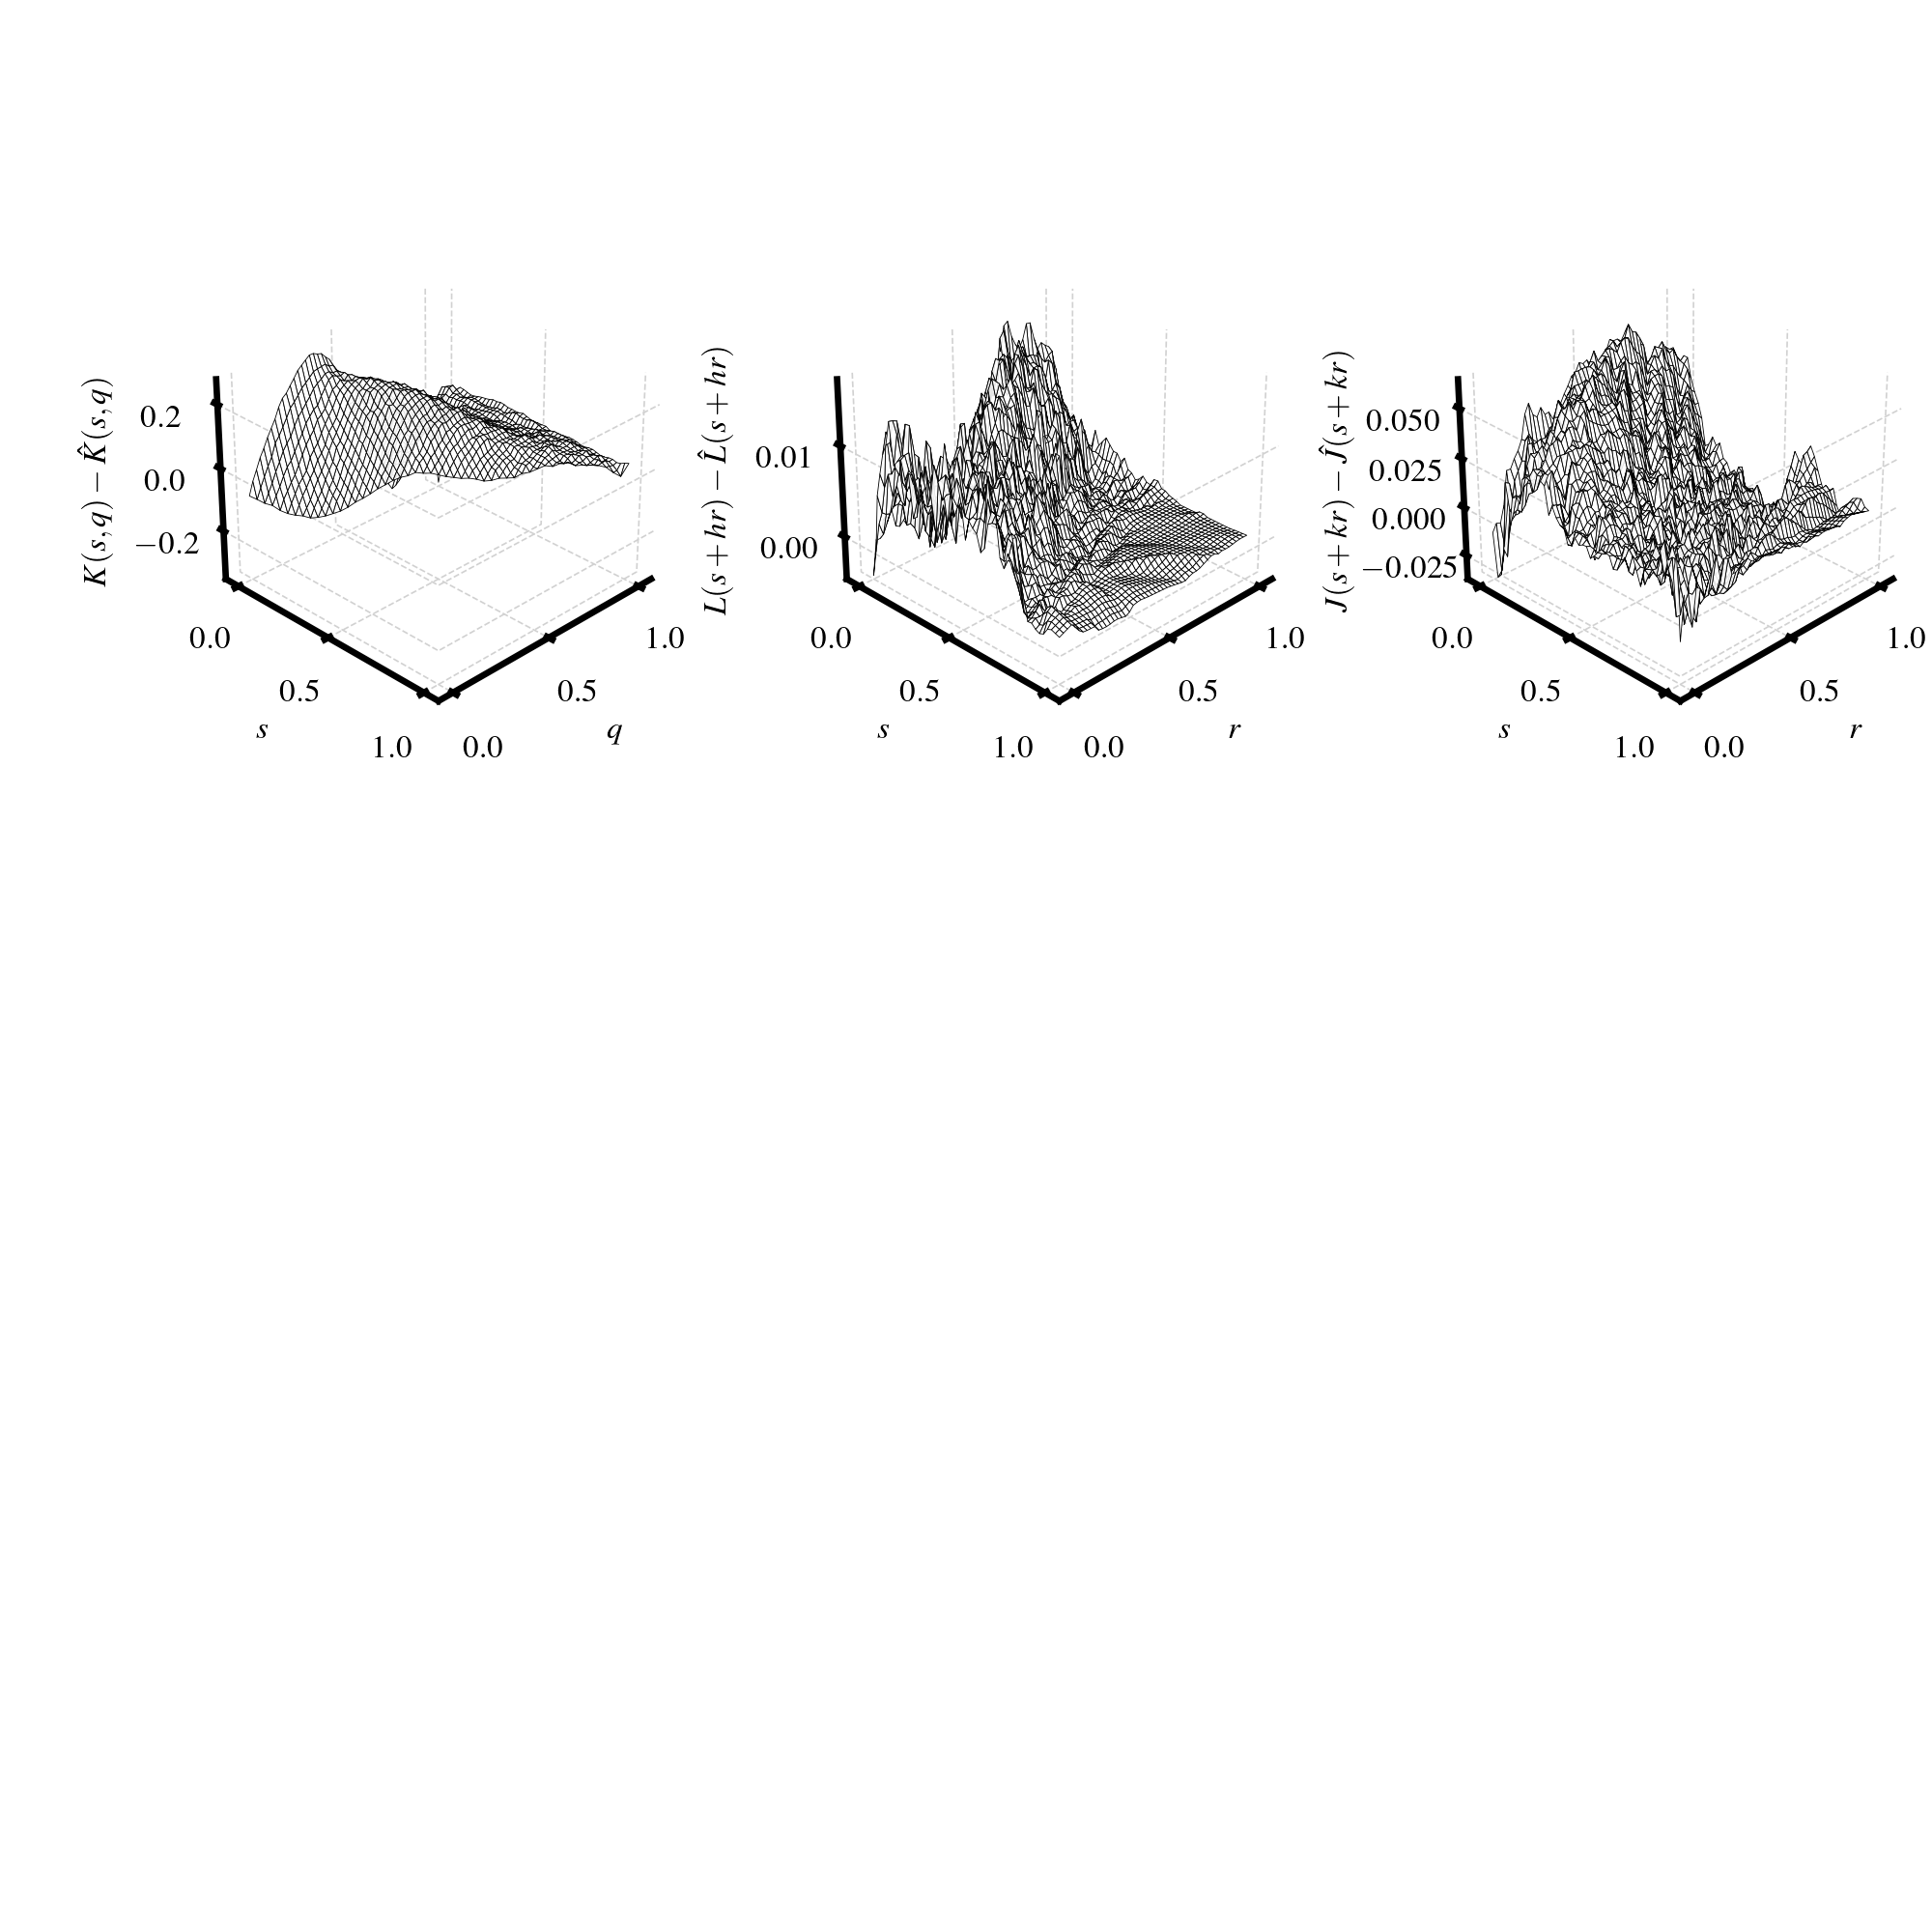

In [41]:
#############draw K 
res = 10
# fig = plt.figure(figsize=set_size(2000, 0.99, (2, 2), height_add=1))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

fig = plt.figure(figsize=(1000 / my_dpi, 1000 / my_dpi), dpi=600)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.subplots_adjust(left=0.1, bottom=0, right=0.99, top=0.99, wspace=0.3, hspace=0)

# subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
# meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[2].xaxis, ax[2].yaxis, ax[2].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
ax[0].plot_surface(meshx, meshy, zeroToNan(K-k1),edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(30,-45)
ax[0].set_xlabel(r"$s$",fontsize = 4 , labelpad=-12)
ax[0].set_ylabel(r"$q$",fontsize = 4 , labelpad=-12)
ax[0].set_zlabel(r"$K(s,q)-\hat K(s,q)$",fontsize = 4 , rotation = 90, labelpad=-12)
ax[0].set_xticks([0, 0.5, 1])
ax[0].set_yticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4 , pad=-4)  # x轴标签旋转、字号等 


ax[1].plot_surface(meshx, meshy, L-k2, edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)

# vals = (u[0:nt:draw_rate,0].transpose())
# ax[1].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=True)
ax[1].view_init(30, -45)
ax[1].set_xlabel(r"$s$",fontsize = 4 , labelpad=-12)
ax[1].set_ylabel(r"$r$",fontsize = 4 , labelpad=-12)
ax[1].set_zlabel(r"$ L(s+hr)-\hat L(s+hr)$", fontsize = 4 ,rotation = 90, labelpad=-12)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
ax[1].set_yticks([0, 0.5, 1])
# ax[1].set_zticks([-2, 0, 2])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4, pad=-4 )  # x轴标签旋转、字号等 


ax[2].plot_surface(meshx, meshy, J-k3,edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
test = np.zeros(int(301))
# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[2].view_init(30,-45)
ax[2].set_xlabel(r"$s$",fontsize = 4 , labelpad=-12)
ax[2].set_ylabel(r"$r$",fontsize = 4 , labelpad=-12)
ax[2].set_zlabel(r"$J(s+kr)-\hat J(s+kr)$",fontsize = 4 , rotation = 90, labelpad=-12)
ax[2].set_xticks([0, 0.5, 1])
ax[2].set_yticks([0, 0.5, 1])
# ax[1].set_zticks([-0.001, 0, 0.001])
ax[2].zaxis.set_rotate_label(False)
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4, pad=-4 )  # x轴标签旋转、字号等 

tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax[1].zaxis._PLANES 
ax[1].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5]) 

tmp_planes = ax[2].zaxis._PLANES 
ax[2].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5]) 


  
##### ERROR L2 PLOT ####
# subfig = subfigs[1]
# subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

# zticks = np.linspace(-50, 50, 5)
# subfig.suptitle(r"PDE Error ($L_2$ Norm over x)")
# ax = subfig.subplots(nrows=1, ncols=2)
# subfig.subplots_adjust(left=0.12, bottom=0.2, right=.97, top=0.85, wspace=0.3, hspace=0.1)
# ax[0].plot(temporal[:-1], getPDEl2(uarr[0], uhatarr[0]))
# ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
# ax[0].set_xlabel("Time", labelpad=10)
# ax[0].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (u[i] - \hat{u}[i])^2*dx}$")
# ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# ax[1].plot(temporal[:-1], getPDEl2(uarr[1], uhatarr[1]))
# ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
# ax[1].set_xlabel("Time", labelpad=10)
# ax[1].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (u[i] - \hat{u}[i])^2*dx}$")
# ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# plt.savefig('img/KLJ_error.pdf', dpi=300,bbox_inches='tight')

In [25]:
Kbud=K[0,0:nx]
Lbud=L[0,0:nx]
Jbud=J[0,0:nx]

In [26]:
Klearningbud=k1[0,0:nx]
Llearningbud=k2[0,0:nx]
Jlearningbud=k3[0,0:nx]
Q1learning=Q1learning[0,0:nx]
Q2learning=Q2learning[0,0:nx] 

In [34]:
init_cond11 = np.sin(2*np.pi*spatial)
init_cond1 =np.zeros((1,nx))
init_cond1[0,0:nx]=init_cond11[0:nx]
init_cond2 = np.zeros((1,nx))
init_cond= np.concatenate((init_cond1,init_cond2,init_cond2),axis=1)

In [160]:
uu=solvePDE(tau, tau_obs, c, f, Kbud, Lbud, Jbud, init_cond, spatial, temporal, printFreq=500)
uulearning=solvePDE(tau, tau_obs, c, f, Klearningbud, Llearningbud, Jlearningbud, init_cond, spatial, temporal, printFreq=500)

Completed: 500 / 501
Completed: 500 / 501


In [162]:
init_condition_obs= init_cond+ 2*(np.random.rand(3*nx)-1)

In [35]:
init_condition_obs=10*np.ones(3*nx)

In [36]:
temporal_obs=temporal[0:5000]

In [38]:
uu_withoutctrl,uu_withoutctrl_est=solvePDEwithObse_withoutctrl(tau, tau_obs,  c, f, Kbud_open, Lbud_open, Jbud_open,  Q1, Q2, init_cond, init_condition_obs, spatial, temporal_obs, printFreq=500)

Solving PDE... Timesteps Needed: 5000
Completed: 500 / 5000
Completed: 1000 / 5000
Completed: 1500 / 5000
Completed: 2000 / 5000
Completed: 2500 / 5000
Completed: 3000 / 5000
Completed: 3500 / 5000
Completed: 4000 / 5000
Completed: 4500 / 5000


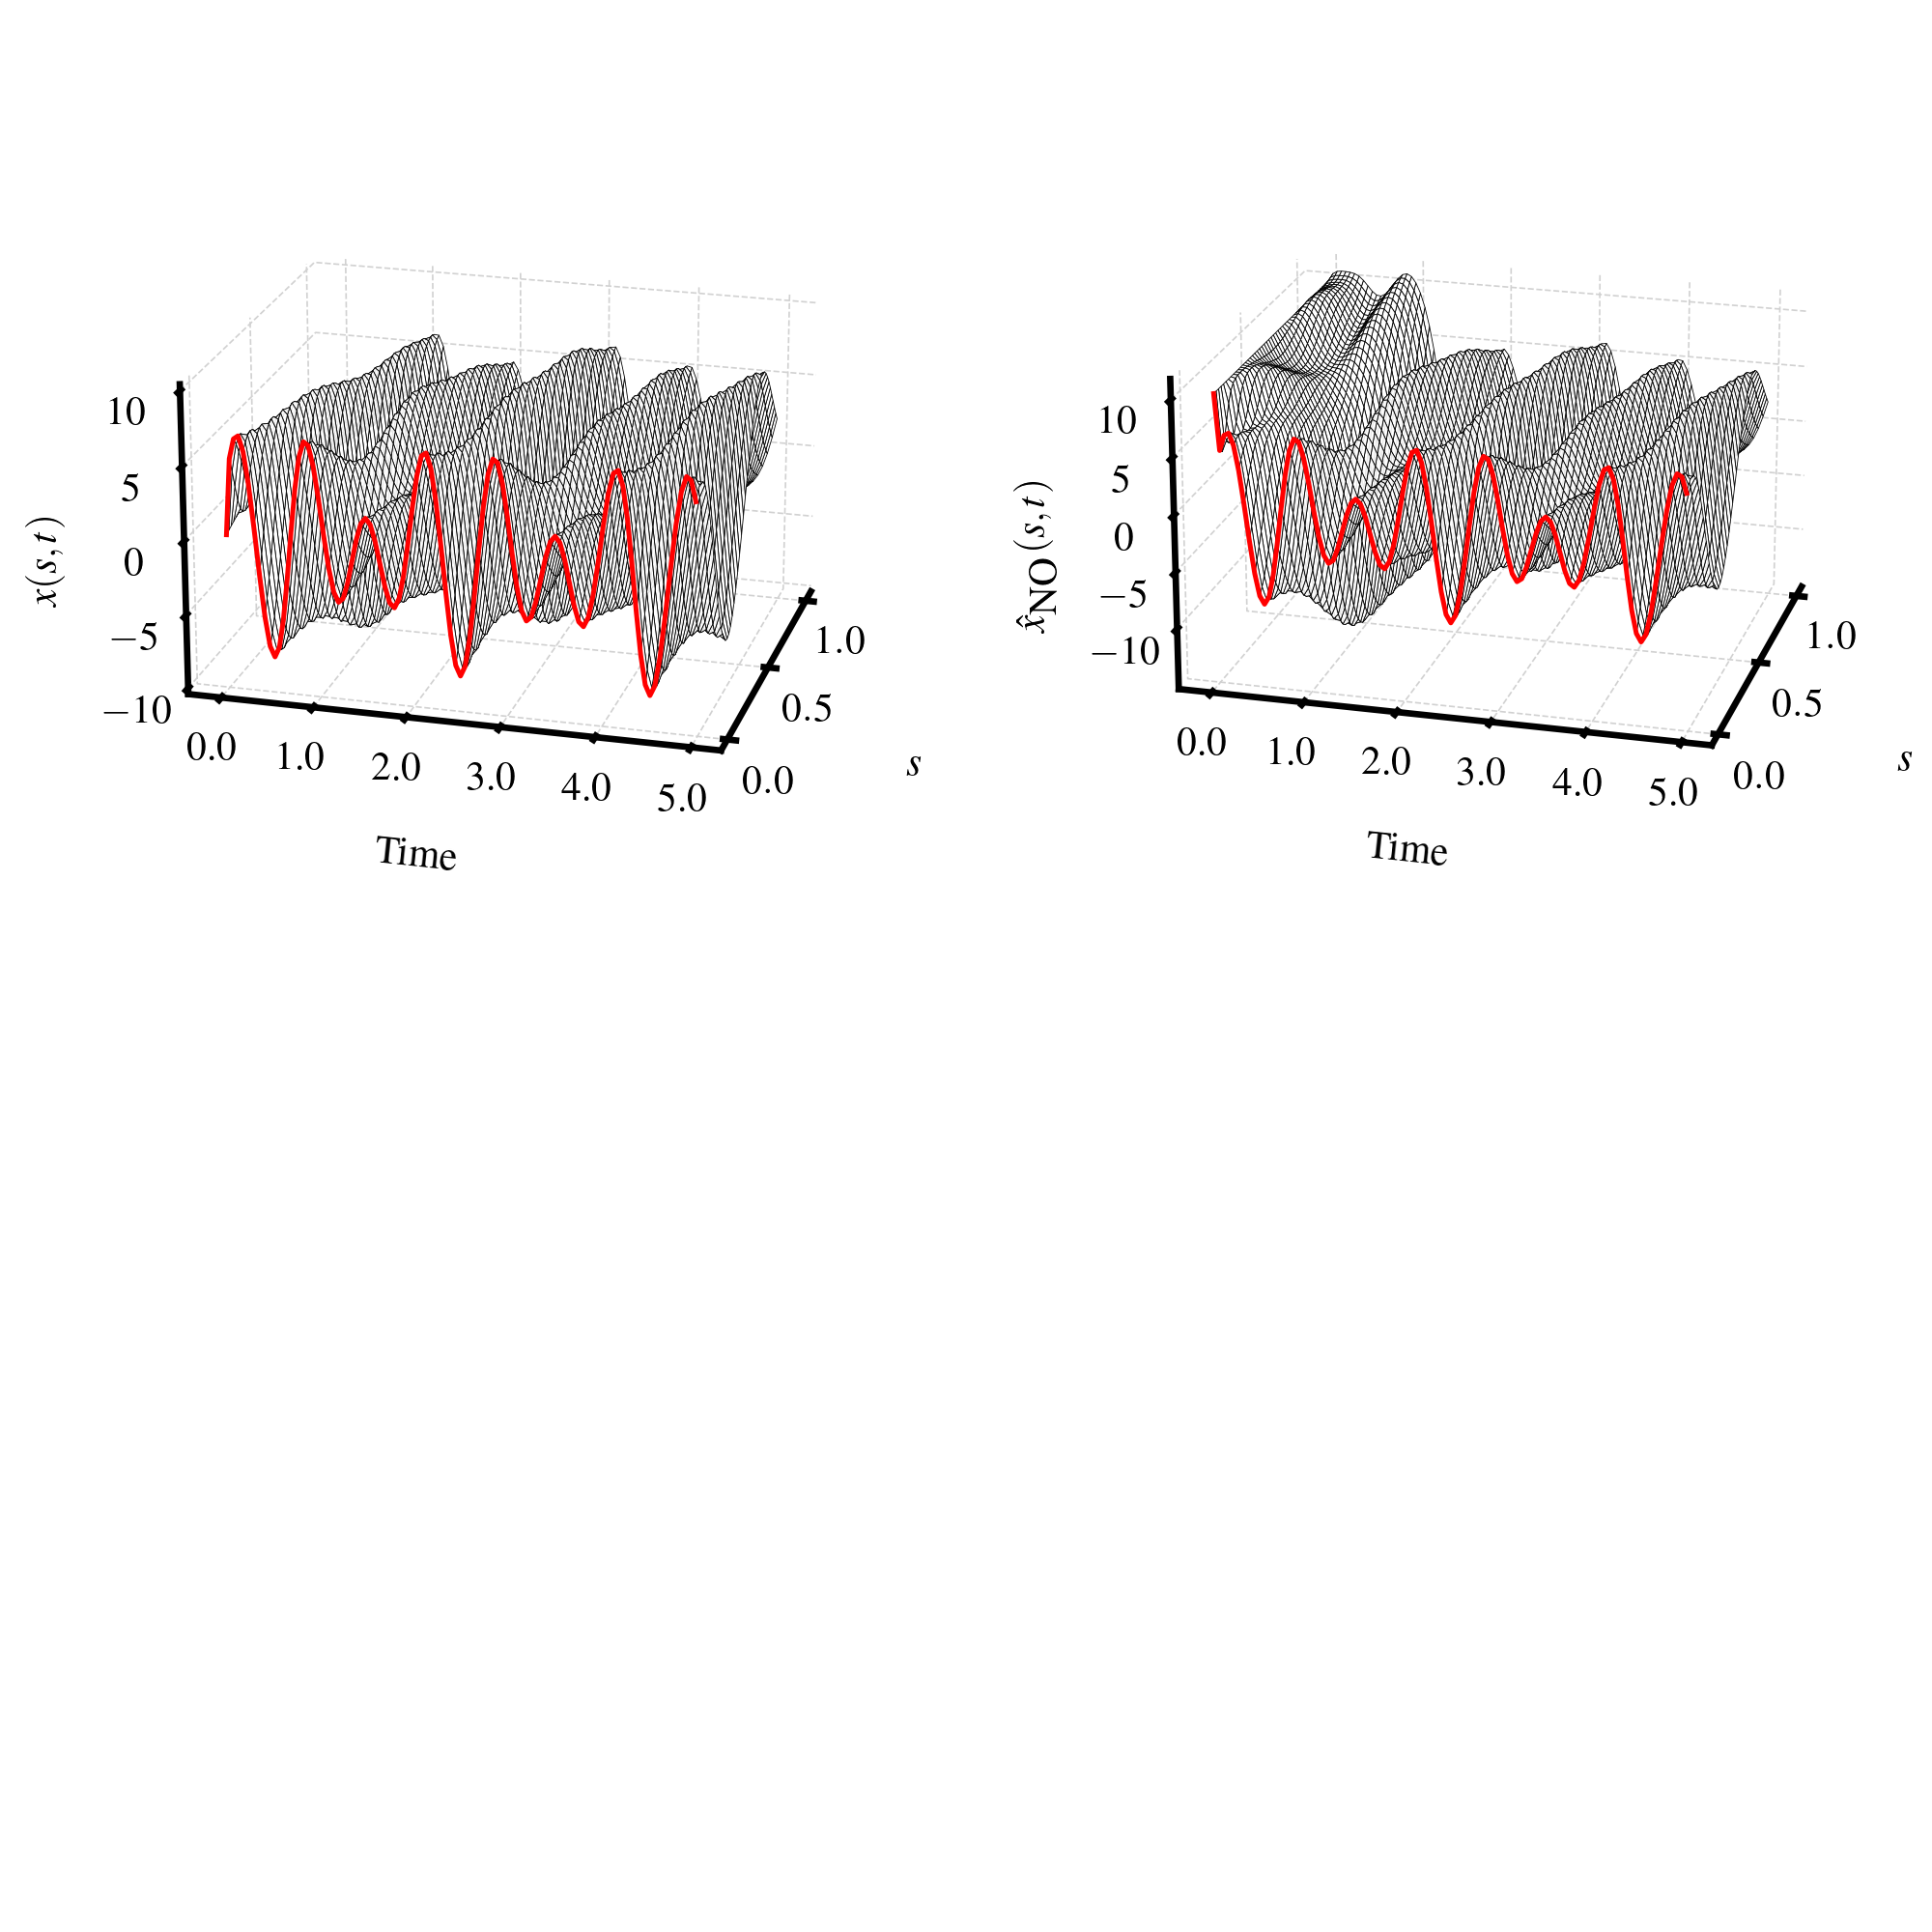

In [45]:
############### draw output
nt_obs=5000
# res = 10
draw_rate = 50
temporal_draw_obs=temporal[0:nt_obs:draw_rate]
meshx2_obs, mesht2_obs = np.meshgrid(spatial, temporal_draw_obs)
test=np.zeros(len(temporal_draw_obs))
# fig = plt.figure(figsize=set_size(2000, 0.99, (2, 2), height_add=1))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

fig = plt.figure(figsize=(1000 / my_dpi, 1000 / my_dpi), dpi=600)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)
ax[0]=Axes3D(fig)
ax[1]=Axes3D(fig)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.05, bottom=0, right=0.99, top=0.99, wspace=0.2, hspace=0)

# subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
# meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
# ax[0].plot_surface(meshx, meshy, zeroToNan(kappa1)-zeroToNan(k1),edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
ax[0].plot_surface(meshx2_obs, mesht2_obs, uu_withoutctrl[0:nt_obs:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax.plot_surface(meshx2, mesht2, ulearning_est[0:nt:draw_rate,:],  
#                         cmap = cm.coolwarm, shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
ax[0].plot(test, temporal_draw_obs, uu_withoutctrl[0:nt_obs:draw_rate,0], color="red", lw=0.6, antialiased=True)

ax[0].invert_xaxis()
ax[0].get_proj = lambda: np.dot(Axes3D.get_proj(ax[0]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例

# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(20,15)
ax[0].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[0].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[0].set_zlabel(r"$x(s,t)$",fontsize = 5 , rotation = 90, labelpad=-10)
ax[0].set_xticks([0, 0.5, 1])
# ax[0].set_yticks([0, 10, 20, 30, 40, 50])
ax[0].set_zticks([-10, -5 , 0, 5, 10])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5 , pad=-4)  # x轴标签旋转、字号等 

ax[1].plot_surface(meshx2_obs, mesht2_obs, uu_withoutctrl_est[0:nt_obs:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax[1].plot_surface(meshx, meshy, kappa2-k2,edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
ax[1].plot(test, temporal_draw_obs, uu_withoutctrl_est[0:nt_obs:draw_rate,0], color="red", lw=0.6, antialiased=True)
ax[1].invert_xaxis()
 
ax[1].get_proj = lambda: np.dot(Axes3D.get_proj(ax[1]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例
# vals = (u[0:nt:draw_rate,0].transpose())
# ax[1].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=True)
ax[1].view_init(20, 15)
ax[1].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[1].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[1].set_zlabel(r"$\hat x_{\rm{NO}}(s,t)$", fontsize = 5 ,rotation = 90, labelpad=-10)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
# ax[1].set_yticks([0, 25, 50])
# ax[1].set_yticks(np.arange(0,60,10))

ax[1].set_zticks([-10, -5 , 0, 5, 10])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax[1].zaxis._PLANES
ax[1].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5]) 
ax[1].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5, pad=-4 )  # x轴标签旋转、字号等 
plt.savefig('img/system_observer.pdf', dpi=300,bbox_inches='tight')

In [115]:
Kbud_open=np.zeros(nx)
Lbud_open=np.zeros(nx)
Jbud_open=np.zeros(nx)

In [128]:
# K_uncom,L_uncom,J_uncom=fastKernelCalc(f, c, 0, 0, spatial, cof_int_x_1, cof_int_0_x)
# Kbud_uncom=K_uncom[0,0:nx]
# F1_uncom, F23_uncom, Q1_uncom, Q2_uncom = fastObserverGainCalc(f, 0.01, 1, spatial, cof_int_x_1)

In [129]:
# uu_output_uncom,uu_output_uncom_est=solvePDEwithObse(tau, tau_obs,  c, f, Kbud_uncom, Lbud_open, Jbud_open,  Q1_uncom, Q2_uncom, init_cond, init_condition_obs, spatial, temporal, printFreq=500)

Solving PDE... Timesteps Needed: 10001
Completed: 500 / 10001
Completed: 1000 / 10001
Completed: 1500 / 10001
Completed: 2000 / 10001
Completed: 2500 / 10001
Completed: 3000 / 10001
Completed: 3500 / 10001
Completed: 4000 / 10001
Completed: 4500 / 10001
Completed: 5000 / 10001
Completed: 5500 / 10001
Completed: 6000 / 10001
Completed: 6500 / 10001
Completed: 7000 / 10001
Completed: 7500 / 10001
Completed: 8000 / 10001
Completed: 8500 / 10001
Completed: 9000 / 10001
Completed: 9500 / 10001
Completed: 10000 / 10001


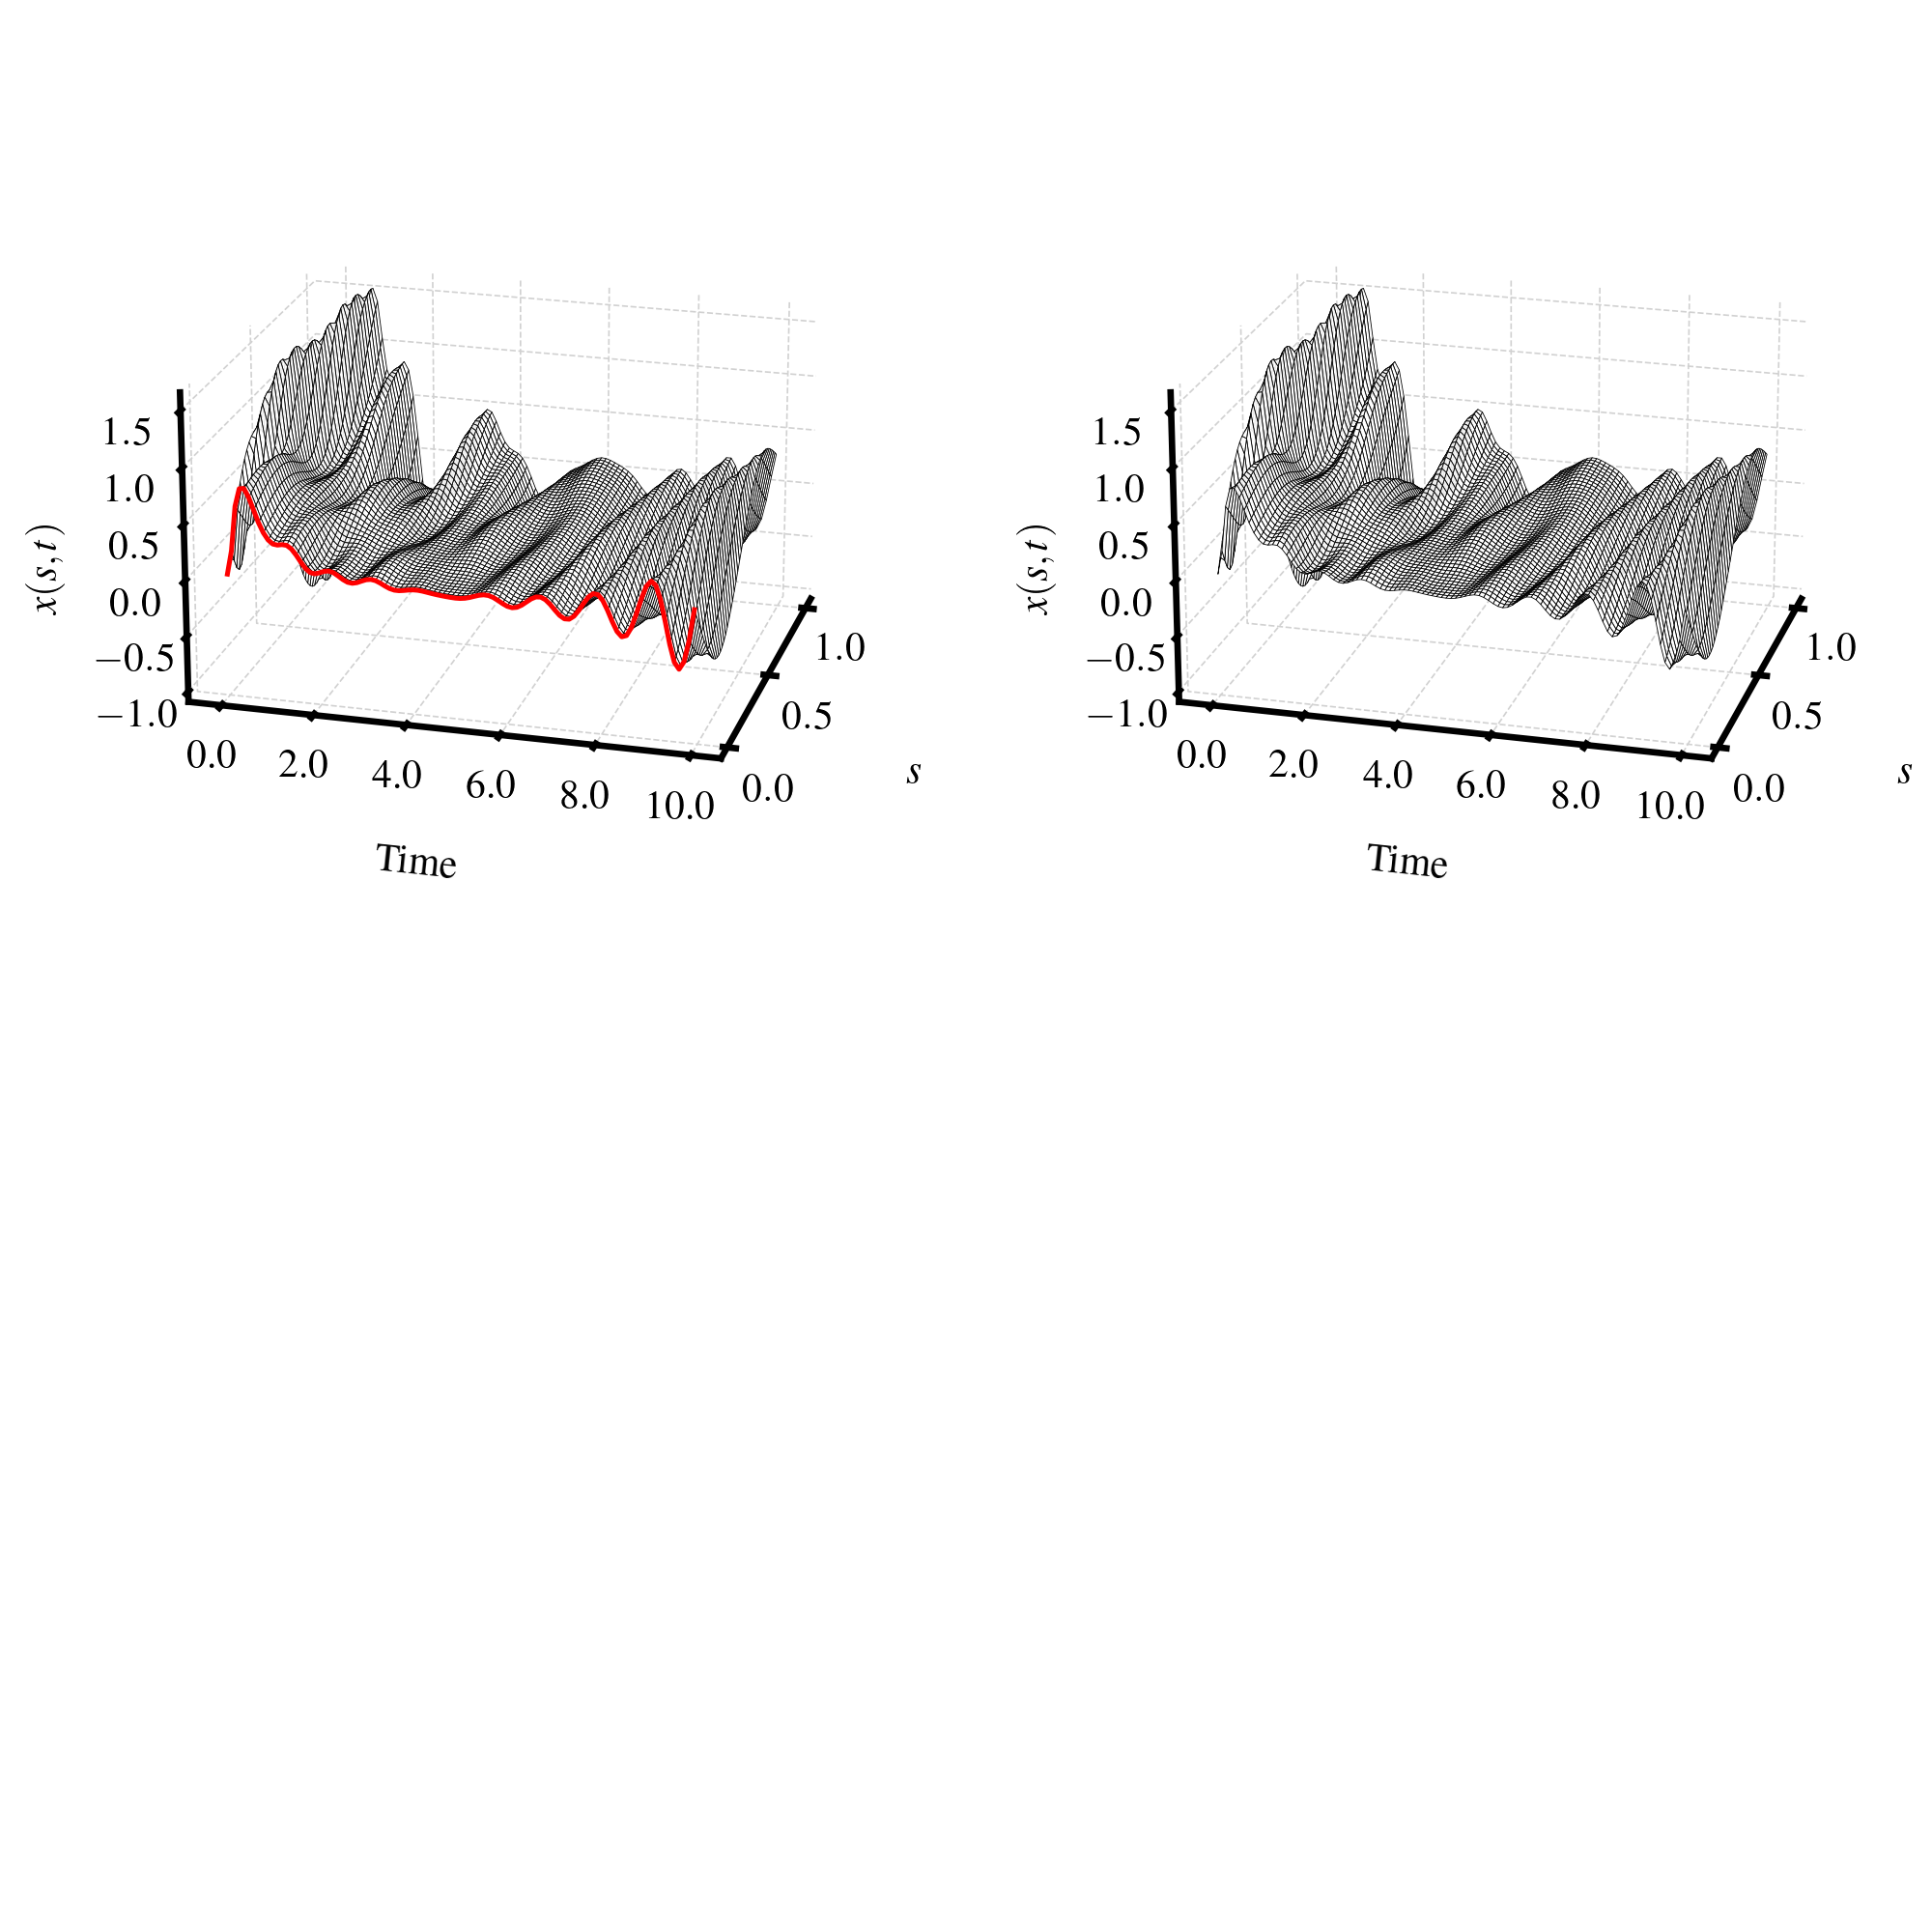

In [32]:
############### draw output

# res = 10
draw_rate = 100
temporal_draw_uncom=temporal[0:10000:draw_rate]
meshxuncom, meshtuncom = np.meshgrid(spatial, temporal_draw_uncom)
test=np.zeros(len(temporal_draw_uncom))
# fig = plt.figure(figsize=set_size(2000, 0.99, (2, 2), height_add=1))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
ax[0]=Axes3D(fig)
ax[1]=Axes3D(fig)
fig = plt.figure(figsize=(1000 / my_dpi, 1000 / my_dpi), dpi=600)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.subplots_adjust(left=0.05, bottom=0, right=0.99, top=0.99, wspace=0.2, hspace=0)

# subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
# meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
# ax[0].plot_surface(meshx, meshy, zeroToNan(kappa1)-zeroToNan(k1),edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
ax[0].plot_surface(meshxuncom, meshtuncom, uu_output_uncom[0:10000:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax.plot_surface(meshx2, mesht2, ulearning_est[0:nt:draw_rate,:],  
#                         cmap = cm.coolwarm, shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# test = np.zeros(int(301))
ax[0].plot(test, temporal_draw_uncom, uu_output_uncom[0:10000:draw_rate,0], color="red", lw=0.6, antialiased=True)

ax[0].invert_xaxis()
ax[0].get_proj = lambda: np.dot(Axes3D.get_proj(ax[0]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例

# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(20,15)
ax[0].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[0].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[0].set_zlabel(r"$x(s,t)$",fontsize = 5 , rotation = 90, labelpad=-10)
ax[0].set_xticks([0, 0.5, 1])
# ax[0].set_yticks([0, 10, 20, 30, 40, 50])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5 , pad=-4)  # x轴标签旋转、字号等 

ax[1].plot_surface(meshxuncom, meshtuncom, uu_output_uncom[0:10000:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax[1].plot_surface(meshx, meshy, kappa2-k2,edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax[1].plot(test, temporal_draw, uu_output_est_learning[0:nt:draw_rate,0], color="red", lw=0.6, antialiased=True)
ax[1].invert_xaxis()
 
ax[1].get_proj = lambda: np.dot(Axes3D.get_proj(ax[1]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例
# vals = (u[0:nt:draw_rate,0].transpose())
# ax[1].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=True)
ax[1].view_init(20, 15)
ax[1].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[1].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[1].set_zlabel(r"$x(s,t)$", fontsize = 5 ,rotation = 90, labelpad=-10)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
# ax[1].set_yticks([0, 25, 50])
# ax[1].set_yticks(np.arange(0,60,10))

# ax[1].set_zticks([-2, 0, 2])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax[1].zaxis._PLANES
ax[1].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5]) 
ax[1].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5, pad=-4 )  # x轴标签旋转、字号等 
plt.savefig('img/output_uncom.pdf', dpi=300,bbox_inches='tight')


In [167]:
Kbud=K[0,0:nx]
Lbud=L[0,0:nx]
Jbud=J[0,0:nx]


In [32]:
Kbud_open=np.zeros(nx)
Lbud_open=np.zeros(nx)
Jbud_open=np.zeros(nx)

In [ ]:
# for i in range(1, nt):
#     if i%int(1000) == 0:
#         print("Completed:", i, "/", nt, flush=True)
            
#     uu[i][0] = solveControl(uu[i-1], Kbud, Lbud, Jbud, nx, dx,tau_obs,k)
#     fres = np.zeros(nx)
#     for j in range(1, nx):
#         fres[j] = sum(f[j][j:nx]*uu[i-1][j:nx])*dx-f[j][j]*uu[i-1][j]*dx/2-f[j][nx-1]*uu[i-1][nx-1]*dx/2
#     uu[i][2*nx-1]=uu[i-1][nx-1]
#     uu[i][nx:2*nx-1] = uu[i-1][nx:2*nx-1]+dt/(tau_obs*dx)*(uu[i-1][nx+1:2*nx]-uu[i-1][nx:2*nx-1])
#     uu[i][3*nx-1]=uu[i-1][nx]
#     uu[i][2*nx:3*nx-1] = uu[i-1][2*nx:3*nx-1]+dt/(k*dx)*(uu[i-1][2*nx+1:3*nx]-uu[i-1][2*nx:3*nx-1])

#     uu[i][1:nx] = uu[i-1][1:nx] - dt/dx*(uu[i-1][1:nx] - uu[i-1][0:nx-1]) + dt*fres[1:nx] + dt*c[1:nx]*uu[i-1][nx]

In [ ]:
# for i in range(1, nt):
#         if i%int(200) == 0:
#                 print("Completed:", i, "/", nt, flush=True)
#         uu[i,:]=(np.linalg.solve(AA,np.dot(BB,uu[i-1,:].T))).T
    

In [ ]:
L2=np.sum(uu[:,0:nx]*uu[:,0:nx]*dx,axis=1)
plt.plot(temporal, L2,linewidth=1.5)

In [ ]:
# for i in range(1, nt):
#     if i%int(100) == 0:
#         print("Completed:", i, "/", nt, flush=True)
            
#     uu_open[i][0] = 0
#     fres = np.zeros(nx)
#     for j in range(1, nx):
#         fres[j] = sum(f[j][j:nx]*uu_open[i-1][j:nx])*dx-f[j][j]*uu_open[i-1][j]*dx/2-f[j][nx-1]*uu_open[i-1][nx-1]*dx/2
#     uu_open[i][2*nx-1]=uu_open[i-1][nx-1]
#     uu_open[i][nx:2*nx-1] = uu_open[i-1][nx:2*nx-1]+dt/(tau_obs*dx)*(uu_open[i-1][nx+1:2*nx]-uu_open[i-1][nx:2*nx-1])
#     uu_open[i][3*nx-1]=uu_open[i-1][nx]
#     uu_open[i][2*nx:3*nx-1] = uu_open[i-1][2*nx:3*nx-1]+dt/(k*dx)*(uu_open[i-1][2*nx+1:3*nx]-uu_open[i-1][2*nx:3*nx-1])

#     uu_open[i][1:nx] = uu_open[i-1][1:nx] - dt/dx*(uu_open[i-1][1:nx] - uu_open[i-1][0:nx-1]) + dt*fres[1:nx] + dt*c[1:nx]*uu_open[i-1][nx]

In [168]:
F1, F23, Q1, Q2 = fastObserverGainCalc(f, tau_obs, 1, spatial, cof_int_x_1)

In [111]:
# init_condition = np.sin(spatial)
# init_condition_obs = np.sin(spatial) + 0.5*(np.random.rand(nx)-0.5)

# init_cond11 = np.sin(2*np.pi*spatial)
# init_cond1 =np.zeros((1,nx))
# init_cond1[0,0:nx]=init_cond11[0:nx]
# init_cond2 = np.zeros((1,nx))
# init_cond= np.concatenate((init_cond1,init_cond2,init_cond2),axis=1)
init_condition_obs= init_cond+ 2*(np.random.rand(3*nx)-1)

In [172]:
uu_output,uu_output_est=solvePDEwithObse(tau, tau_obs,  c, f, Kbud, Lbud, Jbud,  Q1, Q2, init_cond, init_condition_obs, spatial, temporal, printFreq=500)
uu_output_learning,uu_output_est_learning=solvePDEwithObse(tau, tau_obs,  c, f, Klearningbud, Llearningbud, Jlearningbud,  Q1learning, Q2learning, init_cond, init_condition_obs, spatial, temporal, printFreq=500)

Solving PDE... Timesteps Needed: 501


Completed: 500 / 501
Solving PDE... Timesteps Needed: 501
Completed: 500 / 501


In [ ]:
K_uncom,L_uncom,J_uncom=fastKernelCalc(f, c, 0, 0, spatial, cof_int_x_1, cof_int_0_x)

In [ ]:
uu_uncom=solvePDE(tau, tau_obs, c, f, Kbud_uncom, Lbud_open, Jbud_open, init_cond, spatial, temporal, printFreq=500)

beginning to draw

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


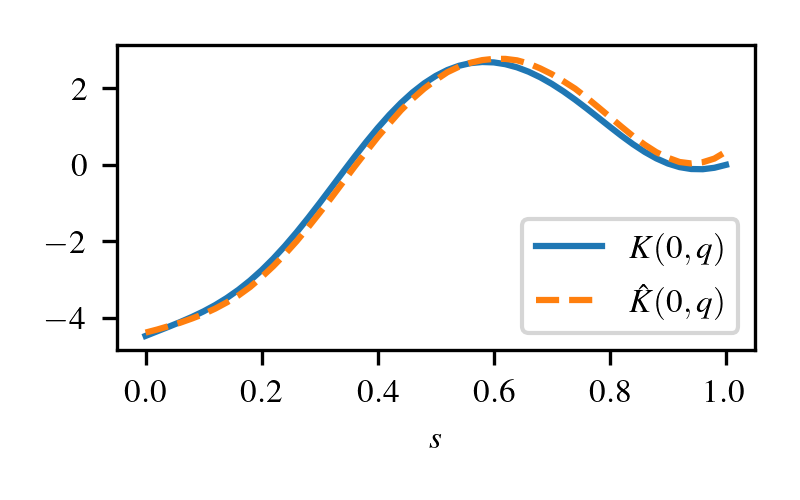

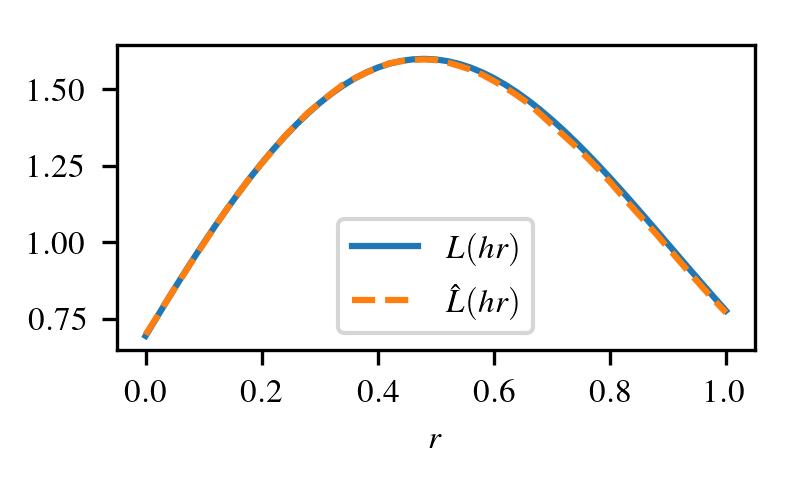

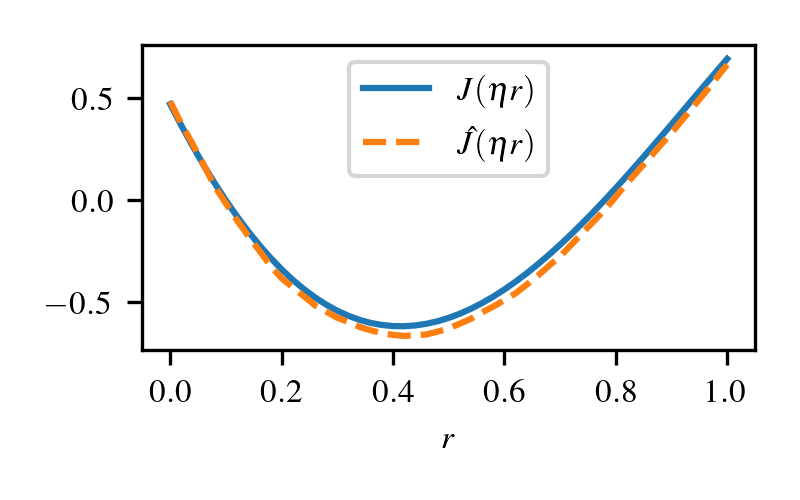

In [49]:
fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(spatial, Kbud,label=r'$K(0,q)$',linewidth=1.5)
plt.plot(spatial, Klearningbud,linestyle='--',label=r'$\hat K(0,q)$',linewidth=1.5)
plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$s$',fontsize="8")
# plt.yticks(np.arange(-4,5,2))
plt.tick_params(labelsize=8)
fig = plt.gcf()
fig.tight_layout()
# plt.savefig('img/K.eps', dpi=300,bbox_inches='tight')


fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.plot(spatial, Lbud,label=r'$L(hr)$',linewidth=1.5)
plt.plot(spatial, Llearningbud,linestyle='--',label=r'$\hat L(hr)$',linewidth=1.5)
plt.legend(loc='best' ,fontsize="8")
plt.xlabel(r'$r$',fontsize="8")
# plt.yticks(np.arange(-2,4,1))
plt.tick_params(labelsize=8)
fig = plt.gcf()
fig.tight_layout()
# plt.savefig('img/L.eps', dpi=300,bbox_inches='tight')

fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.plot(spatial, Jbud,label=r'$J(\eta r)$',linewidth=1.5)
plt.plot(spatial, Jlearningbud,linestyle='--',label=r'$\hat J(\eta r)$',linewidth=1.5)
plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$r$',fontsize="8")
# plt.yticks(np.arange(-2,4,1))
plt.tick_params(labelsize=8)
fig = plt.gcf()
fig.tight_layout()
plt.savefig('img/J.eps', dpi=300,bbox_inches='tight')

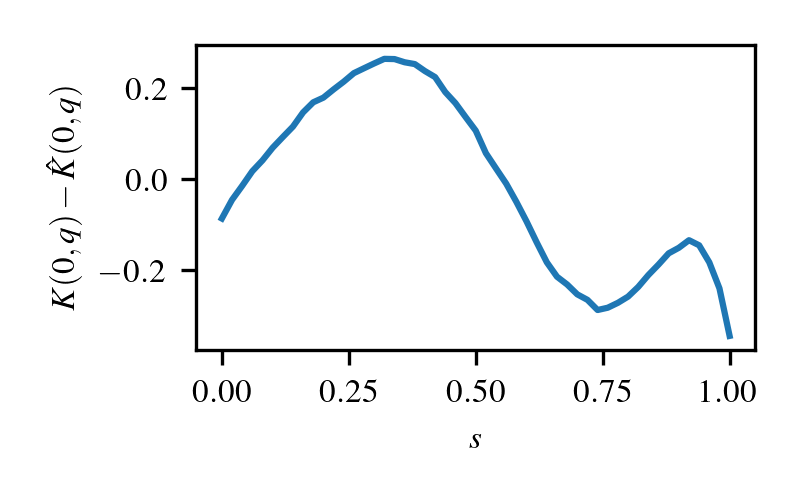

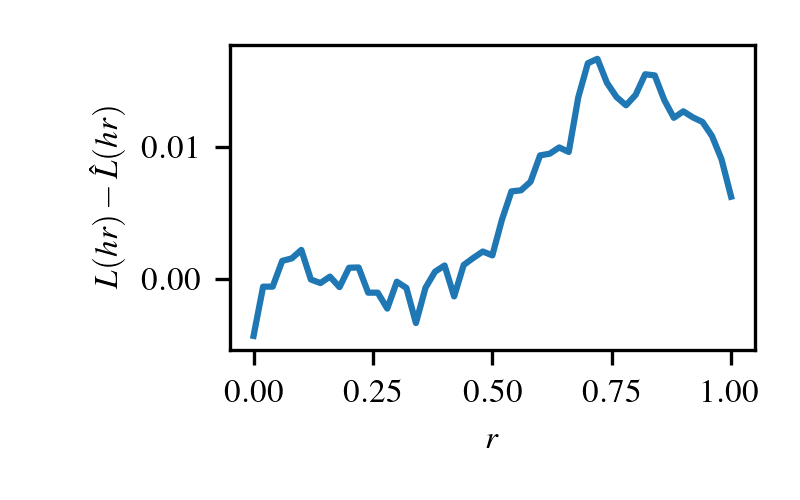

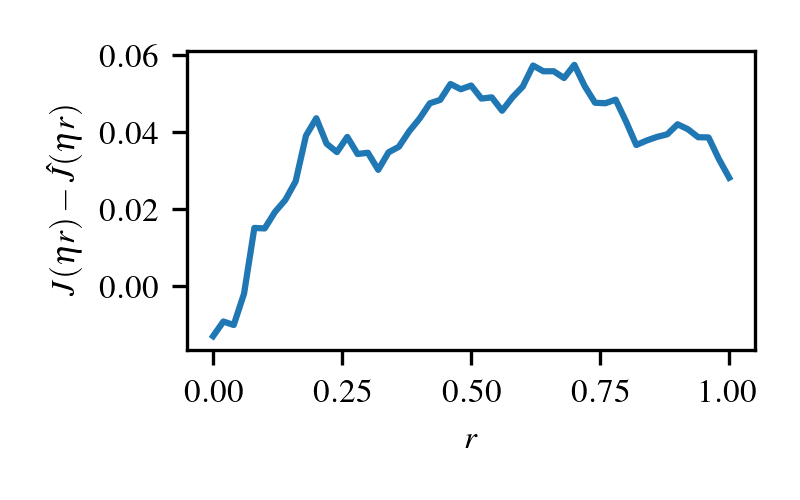

In [48]:
my_dpi=300
fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(spatial, Kbud-Klearningbud,label=r'$K(0,q)-\hat K(0,q)$',linewidth=1.5)
# plt.plot(spatial, Klearningbud,linestyle='--',label=r'$\hat K(0,q)$',linewidth=1.5)
# plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$s$',fontsize="8")
plt.ylabel(r'$K(0,q)-\hat K(0,q)$',fontsize="8")
# plt.yticks(np.arange(-4,5,2))
plt.tick_params(labelsize=8)
fig = plt.gcf()
fig.tight_layout()
# plt.savefig('img/Kerror.eps', dpi=300,bbox_inches='tight')


fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.plot(spatial, Lbud-Llearningbud,label=r'$L(hr)$',linewidth=1.5)
# plt.plot(spatial, Llearningbud,linestyle='--',label=r'$\hat L(hr)$',linewidth=1.5)
# plt.legend(loc='best' ,fontsize="8")
plt.xlabel(r'$r$',fontsize="8")
plt.ylabel(r'$L(hr)-\hat L(hr)$',fontsize="8")
# plt.yticks(np.arange(-2,4,1))
plt.tick_params(labelsize=8)
fig = plt.gcf()
fig.tight_layout()
# plt.savefig('img/Lerror.eps', dpi=300,bbox_inches='tight')

fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.plot(spatial, Jbud-Jlearningbud,label=r'$J(kr)$',linewidth=1.5)
# plt.plot(spatial, Jlearningbud,linestyle='--',label=r'$\hat J(kr)$',linewidth=1.5)
# plt.legend(loc="upper right",fontsize="8")
plt.xlabel(r'$r$',fontsize="8")
plt.ylabel(r'$J(\eta r)-\hat J(\eta r)$',fontsize="8")
# plt.yticks(np.arange(-2,4,1))
plt.tick_params(labelsize=8)
fig = plt.gcf()
fig.tight_layout()
plt.savefig('img/Jerror.eps', dpi=300,bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


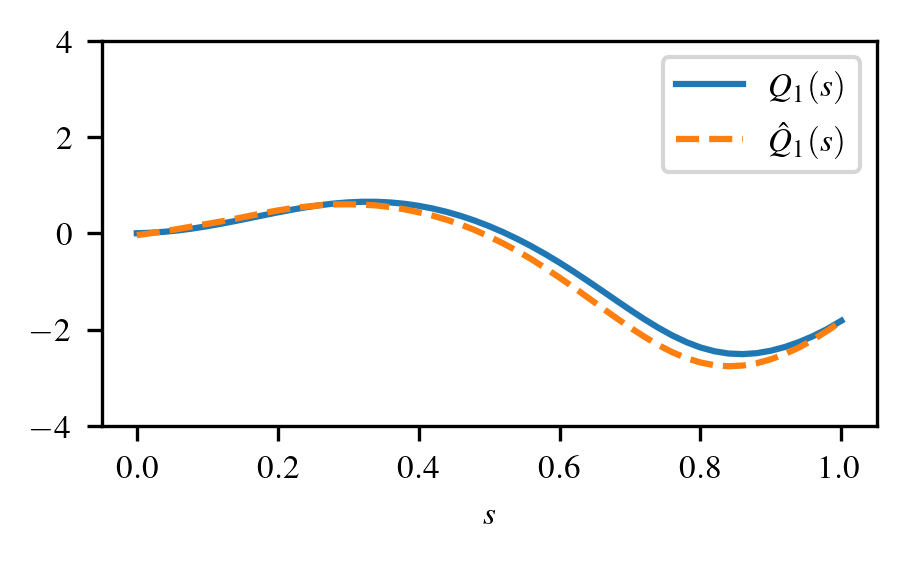

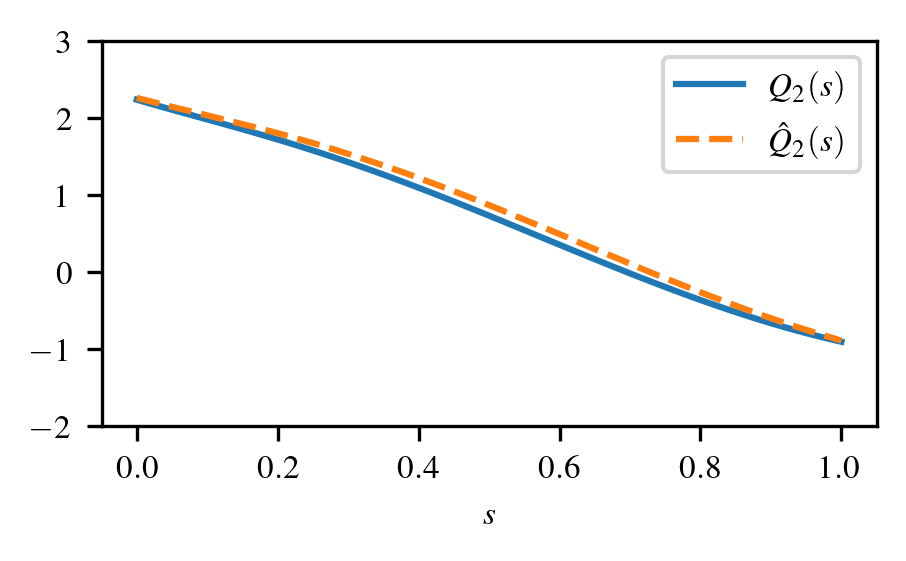

In [ ]:
fig_intep=plt.figure(figsize=(1000 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(spatial, Q1,label=r'$Q_1(s)$',linewidth=1.5)
plt.plot(spatial, Q1learning[0,:],linestyle='--',label=r'$\hat Q_1(s)$',linewidth=1.5)
plt.legend(loc="upper right",fontsize="8")
plt.xlabel(r'$s$',fontsize="8")
plt.yticks(np.arange(-4,5,2))
plt.tick_params(labelsize=8)
plt.savefig('img/q1.eps', dpi=600,bbox_inches='tight')


fig_intep=plt.figure(figsize=(1000 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.plot(spatial, Q2,label=r'$Q_2(s)$',linewidth=1.5)
plt.plot(spatial, Q2learning[0,:],linestyle='--',label=r'$\hat Q_2(s)$',linewidth=1.5)
plt.legend(loc="upper right",fontsize="8")
plt.xlabel(r'$s$',fontsize="8")
plt.yticks(np.arange(-2,4,1))
plt.tick_params(labelsize=8)
plt.savefig('img/q2.eps', dpi=600,bbox_inches='tight')

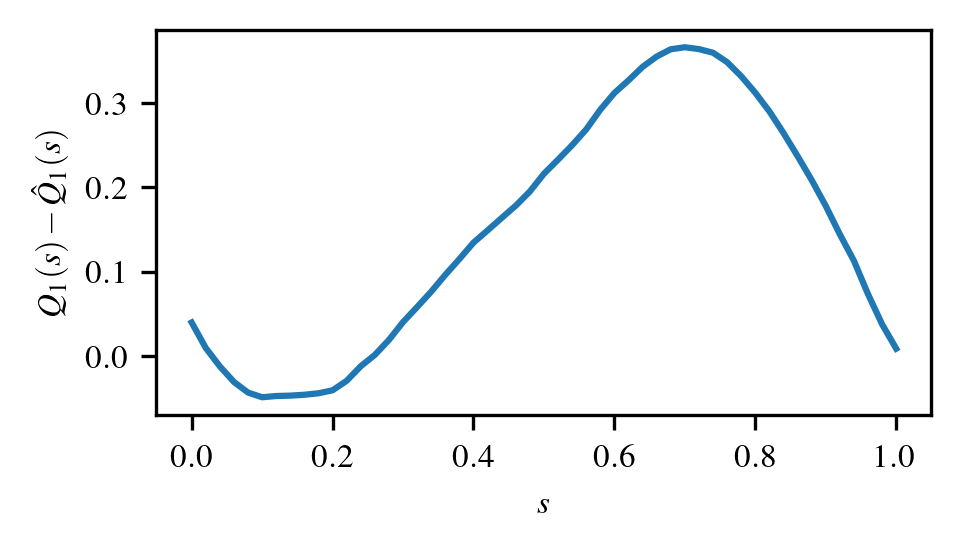

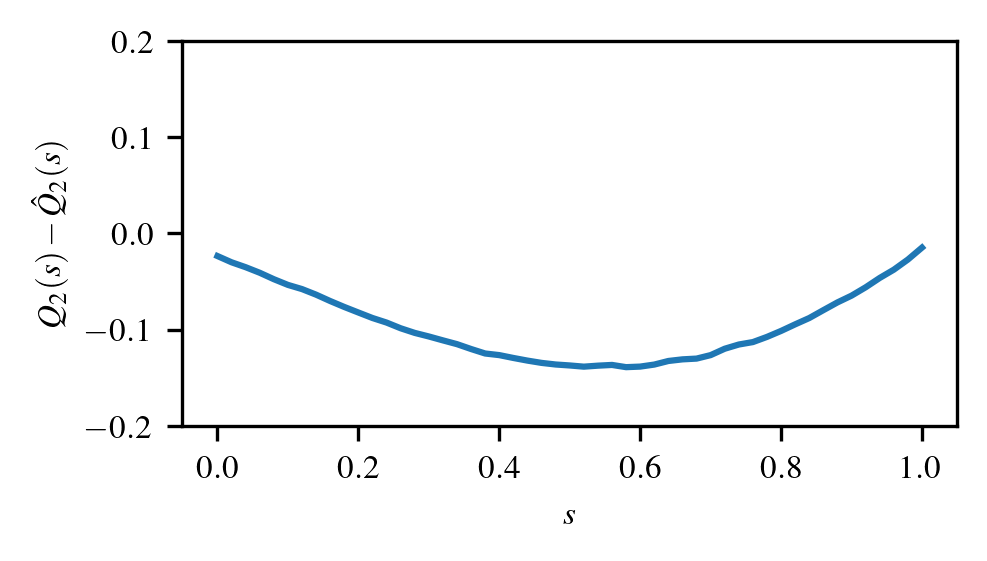

In [ ]:
fig_intep=plt.figure(figsize=(1000 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(spatial, Q1- Q1learning[0,:],linewidth=1.5) 
# plt.legend(loc="best",fontsize="8")
# plt.legend(ncol=2)
plt.xlabel(r'$s$',fontsize="8")
plt.ylabel(r'$Q_1(s)-\hat Q_1(s) $',fontsize="8")
#plt.yticks(np.arange(-0.5,0.6,0.2))
plt.tick_params(labelsize=8)
plt.savefig('img/q1error.eps', dpi=600,bbox_inches='tight')

fig_intep=plt.figure(figsize=(1000 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(spatial, Q2- Q2learning[0,:],linewidth=1.5)
# plt.legend(loc="upper left",fontsize="8")
# plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$s$',fontsize="8")
plt.ylabel(r'$Q_2(s)-\hat Q_2(s)$',fontsize="8" )
plt.yticks(np.arange(-0.2,0.3,0.1))
plt.tick_params(labelsize=8)
plt.savefig('img/q2error.eps', dpi=600,bbox_inches='tight')


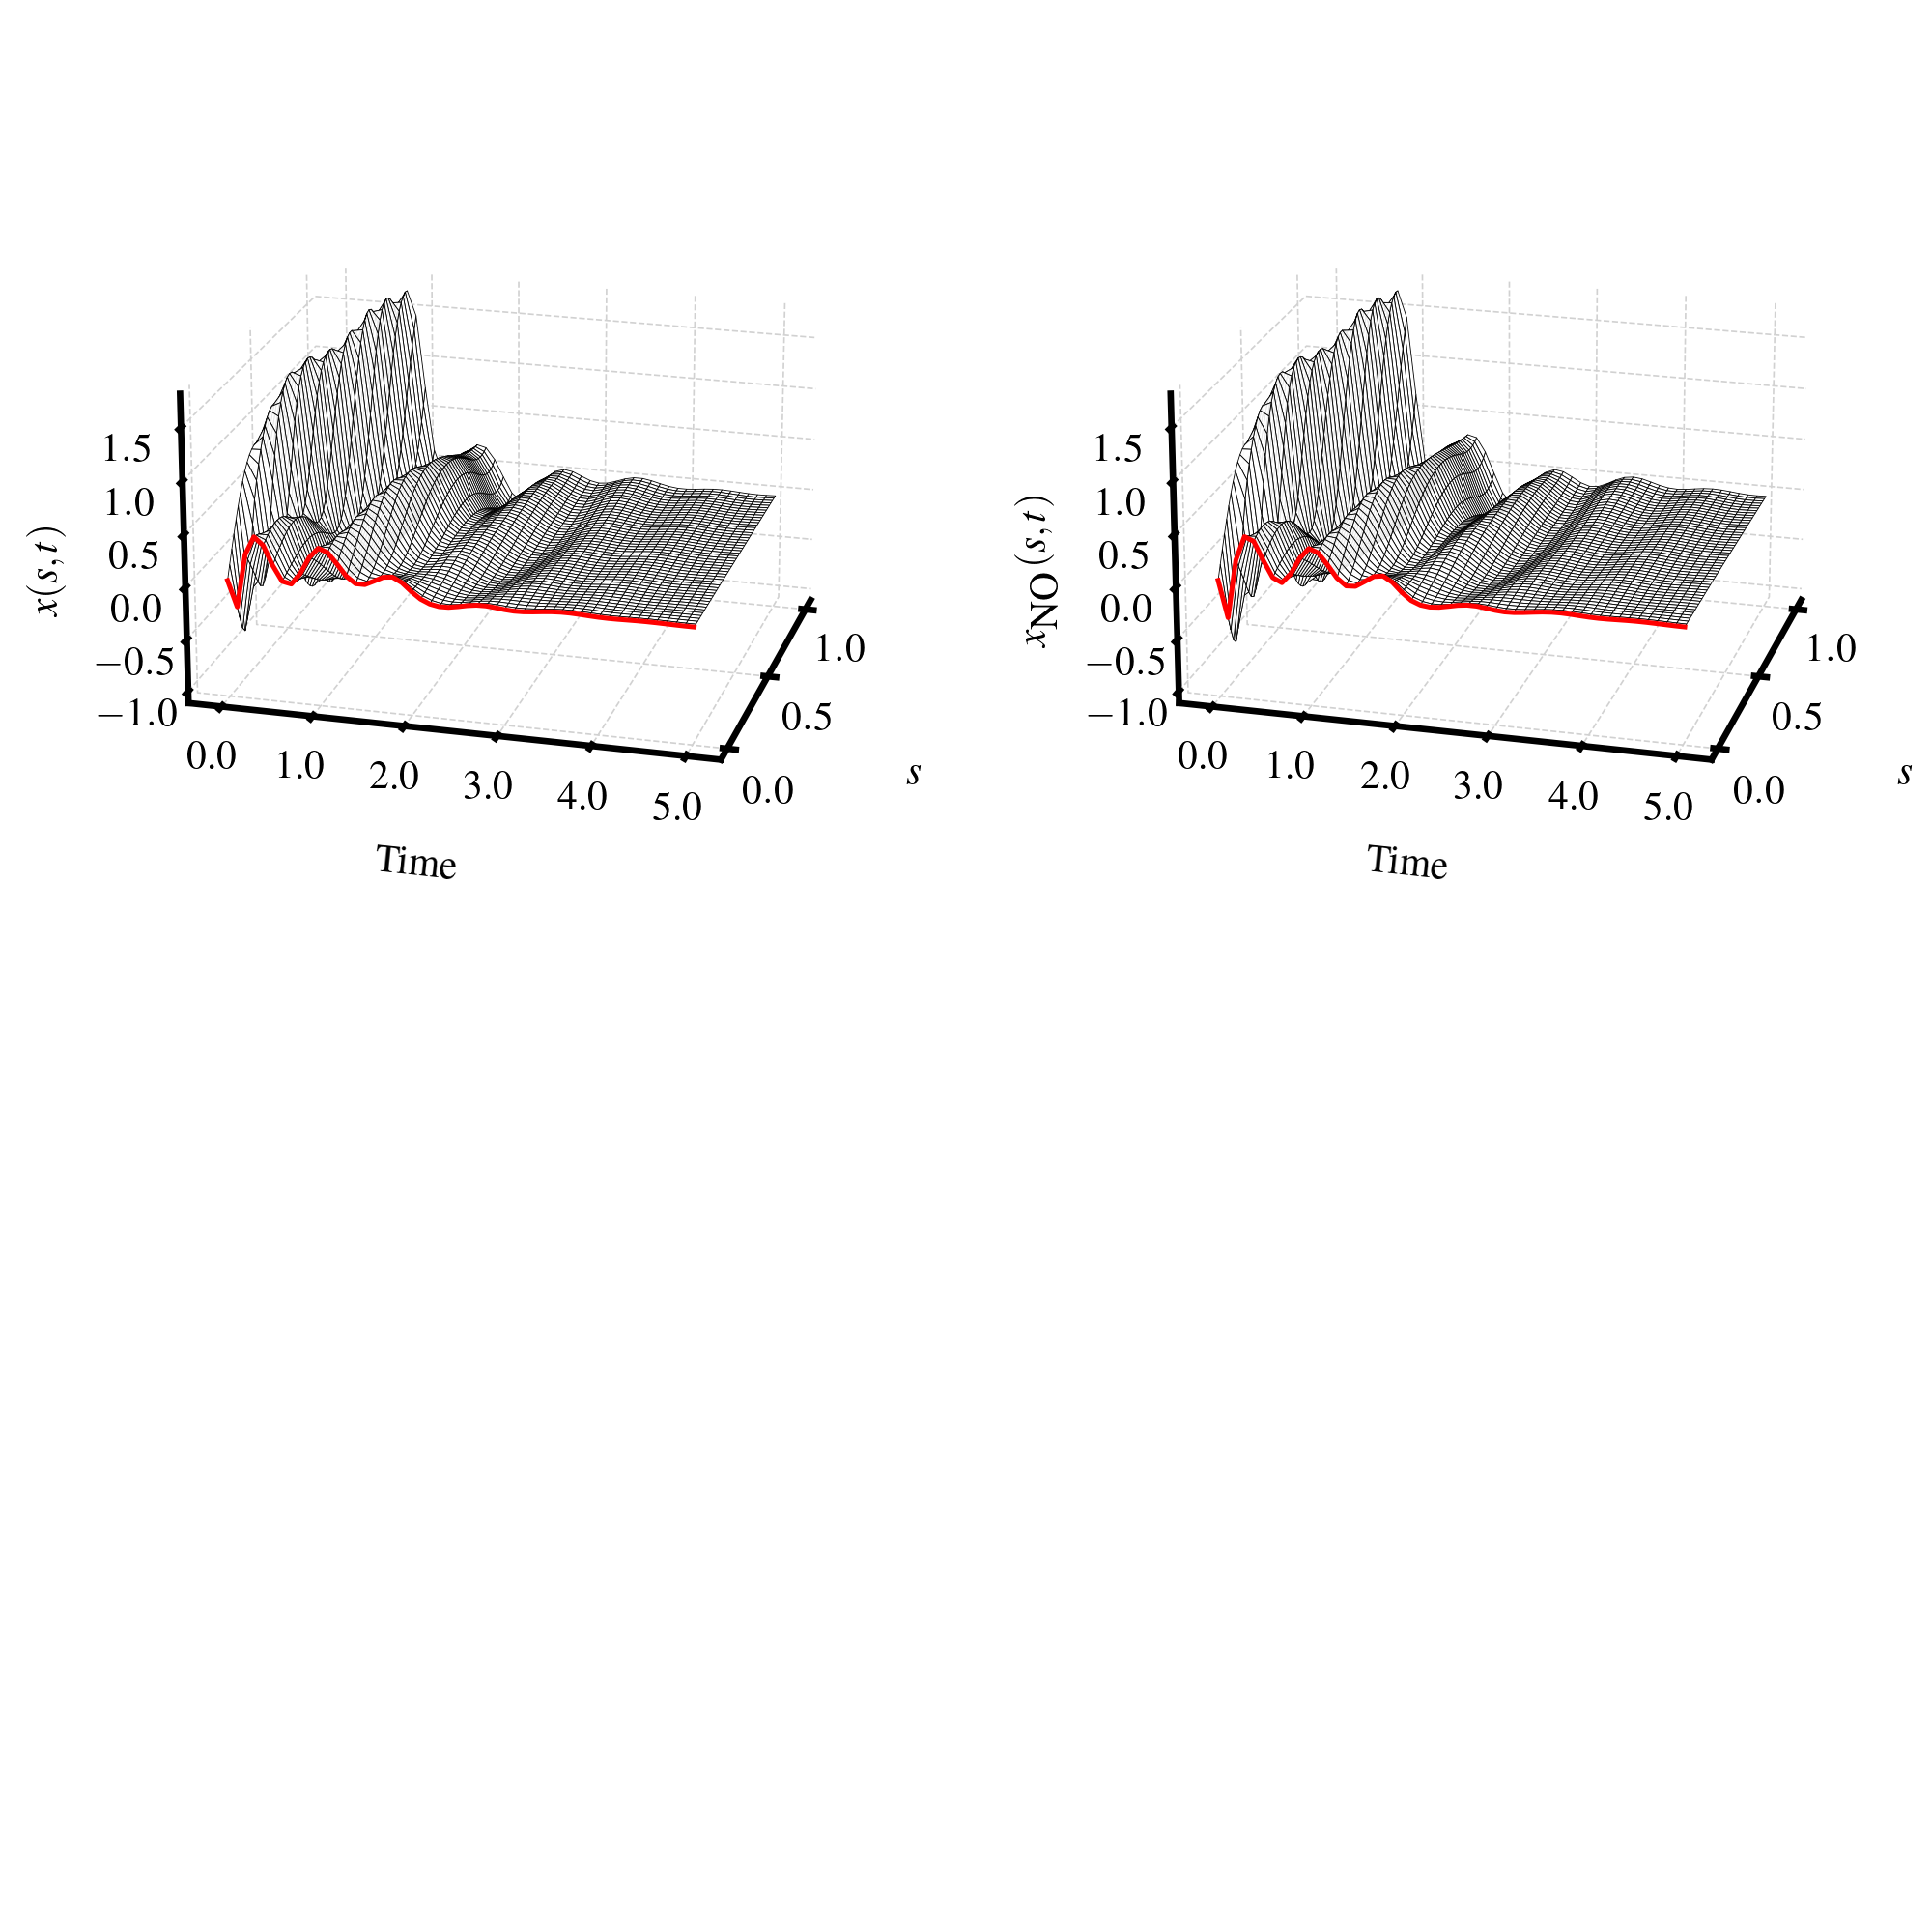

In [179]:
############### draw output
my_dpi=300
# res = 10
draw_rate = 10
nt_draw=nt
temporal_draw=temporal[0:nt_draw:draw_rate]
meshx2, mesht2 = np.meshgrid(spatial, temporal_draw)
test=np.zeros(len(temporal_draw))
# fig = plt.figure(figsize=set_size(2000, 0.99, (2, 2), height_add=1))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

fig = plt.figure(figsize=(1000 / my_dpi, 1000 / my_dpi), dpi=600)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)
ax[0]=Axes3D(fig)
ax[1]=Axes3D(fig)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.05, bottom=0, right=0.99, top=0.99, wspace=0.2, hspace=0)

# subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
# meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
# ax[0].plot_surface(meshx, meshy, zeroToNan(kappa1)-zeroToNan(k1),edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
ax[0].plot_surface(meshx2, mesht2, uu[0:nt_draw:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax.plot_surface(meshx2, mesht2, ulearning_est[0:nt:draw_rate,:],  
#                         cmap = cm.coolwarm, shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
ax[0].plot(test, temporal_draw, uu[0:nt_draw:draw_rate,0], color="red", lw=0.6, antialiased=True)

ax[0].invert_xaxis()
ax[0].get_proj = lambda: np.dot(Axes3D.get_proj(ax[0]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例

# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(20,15)
ax[0].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[0].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[0].set_zlabel(r"$x(s,t)$",fontsize = 5 , rotation = 90, labelpad=-10)
ax[0].set_xticks([0, 0.5, 1])
# ax[0].set_yticks([0, 10, 20, 30, 40, 50])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5 , pad=-4)  # x轴标签旋转、字号等 

ax[1].plot_surface(meshx2, mesht2, uulearning[0:nt_draw:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax[1].plot_surface(meshx, meshy, kappa2-k2,edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
ax[1].plot(test, temporal_draw, uulearning[0:nt_draw:draw_rate,0], color="red", lw=0.6, antialiased=True)
ax[1].invert_xaxis()
 
ax[1].get_proj = lambda: np.dot(Axes3D.get_proj(ax[1]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例
# vals = (u[0:nt:draw_rate,0].transpose())
# ax[1].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=True)
ax[1].view_init(20, 15)
ax[1].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[1].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[1].set_zlabel(r"$x_{\rm NO}(s,t)$", fontsize = 5 ,rotation = 90, labelpad=-10)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
# ax[1].set_yticks([0, 25, 50])
# ax[1].set_yticks(np.arange(0,60,10))

# ax[1].set_zticks([-2, 0, 2])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax[1].zaxis._PLANES
ax[1].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5]) 
ax[1].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5, pad=-4 )  # x轴标签旋转、字号等 
# plt.savefig('img/statefeedback.pdf', dpi=300,bbox_inches='tight')

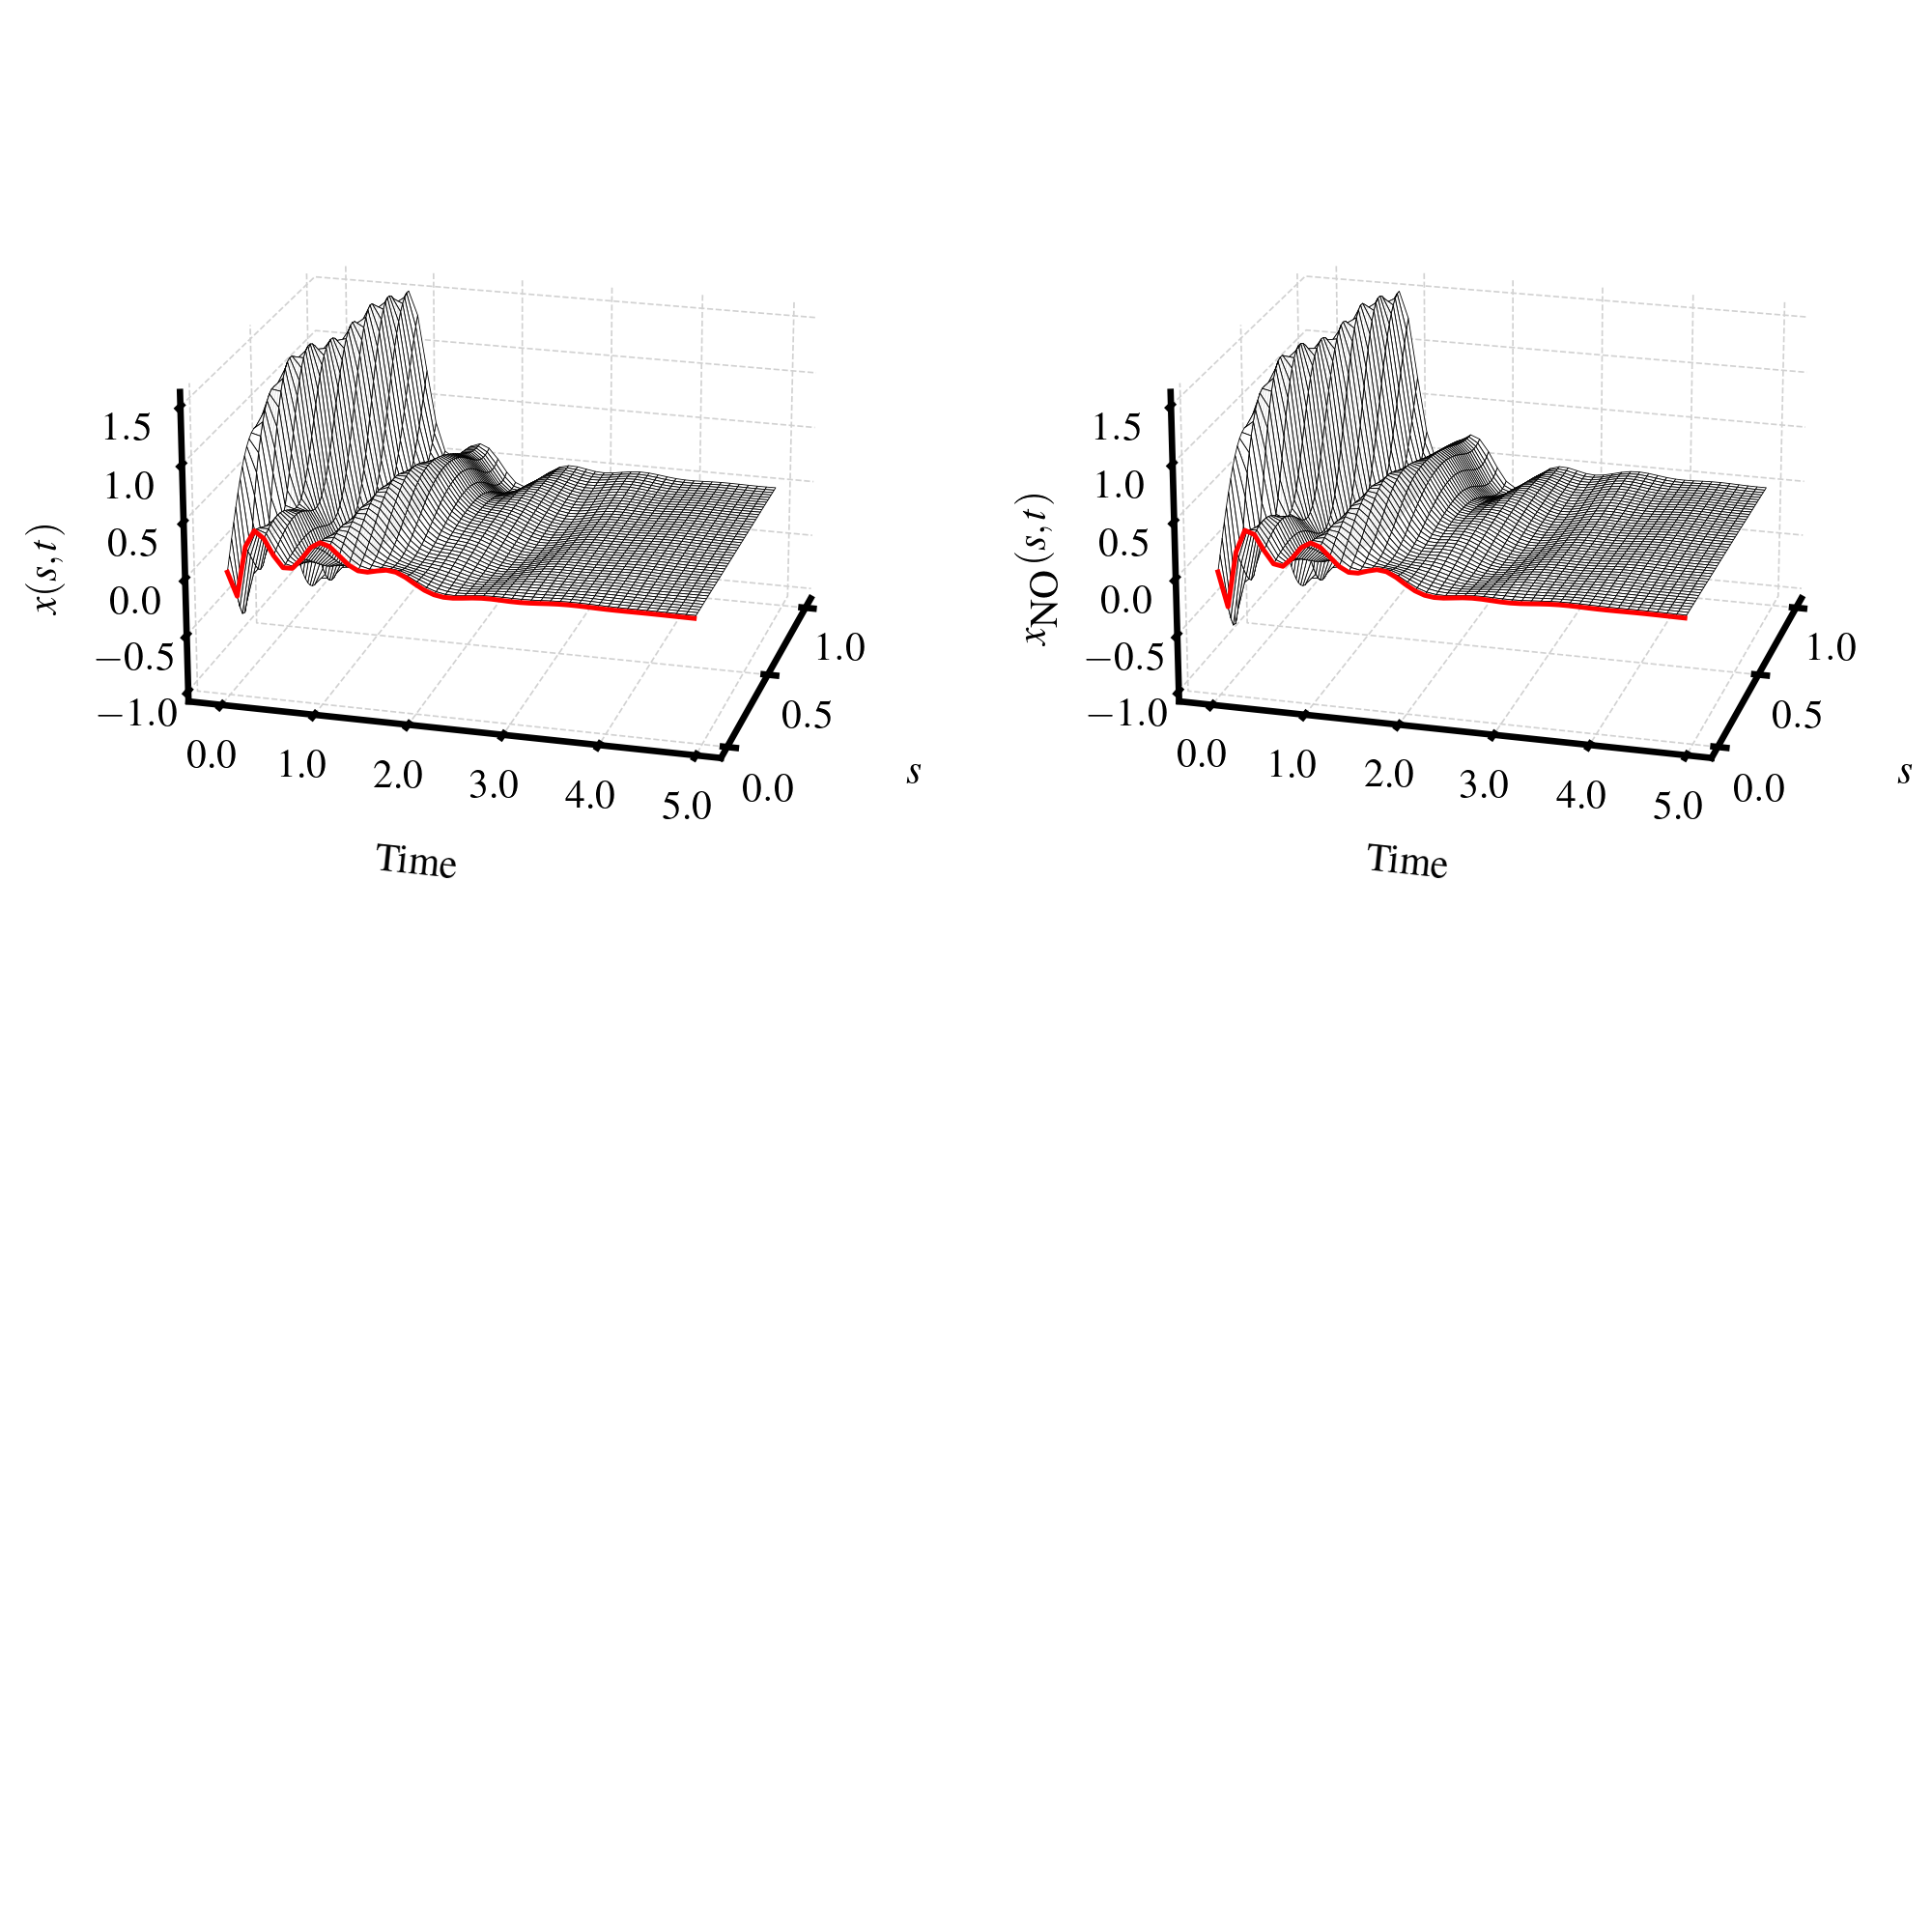

In [104]:
############### draw output
my_dpi=300
# res = 10
draw_rate = 100
nt_draw=5000
temporal_draw=temporal[0:nt_draw:draw_rate]
meshx2, mesht2 = np.meshgrid(spatial, temporal_draw)
test=np.zeros(len(temporal_draw))
# fig = plt.figure(figsize=set_size(2000, 0.99, (2, 2), height_add=1))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

fig = plt.figure(figsize=(1000 / my_dpi, 1000 / my_dpi), dpi=600)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)
ax[0]=Axes3D(fig)
ax[1]=Axes3D(fig)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.05, bottom=0, right=0.99, top=0.99, wspace=0.2, hspace=0)

# subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
# meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
# ax[0].plot_surface(meshx, meshy, zeroToNan(kappa1)-zeroToNan(k1),edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
ax[0].plot_surface(meshx2, mesht2, uu[0:nt_draw:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax.plot_surface(meshx2, mesht2, ulearning_est[0:nt:draw_rate,:],  
#                         cmap = cm.coolwarm, shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
ax[0].plot(test, temporal_draw, uu[0:nt_draw:draw_rate,0], color="red", lw=0.6, antialiased=True)

ax[0].invert_xaxis()
ax[0].get_proj = lambda: np.dot(Axes3D.get_proj(ax[0]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例

# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(20,15)
ax[0].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[0].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[0].set_zlabel(r"$x(s,t)$",fontsize = 5 , rotation = 90, labelpad=-10)
ax[0].set_xticks([0, 0.5, 1])
# ax[0].set_yticks([0, 10, 20, 30, 40, 50])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5 , pad=-4)  # x轴标签旋转、字号等 

ax[1].plot_surface(meshx2, mesht2, uulearning[0:nt_draw:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax[1].plot_surface(meshx, meshy, kappa2-k2,edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
ax[1].plot(test, temporal_draw, uulearning[0:nt_draw:draw_rate,0], color="red", lw=0.6, antialiased=True)
ax[1].invert_xaxis()
 
ax[1].get_proj = lambda: np.dot(Axes3D.get_proj(ax[1]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例
# vals = (u[0:nt:draw_rate,0].transpose())
# ax[1].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=True)
ax[1].view_init(20, 15)
ax[1].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[1].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[1].set_zlabel(r"$x_{\rm NO}(s,t)$", fontsize = 5 ,rotation = 90, labelpad=-10)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
# ax[1].set_yticks([0, 25, 50])
# ax[1].set_yticks(np.arange(0,60,10))

# ax[1].set_zticks([-2, 0, 2])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax[1].zaxis._PLANES
ax[1].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5]) 
ax[1].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5, pad=-4 )  # x轴标签旋转、字号等 
plt.savefig('img/statefeedback.pdf', dpi=300,bbox_inches='tight')

In [180]:
uu_L2=np.sqrt(np.sum(uu*uu,axis=1)*dx)
uulearning_L2=np.sqrt(np.sum(uulearning*uulearning,axis=1)*dx)
meshx2_state, mesht2_state = np.meshgrid(spatial, temporal)

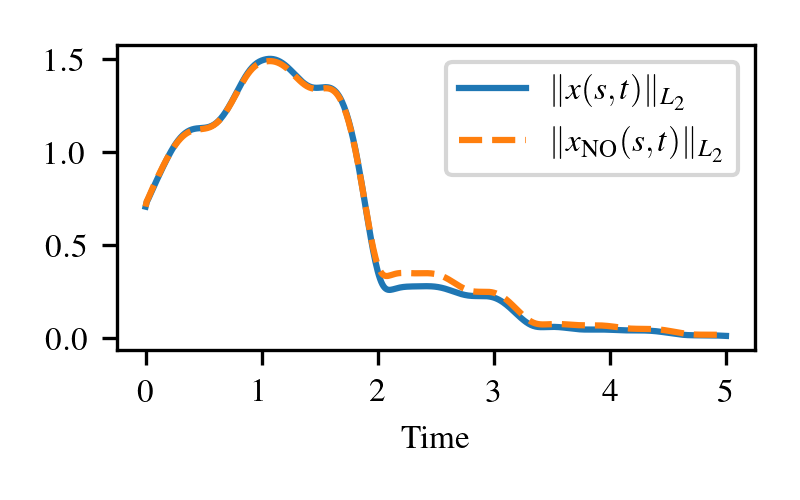

In [181]:
####### draw L2-norm
font3 = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 8,
    }
my_dpi=300
plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(temporal[0:nt], uu_L2[0:nt],linewidth=1.5,label=r'$\Vert x(s,t)\Vert_{L_2}$')
plt.plot(temporal[0:nt], uulearning_L2[0:nt],linewidth=1.5,linestyle='--', label=r'$\Vert x_{\rm NO}(s,t)\Vert_{L_2}$')
# plt.legend(loc="upper left",fontsize="8")
plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$\rm{Time}$',fontsize="8")
# plt.ylabel(r'$\Vert x_{NO}(\zeta,t)\Vert$',fontsize="8")
plt.yticks(np.arange(0,2,0.5))
plt.tick_params(labelsize=8)
fig = plt.gcf()
fig.tight_layout()
# plt.savefig('img/u_L2_state.eps', dpi=300,bbox_inches='tight')


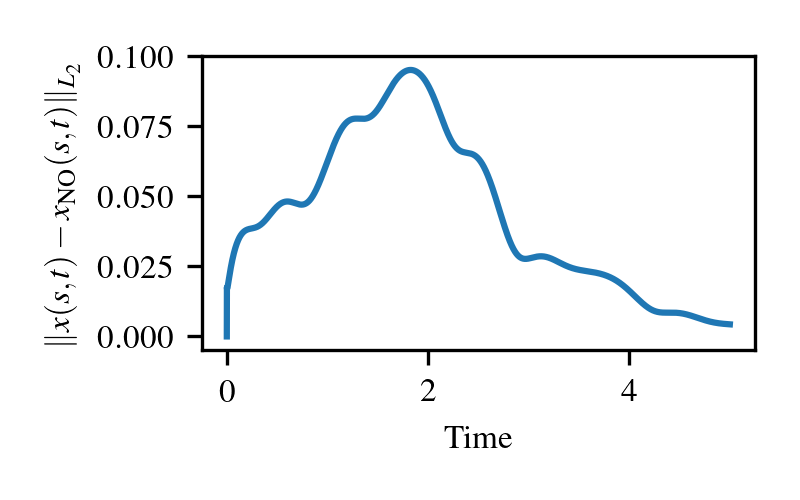

In [109]:
ee_state=uu-uulearning
error_u_state_L2=np.sqrt(np.sum(ee_state*ee_state,axis=1)*dx)

fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(temporal[0:nt_draw], error_u_state_L2[0:nt_draw],linewidth=1.5)
# plt.legend(loc="upper left",fontsize="8")
# plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$\rm{Time}$',fontsize="8")
plt.ylabel(r'$\Vert x(s,t) -  x_{\rm NO}(s,t)\Vert_{L_2}$',fontsize="8")
plt.yticks(np.arange(0,0.125,0.025))
plt.tick_params(labelsize=8)

fig = plt.gcf()
fig.tight_layout()
plt.savefig('img/L2error_state.eps', dpi=300,bbox_inches='tight')

Beginning to draw observer

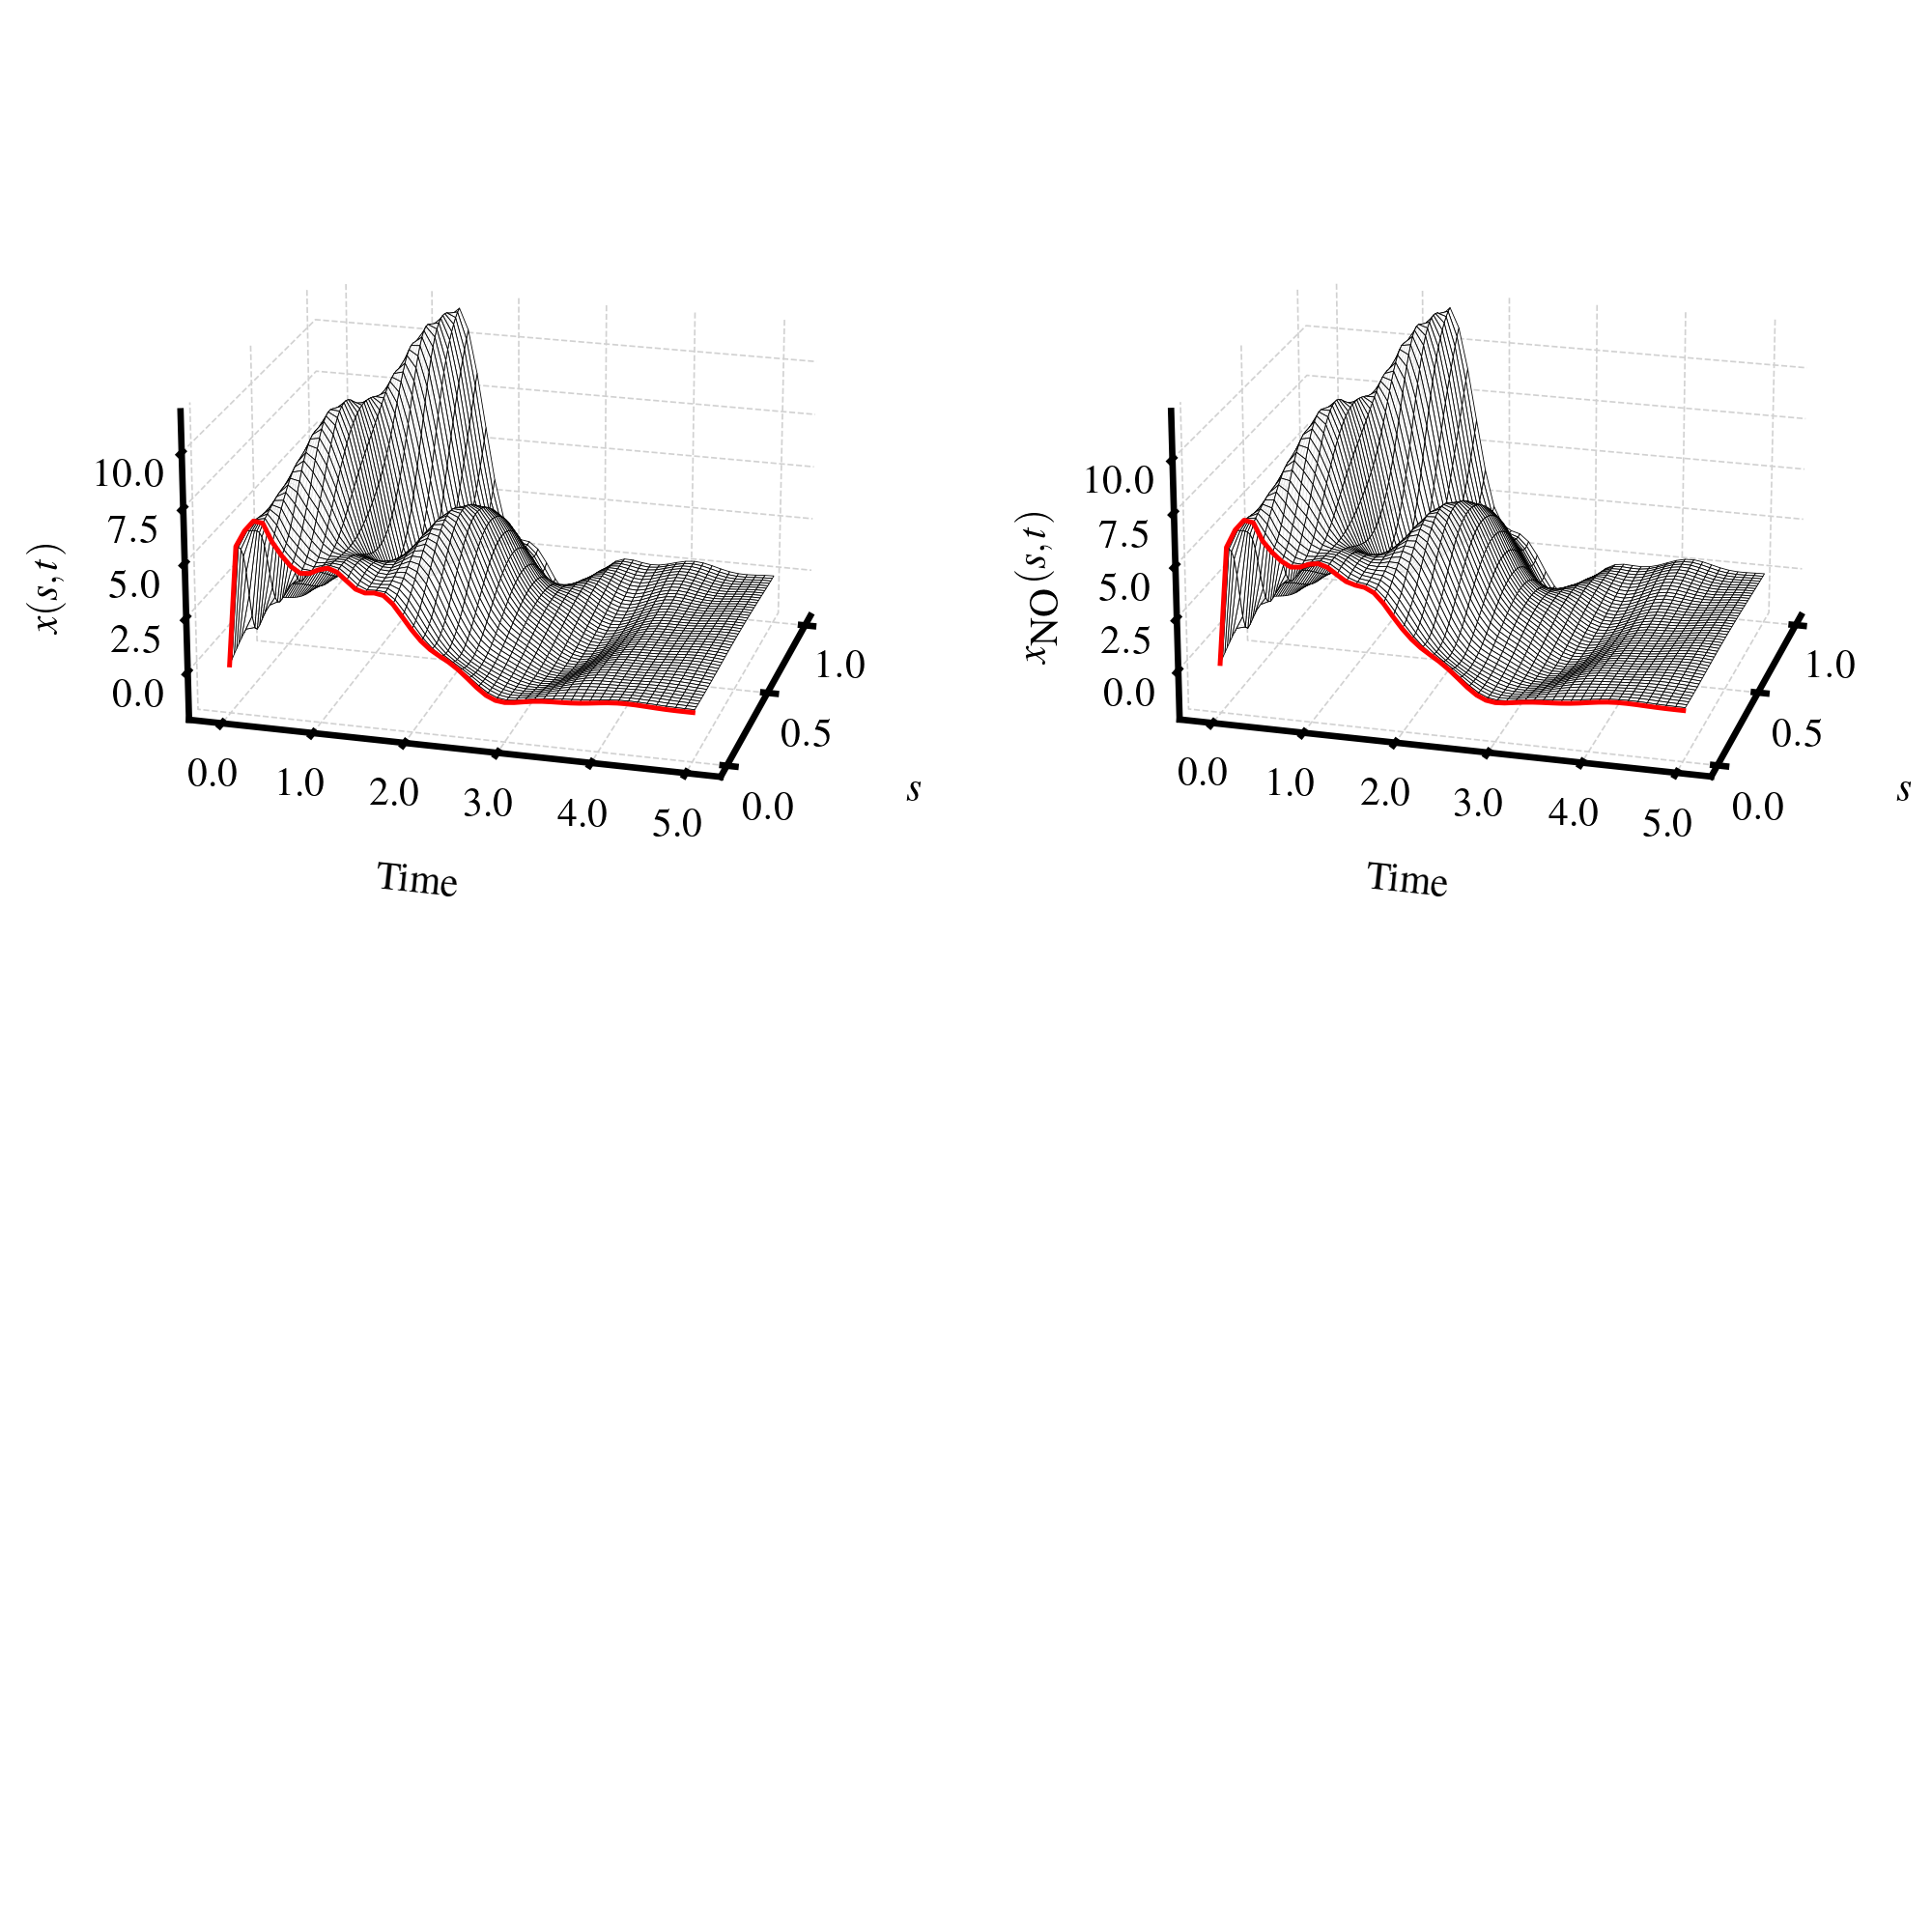

In [182]:
############### draw output

# res = 10
draw_rate = 10
nt_draw=nt
temporal_draw=temporal[0:nt_draw:draw_rate]
meshx2, mesht2 = np.meshgrid(spatial, temporal_draw)
test=np.zeros(len(temporal_draw))
# fig = plt.figure(figsize=set_size(2000, 0.99, (2, 2), height_add=1))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

fig = plt.figure(figsize=(1000 / my_dpi, 1000 / my_dpi), dpi=600)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)
ax[0]=Axes3D(fig)
ax[1]=Axes3D(fig)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.05, bottom=0, right=0.99, top=0.99, wspace=0.2, hspace=0)

# subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
# meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
# ax[0].plot_surface(meshx, meshy, zeroToNan(kappa1)-zeroToNan(k1),edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
ax[0].plot_surface(meshx2, mesht2, uu_output[0:nt_draw:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax.plot_surface(meshx2, mesht2, ulearning_est[0:nt:draw_rate,:],  
#                         cmap = cm.coolwarm, shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
ax[0].plot(test, temporal_draw, uu_output[0:nt_draw:draw_rate,0], color="red", lw=0.6, antialiased=True)

ax[0].invert_xaxis()
ax[0].get_proj = lambda: np.dot(Axes3D.get_proj(ax[0]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例

# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(20,15)
ax[0].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[0].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[0].set_zlabel(r"$x(s,t)$",fontsize = 5 , rotation = 90, labelpad=-10)
ax[0].set_xticks([0, 0.5, 1])
# ax[0].set_yticks([0, 10, 20, 30, 40, 50])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5 , pad=-4)  # x轴标签旋转、字号等 

ax[1].plot_surface(meshx2, mesht2, uu_output_learning[0:nt_draw:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax[1].plot_surface(meshx, meshy, kappa2-k2,edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
ax[1].plot(test, temporal_draw, uu_output_learning[0:nt_draw:draw_rate,0], color="red", lw=0.6, antialiased=True)
ax[1].invert_xaxis()
 
ax[1].get_proj = lambda: np.dot(Axes3D.get_proj(ax[1]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例
# vals = (u[0:nt:draw_rate,0].transpose())
# ax[1].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=True)
ax[1].view_init(20, 15)
ax[1].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[1].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[1].set_zlabel(r"$x_{\rm NO}(s,t)$", fontsize = 5 ,rotation = 90, labelpad=-10)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
# ax[1].set_yticks([0, 25, 50])
# ax[1].set_yticks(np.arange(0,60,10))

# ax[1].set_zticks([-2, 0, 2])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax[1].zaxis._PLANES
ax[1].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5]) 
ax[1].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5, pad=-4 )  # x轴标签旋转、字号等 
# plt.savefig('img/output1.pdf', dpi=600,bbox_inches='tight')

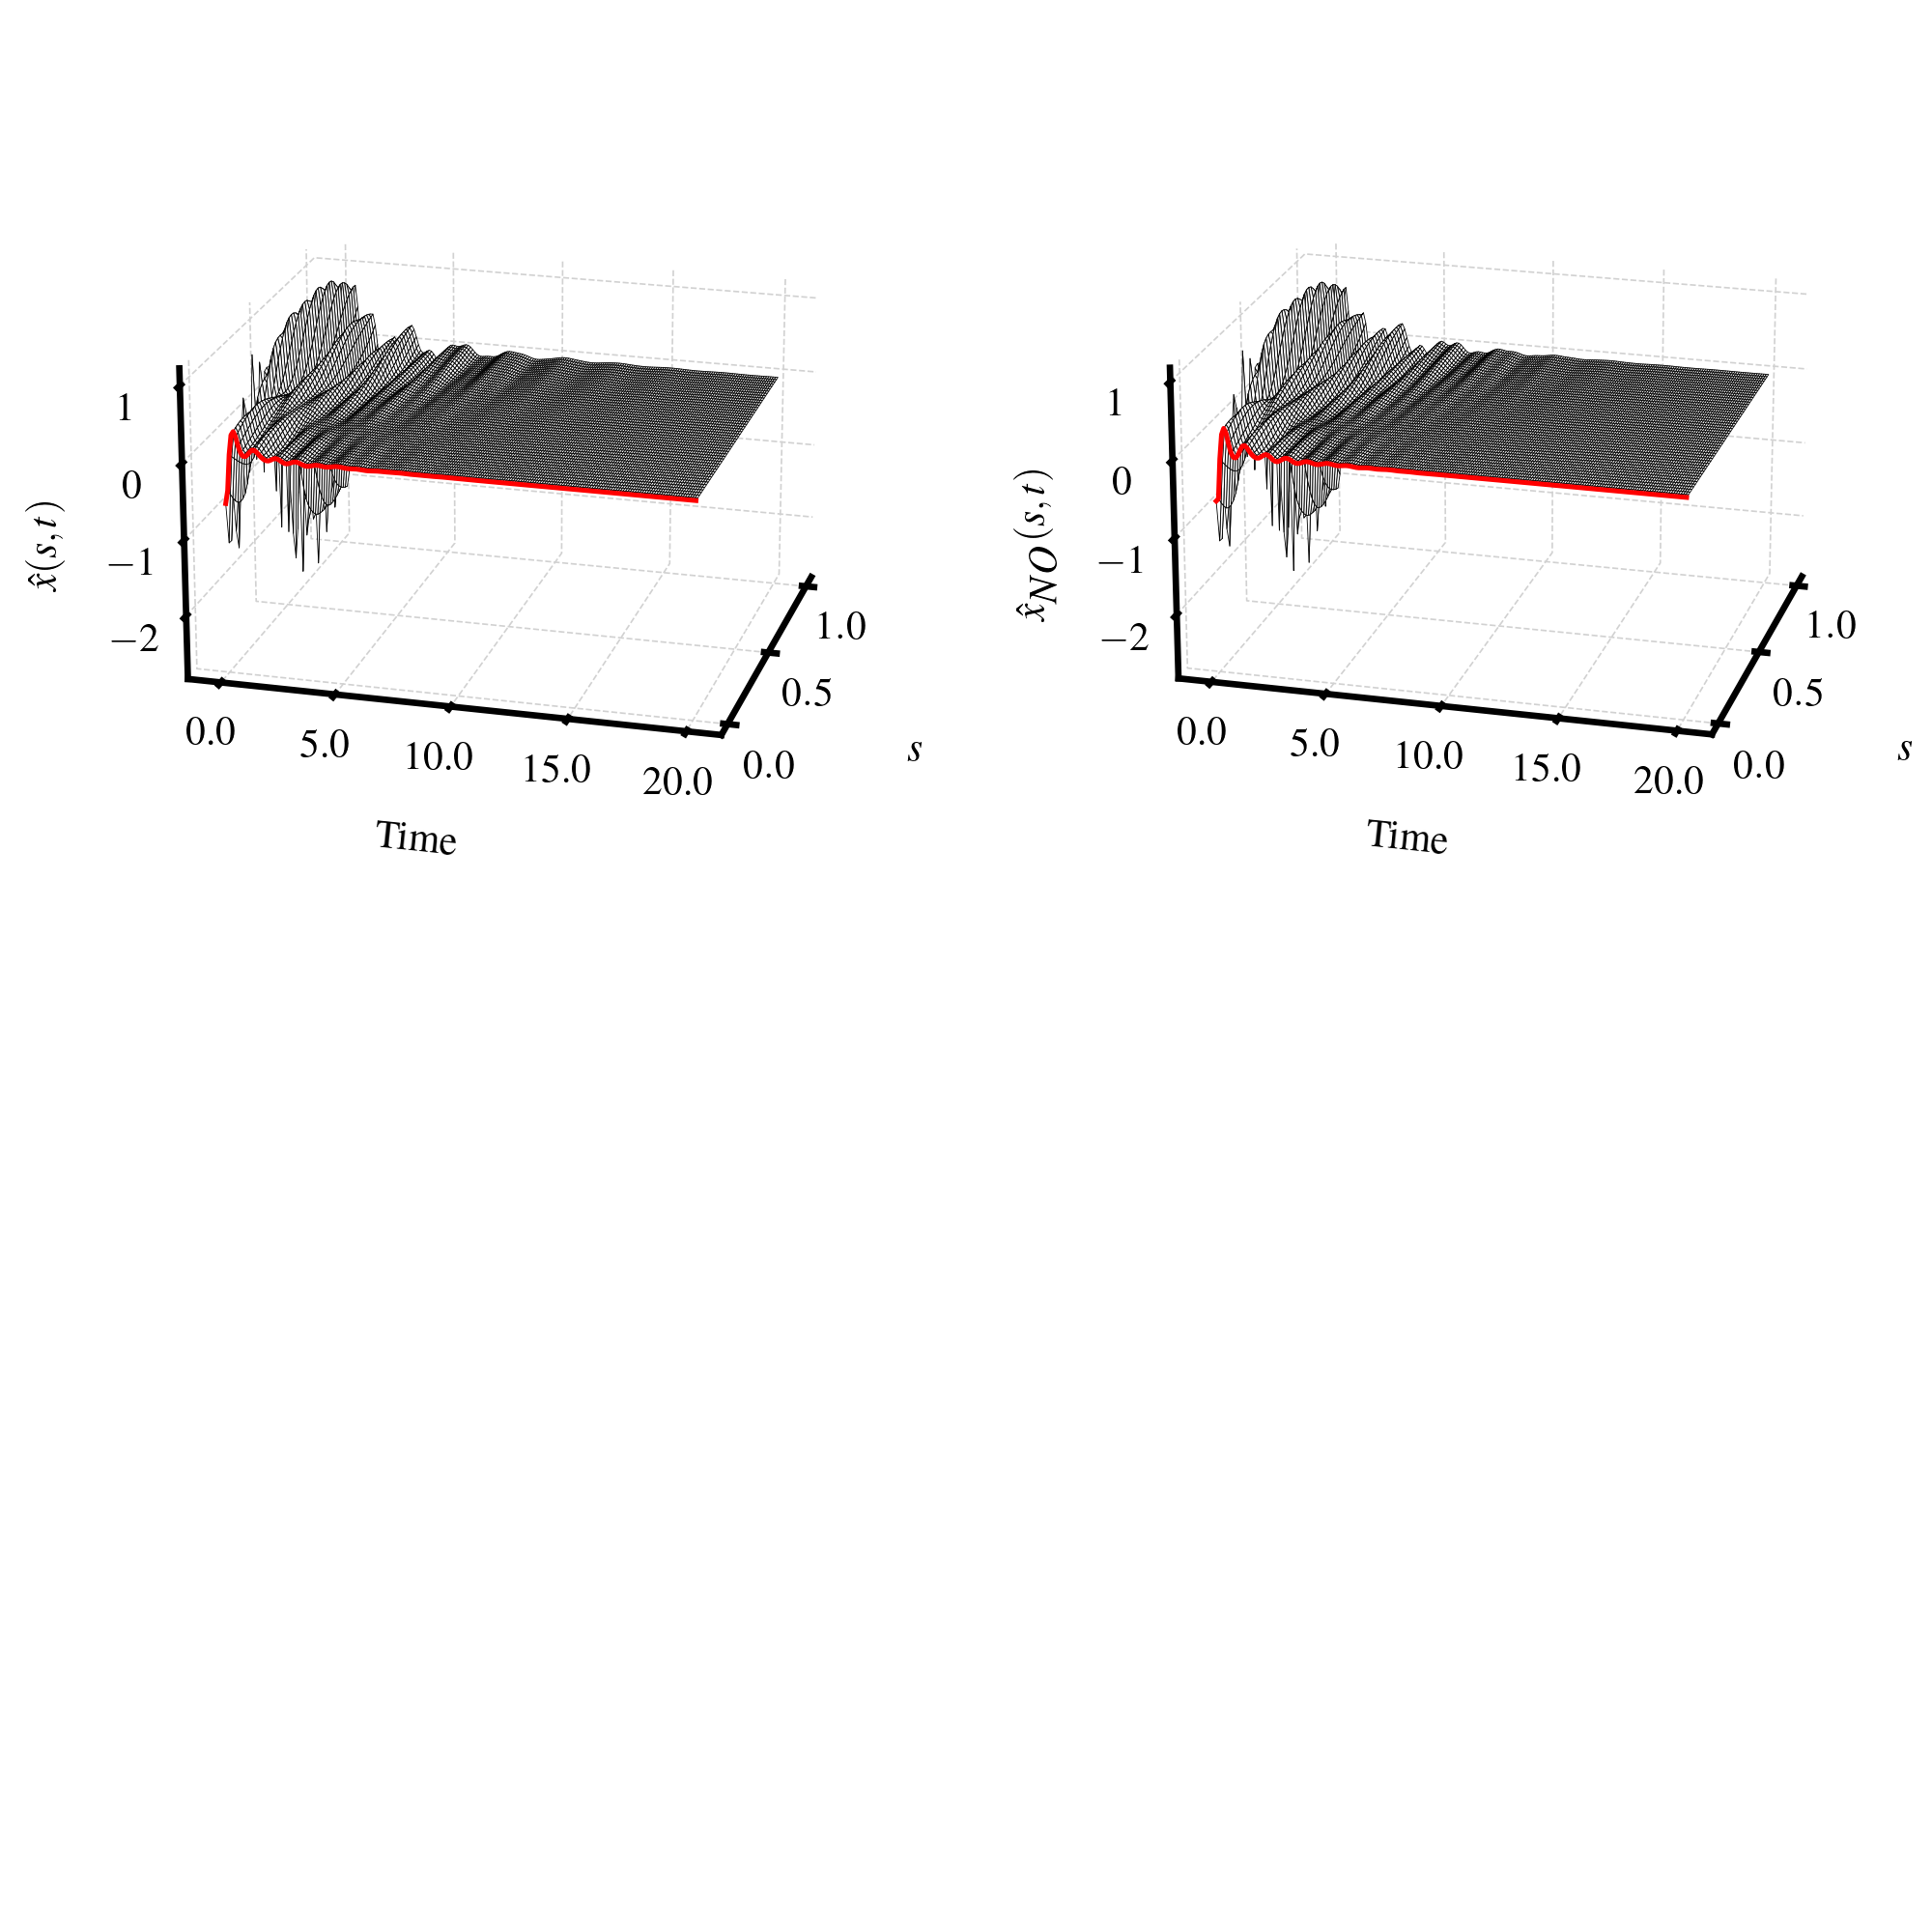

In [ ]:
############### draw output

# res = 10
draw_rate = 100
temporal_draw=temporal[0:nt:draw_rate]
meshx2, mesht2 = np.meshgrid(spatial, temporal_draw)
test=np.zeros(len(temporal_draw))
# fig = plt.figure(figsize=set_size(2000, 0.99, (2, 2), height_add=1))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

fig = plt.figure(figsize=(1000 / my_dpi, 1000 / my_dpi), dpi=600)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)
ax[0]=Axes3D(fig)
ax[1]=Axes3D(fig)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.05, bottom=0, right=0.99, top=0.99, wspace=0.2, hspace=0)

# subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
# meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
# ax[0].plot_surface(meshx, meshy, zeroToNan(kappa1)-zeroToNan(k1),edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
ax[0].plot_surface(meshx2, mesht2, uu_output_est[0:nt:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax.plot_surface(meshx2, mesht2, ulearning_est[0:nt:draw_rate,:],  
#                         cmap = cm.coolwarm, shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
ax[0].plot(test, temporal_draw, uu_output_est[0:nt:draw_rate,0], color="red", lw=0.6, antialiased=True)

ax[0].invert_xaxis()
ax[0].get_proj = lambda: np.dot(Axes3D.get_proj(ax[0]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例

# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(20,15)
ax[0].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[0].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[0].set_zlabel(r"$\hat x(s,t)$",fontsize = 5 , rotation = 90, labelpad=-10)
ax[0].set_xticks([0, 0.5, 1])
# ax[0].set_yticks([0, 10, 20, 30, 40, 50])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5 , pad=-4)  # x轴标签旋转、字号等 

ax[1].plot_surface(meshx2, mesht2, uu_output_est_learning[0:nt:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax[1].plot_surface(meshx, meshy, kappa2-k2,edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
ax[1].plot(test, temporal_draw, uu_output_est_learning[0:nt:draw_rate,0], color="red", lw=0.6, antialiased=True)
ax[1].invert_xaxis()
 
ax[1].get_proj = lambda: np.dot(Axes3D.get_proj(ax[1]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例
# vals = (u[0:nt:draw_rate,0].transpose())
# ax[1].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=True)
ax[1].view_init(20, 15)
ax[1].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[1].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[1].set_zlabel(r"$\hat x_{NO}(s,t)$", fontsize = 5 ,rotation = 90, labelpad=-10)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
# ax[1].set_yticks([0, 25, 50])
# ax[1].set_yticks(np.arange(0,60,10))

# ax[1].set_zticks([-2, 0, 2])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax[1].zaxis._PLANES
ax[1].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5]) 
ax[1].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5, pad=-4 )  # x轴标签旋转、字号等 
plt.savefig('img/output_observer.pdf', dpi=600,bbox_inches='tight')

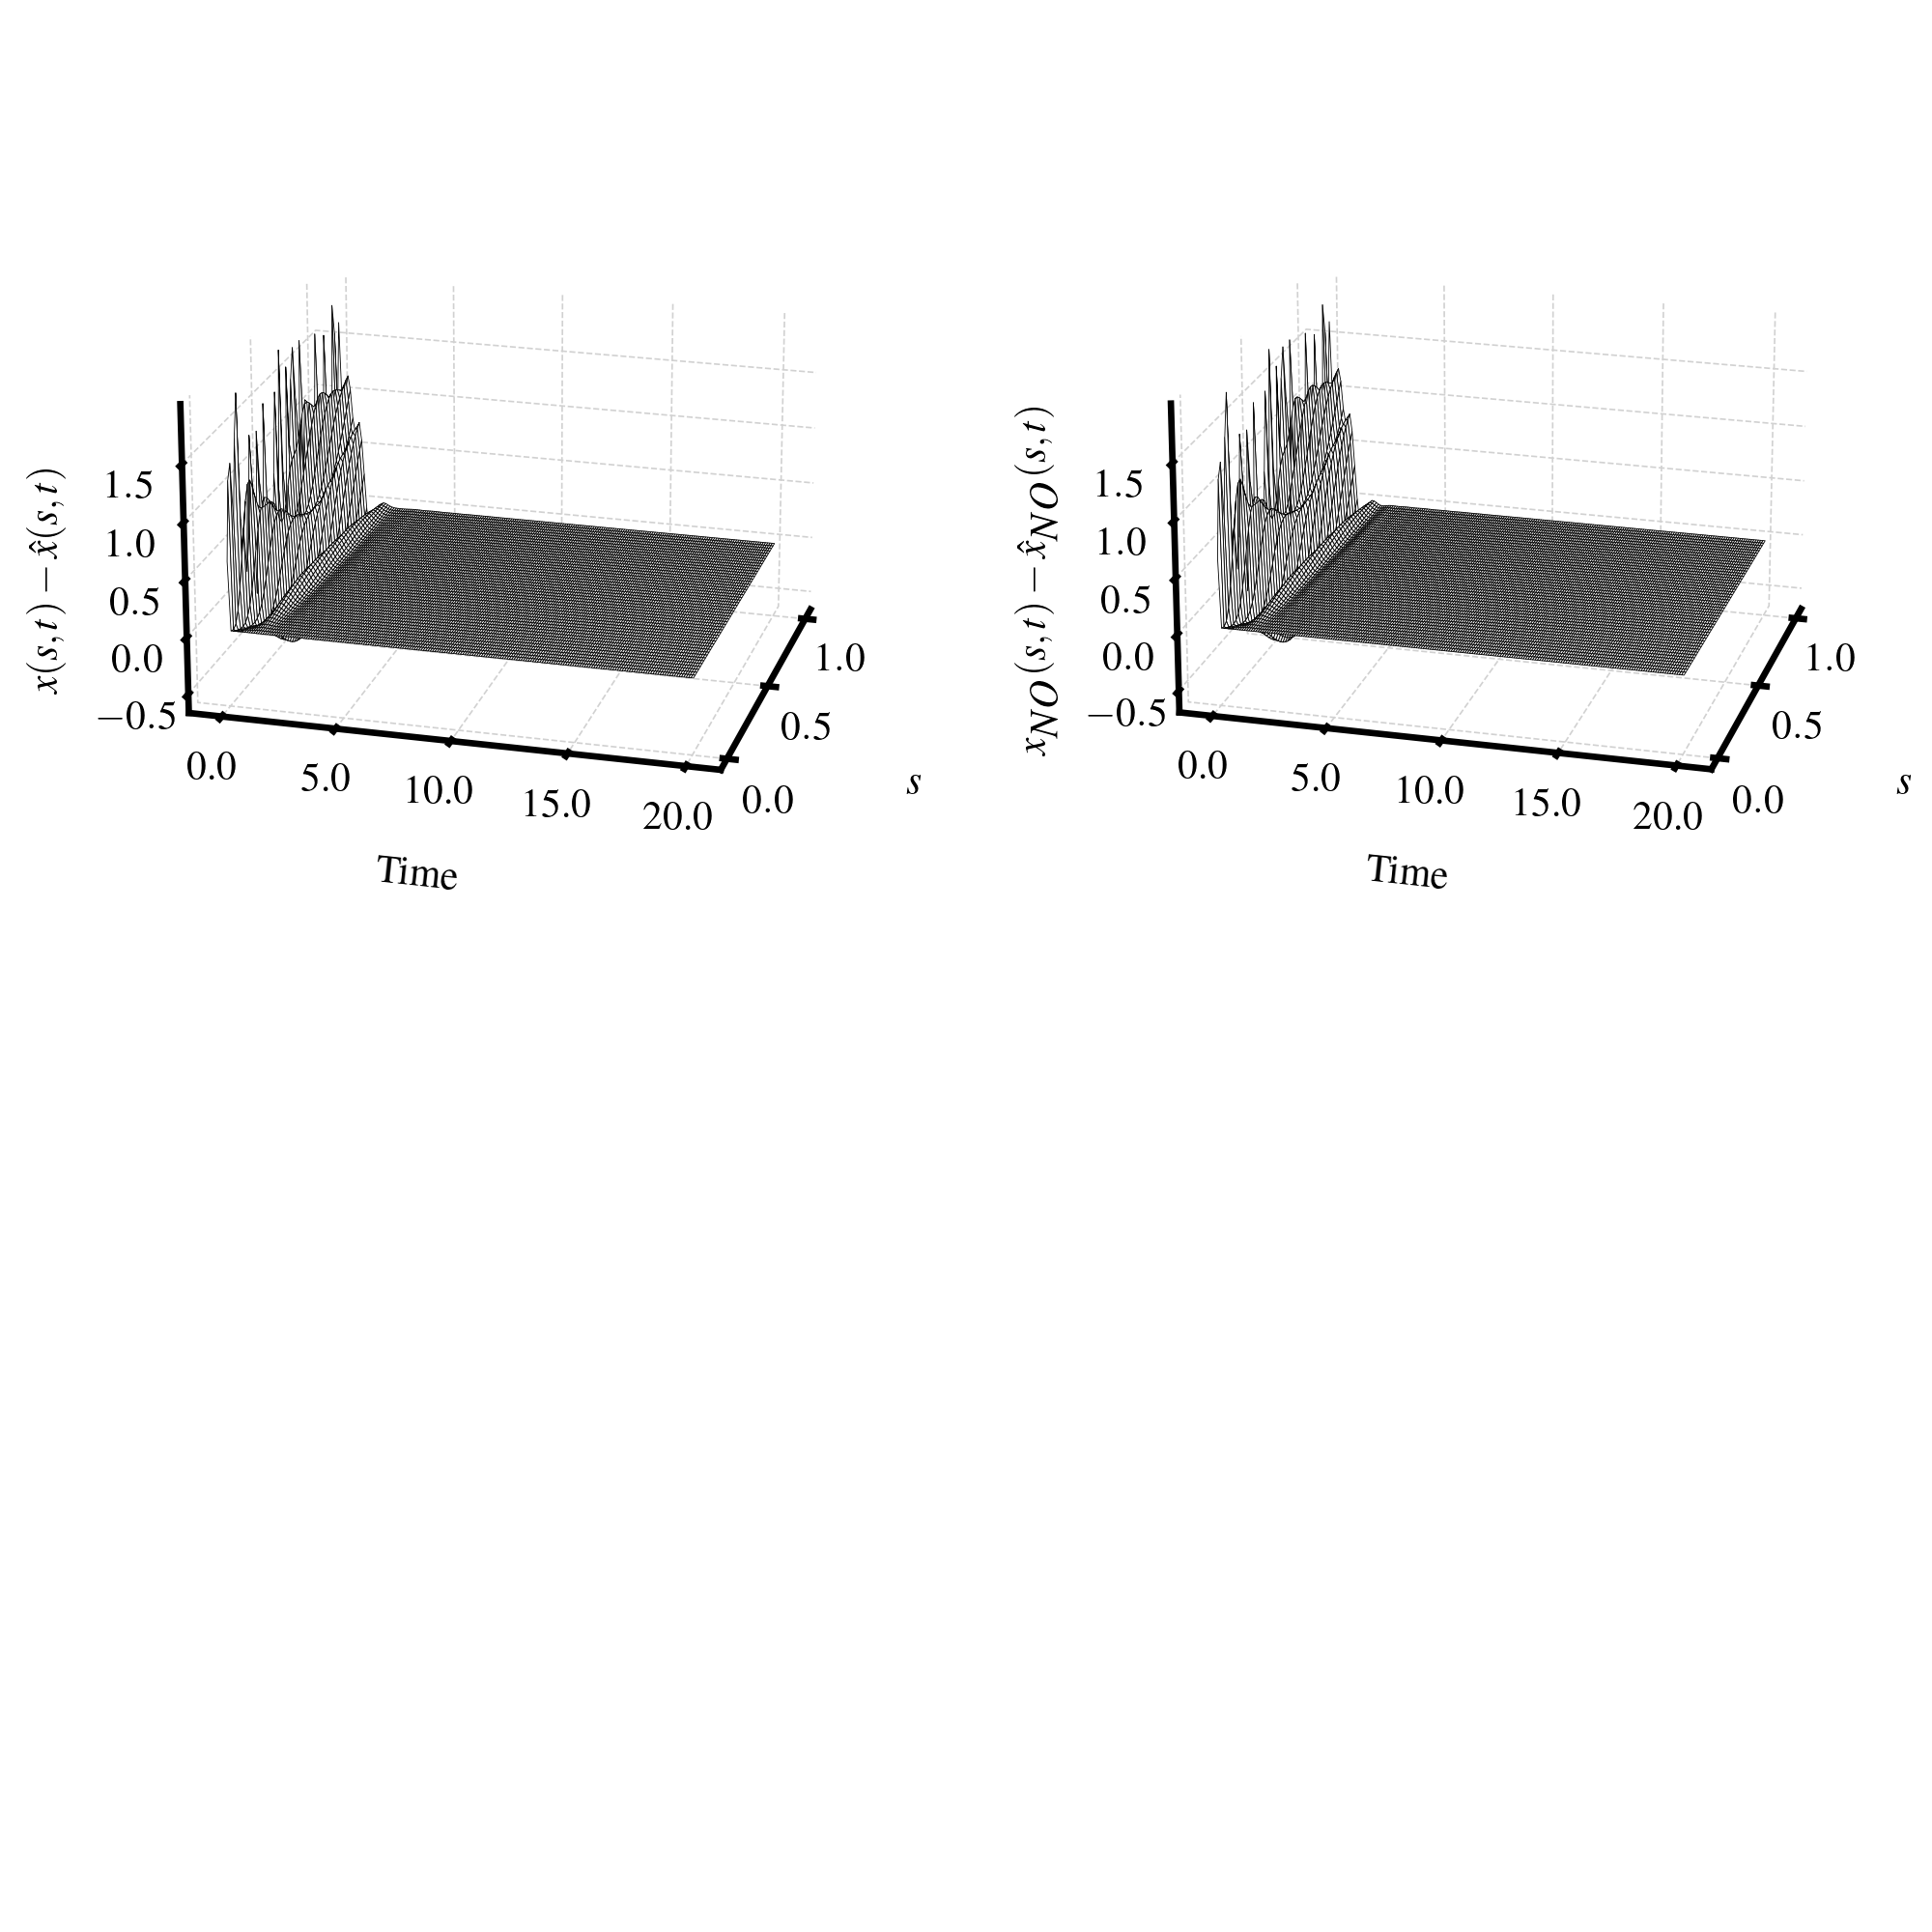

In [ ]:
############### draw output

# res = 10
draw_rate = 100
temporal_draw=temporal[0:nt:draw_rate]
meshx2, mesht2 = np.meshgrid(spatial, temporal_draw)
test=np.zeros(len(temporal_draw))
# fig = plt.figure(figsize=set_size(2000, 0.99, (2, 2), height_add=1))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

fig = plt.figure(figsize=(1000 / my_dpi, 1000 / my_dpi), dpi=600)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)
ax[0]=Axes3D(fig)
ax[1]=Axes3D(fig)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.05, bottom=0, right=0.99, top=0.99, wspace=0.2, hspace=0)

# subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
# meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
# ax[0].plot_surface(meshx, meshy, zeroToNan(kappa1)-zeroToNan(k1),edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
ax[0].plot_surface(meshx2, mesht2, uu_output[0:nt:draw_rate,0:nx]-uu_output_est[0:nt:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax.plot_surface(meshx2, mesht2, ulearning_est[0:nt:draw_rate,:],  
#                         cmap = cm.coolwarm, shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax[0].plot(test, temporal_draw, uu_output_est[0:nt:draw_rate,0], color="red", lw=0.6, antialiased=True)

ax[0].invert_xaxis()
ax[0].get_proj = lambda: np.dot(Axes3D.get_proj(ax[0]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例

# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(20,15)
ax[0].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[0].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[0].set_zlabel(r"$x(s,t)-\hat x(s,t)$",fontsize = 5 , rotation = 90, labelpad=-10)
ax[0].set_xticks([0, 0.5, 1])
# ax[0].set_yticks([0, 10, 20, 30, 40, 50])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5 , pad=-4)  # x轴标签旋转、字号等 

ax[1].plot_surface(meshx2, mesht2, uu_output_learning[0:nt:draw_rate,0:nx]-uu_output_est_learning[0:nt:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax[1].plot_surface(meshx, meshy, kappa2-k2,edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax[1].plot(test, temporal_draw, uu_output_est_learning[0:nt:draw_rate,0], color="red", lw=0.6, antialiased=True)
ax[1].invert_xaxis()
 
ax[1].get_proj = lambda: np.dot(Axes3D.get_proj(ax[1]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例
# vals = (u[0:nt:draw_rate,0].transpose())
# ax[1].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=True)
ax[1].view_init(20, 15)
ax[1].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[1].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[1].set_zlabel(r"$x_{NO}(s,t)-\hat x_{NO}(s,t)$", fontsize = 5 ,rotation = 90, labelpad=-10)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
# ax[1].set_yticks([0, 25, 50])
# ax[1].set_yticks(np.arange(0,60,10))

# ax[1].set_zticks([-2, 0, 2])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax[1].zaxis._PLANES
ax[1].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5]) 
ax[1].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5, pad=-4 )  # x轴标签旋转、字号等 
plt.savefig('img/output_observer_error.pdf', dpi=600,bbox_inches='tight')

In [183]:
uu_output_L2=np.sqrt(np.sum(uu_output*uu_output,axis=1)*dx)
uulearning_output_L2=np.sqrt(np.sum(uu_output_learning*uu_output_learning,axis=1)*dx)
# meshx2_state, mesht2_state = np.meshgrid(spatial, temporal)

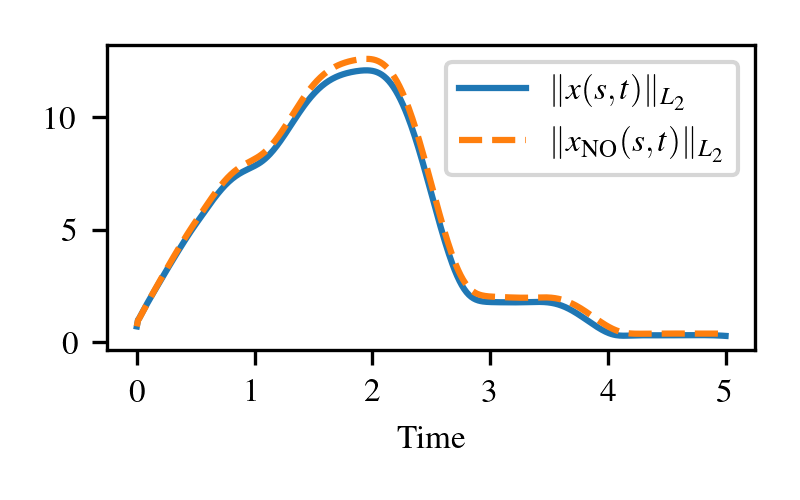

In [184]:
####### draw L2-norm
font3 = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 8,
    }
my_dpi=300
plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(temporal, uu_output_L2,linewidth=1.5,label=r'$\Vert x(s,t)\Vert_{L_2}$')
plt.plot(temporal, uulearning_output_L2,linewidth=1.5,linestyle='--', label=r'$\Vert x_{\rm NO}(s,t)\Vert_{L_2}$')
# plt.legend(loc="upper left",fontsize="8")
plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$\rm{Time}$',fontsize="8")
# plt.ylabel(r'$\Vert x_\rm{NO}(\zeta,t)\Vert$',fontsize="8")
# plt.yticks(np.arange(0,2.5,0.5))
plt.tick_params(labelsize=8)
fig = plt.gcf()
fig.tight_layout()
# plt.savefig('img/u_L2_outout.eps', dpi=300,bbox_inches='tight')


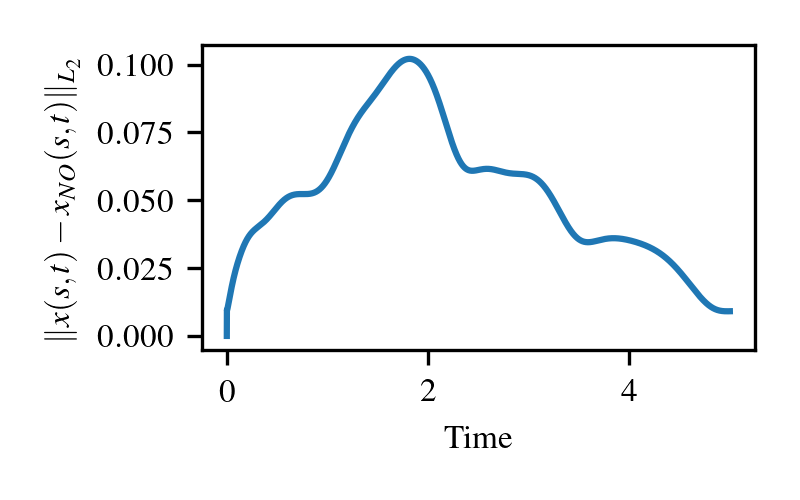

In [127]:
ee_output=uu_output-uu_output_learning
error_u_output_L2=np.sqrt(np.sum(ee_output*ee_output,axis=1)*dx)

fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(temporal[0:nt_draw], error_u_output_L2[0:nt_draw],linewidth=1.5)
# plt.legend(loc="upper left",fontsize="8")
# plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$\rm{Time}$',fontsize="8")
plt.ylabel(r'$\Vert x(s,t) -  x_{NO}(s,t)\Vert_{L_2}$',fontsize="8")
plt.yticks(np.arange(0,0.125,0.025))
plt.tick_params(labelsize=8)

fig = plt.gcf()
fig.tight_layout()
plt.savefig('img/L2error_output.eps', dpi=300,bbox_inches='tight')

In [133]:
uu_output_est_L2=np.sqrt(np.sum(uu_output_est*uu_output_est,axis=1)*dx)
uulearning_output_est_L2=np.sqrt(np.sum(uu_output_est_learning*uu_output_est_learning,axis=1)*dx)
# meshx2_state, mesht2_state = np.meshgrid(spatial, temporal)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


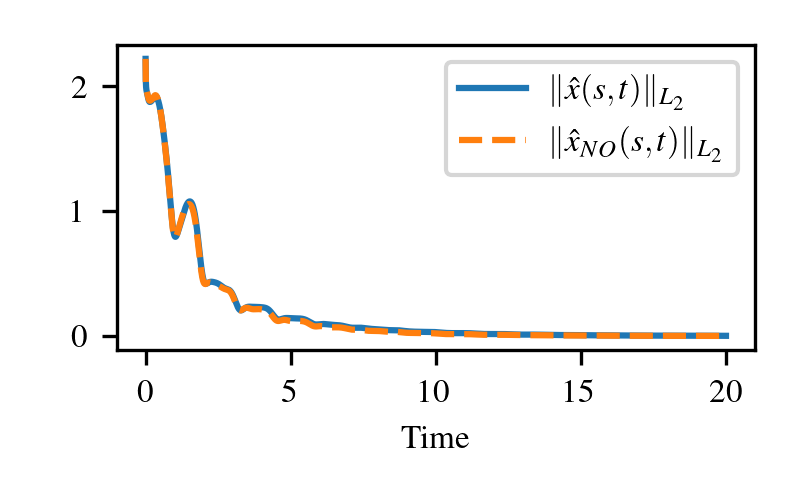

In [ ]:
####### draw L2-norm
font3 = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 8,
    }
my_dpi=300
plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(temporal, uu_output_est_L2,linewidth=1.5,label=r'$\Vert \hat x(s,t)\Vert_{L_2}$')
plt.plot(temporal, uulearning_output_est_L2,linewidth=1.5,linestyle='--', label=r'$\Vert \hat x_{NO}(s,t)\Vert_{L_2}$')
# plt.legend(loc="upper left",fontsize="8")
plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$\rm{Time}$',fontsize="8")
# plt.ylabel(r'$\Vert x_{NO}(\zeta,t)\Vert$',fontsize="8")
# plt.yticks(np.arange(0,2,0.5))
plt.tick_params(labelsize=8)
fig = plt.gcf()
fig.tight_layout()
plt.savefig('img/u_est_L2_outout.eps', dpi=300,bbox_inches='tight')


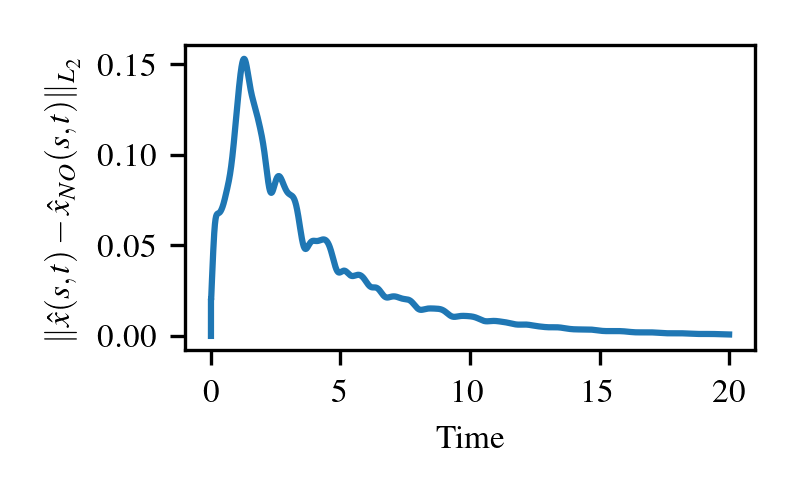

In [ ]:
ee_set_output=uu_output_est-uu_output_est_learning
error_u_output_est_L2=np.sqrt(np.sum(ee_set_output*ee_set_output,axis=1)*dx)

fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(temporal, error_u_output_est_L2,linewidth=1.5)
# plt.legend(loc="upper left",fontsize="8")
# plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$\rm{Time}$',fontsize="8")
plt.ylabel(r'$\Vert\hat x(s,t) - \hat x_{NO}(s,t)\Vert_{L_2}$',fontsize="8")
# plt.yticks(np.arange(0,0.1,0.025))
plt.tick_params(labelsize=8)

fig = plt.gcf()
fig.tight_layout()
plt.savefig('img/error_u_est_L2.eps', dpi=300,bbox_inches='tight')